In [1]:
import numpy as np

import pandas as pd
from pandas import DataFrame

from tensorflow import keras

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Lambda,Reshape
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file

from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K

from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import re
from   scipy  import   signal

import time

import pickle

# for preparing data
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import h5py
import os

In D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
def SliceTensor(X):
    dim1=X.shape[1]
    dim2=X.shape[2]
    return X[:,0:dim1-1,1:dim2-1,:]

In [3]:
def CNNmodel(input_shape,timesteps,kfeatures,dfeatures,act):                 
    
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)
    
    X=X_input
    
    # CONV 1X1 -> RELU Block applied to X
    X = Conv2D(kfeatures, (1, 1), strides = (1, 1), name = 'combine_features')(X)
    
    X = Activation(act)(X)
    
    #reshape
    reshapor1 = Reshape((timesteps,kfeatures,1)) 
    X=reshapor1(X)
    
    
    for i in range(kfeatures-1):
        #在前面一维上加入t=0
        X=ZeroPadding2D(padding=1)(X)
        #slice
        X = Lambda(SliceTensor,output_shape=(None,timesteps+1,kfeatures-i,1))(X)
    
        X=Conv2D(dfeatures, (2, 2), strides = (1, 1), name = 'conv2X2_'+str(i))(X)
        
        X = Activation(act)(X)
    
    
    X = Conv2D(3, (1, 1), strides = (1, 1), name = 'final_a')(X)
    X = Activation('linear')(X)
    
    reshapor2 = Reshape((timesteps,3))
    X=reshapor2(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [4]:
#load dataset_2d
file_path = r'Dataset\dataset_curve_2d.xlsx'
df = pd.read_excel(file_path)
data = np.array(df)

x = data[:,0:6]
y=data[:,6:9]

print(x[0:10,:])
print(y[0:10])

#x y.shape
print(x.shape)
print(y.shape)

[[  3. 110. 159.   6.  14.   0.]
 [  3. 110. 159.   6.  14.   3.]
 [  3. 110. 159.   6.  14.   6.]
 [  3. 110. 159.   6.  14.   9.]
 [  3. 110. 159.   6.  14.  12.]
 [  3. 110. 159.   6.  14.  15.]
 [  3. 110. 159.   6.  14.  18.]
 [  3. 110. 159.   6.  14.  21.]
 [  3. 110. 159.   6.  14.  24.]
 [  3. 110. 159.   6.  14.  27.]]
[[ 6.230e+00  3.000e-02 -3.000e-02]
 [-4.340e+00  1.000e-02 -3.000e-02]
 [-1.031e+01  0.000e+00 -2.000e-02]
 [-1.038e+01  1.000e-02  0.000e+00]
 [-6.420e+00  1.000e-02  1.000e-02]
 [-2.220e+00  1.000e-02  1.000e-02]
 [-1.170e+00 -1.000e-02  0.000e+00]
 [-4.390e+00 -3.000e-02 -2.000e-02]
 [-1.039e+01 -3.000e-02 -3.000e-02]
 [-1.616e+01 -1.000e-02 -1.000e-02]]
(9900, 6)
(9900, 3)


In [5]:
x_train=x[0:9000,:]
x_test=x[9000:9900,:]

y_train=y[0:9000,:]
y_test=y[9000:9900,:]


In [6]:
def FitModel(x_train,y_train,x_cv,y_cv,model,epochss,filepath):

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    time_start=time.time()
    history=model.fit(x_train, y_train,validation_data=(x_cv,y_cv),callbacks=callbacks_list, epochs=epochss)
    time_end=time.time()
    ct=time_end-time_start
    
    return history,ct

In [2]:
os.mkdir(r'Models')
os.mkdir(r'Models/k8_d16')

In [8]:
path = r'Models/k8_d16/' 

for i in range(0,10):
    os.mkdir(path + str(i))

In [9]:
for i in range(0,10):

    x_cv=x_train[i*900:(i+1)*900,:]
    y_cv=y_train[i*900:(i+1)*900,:]

    x_train1=x_train[0:i*900,:]
    x_train2=x_train[(i+1)*900:9000,:]
    x_train_=np.concatenate((x_train1,x_train2))
    print(x_train_.shape)

    y_train1=y_train[0:i*900,:]
    y_train2=y_train[(i+1)*900:9000,:]
    y_train_=np.concatenate((y_train1,y_train2))
    print(y_train_.shape)


    scaler_x = StandardScaler()
    scaler_x.fit(x_train_)
    X_train_scaled = scaler_x.transform(x_train_)
    X_cv_scaled = scaler_x.transform(x_cv)
    
    with open('Models/k8_d16/'+str(i)+'/sx', 'wb') as f:
        pickle.dump(scaler_x, f)

        
    X_train_scaled=X_train_scaled.reshape(81,100,1,6)
    X_cv_scaled=X_cv_scaled.reshape(9,100,1,6)
    
    
    Y_train_scaled=y_train_.reshape(81,100,3)
    Y_cv_scaled=y_cv.reshape(9,100,3)
        
    model = CNNmodel(X_train_scaled.shape[1:],100,8,16,'relu')
    model.compile(keras.optimizers.Adam(learning_rate=1e-2), loss = "mae")
    
    filepath='Models/k8_d16/'+str(i)+'/weights.best.hdf5'
    
    history,ct=FitModel(X_train_scaled,Y_train_scaled,X_cv_scaled,Y_cv_scaled,model,1000,filepath)
    
    
    with open('Models/k8_d16/'+str(i)+'/model_1000epochs', 'wb') as f:
        pickle.dump(model, f)
        
    
    with open('Models/k8_d16/'+str(i)+'/trainHistoryDict.txt', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

(8100, 6)
(8100, 3)
Epoch 1/1000
3/3 [==============================] - ETA: 0s - loss: 8.5738
Epoch 1: val_loss improved from inf to 6.75253, saving model to Models/k8_d16/0\weights.best.hdf5
3/3 [==============================] - 4s 403ms/step - loss: 8.5738 - val_loss: 6.7525
Epoch 2/1000
2/3 [===================>..........] - ETA: 0s - loss: 8.5766
Epoch 2: val_loss improved from 6.75253 to 6.70253, saving model to Models/k8_d16/0\weights.best.hdf5
3/3 [==============================] - 0s 200ms/step - loss: 8.4648 - val_loss: 6.7025
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 8.1715
Epoch 3: val_loss did not improve from 6.70253
3/3 [==============================] - 0s 96ms/step - loss: 8.1715 - val_loss: 7.0075
Epoch 4/1000
2/3 [===================>..........] - ETA: 0s - loss: 8.0315
Epoch 4: val_loss improved from 6.70253 to 6.49367, saving model to Models/k8_d16/0\weights.best.hdf5
3/3 [==============================] - 0s 184ms/step - loss: 8.0993 - v

3/3 [==============================] - 0s 185ms/step - loss: 3.5720 - val_loss: 3.0528
Epoch 35/1000
3/3 [==============================] - ETA: 0s - loss: 3.3954
Epoch 35: val_loss improved from 3.05284 to 2.74477, saving model to Models/k8_d16/0\weights.best.hdf5
3/3 [==============================] - 0s 187ms/step - loss: 3.3954 - val_loss: 2.7448
Epoch 36/1000
3/3 [==============================] - ETA: 0s - loss: 3.2287
Epoch 36: val_loss improved from 2.74477 to 2.68259, saving model to Models/k8_d16/0\weights.best.hdf5
3/3 [==============================] - 0s 166ms/step - loss: 3.2287 - val_loss: 2.6826
Epoch 37/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.0931
Epoch 37: val_loss did not improve from 2.68259
3/3 [==============================] - 0s 74ms/step - loss: 3.0625 - val_loss: 2.9706
Epoch 38/1000
3/3 [==============================] - ETA: 0s - loss: 3.1122
Epoch 38: val_loss did not improve from 2.68259
3/3 [==============================] - 0s 100ms

3/3 [==============================] - 1s 224ms/step - loss: 1.9176 - val_loss: 1.7296
Epoch 70/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.8042
Epoch 70: val_loss did not improve from 1.72956
3/3 [==============================] - 0s 112ms/step - loss: 1.8343 - val_loss: 1.9316
Epoch 71/1000
3/3 [==============================] - ETA: 0s - loss: 1.8473
Epoch 71: val_loss did not improve from 1.72956
3/3 [==============================] - 0s 142ms/step - loss: 1.8473 - val_loss: 1.7795
Epoch 72/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.9075
Epoch 72: val_loss did not improve from 1.72956
3/3 [==============================] - 0s 104ms/step - loss: 1.8214 - val_loss: 1.7613
Epoch 73/1000
3/3 [==============================] - ETA: 0s - loss: 1.7626
Epoch 73: val_loss did not improve from 1.72956
3/3 [==============================] - 0s 129ms/step - loss: 1.7626 - val_loss: 1.9057
Epoch 74/1000
3/3 [==============================] - ETA: 0s - loss: 

Epoch 108/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.7180
Epoch 108: val_loss did not improve from 1.58316
3/3 [==============================] - 0s 60ms/step - loss: 1.7371 - val_loss: 1.7852
Epoch 109/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.7617
Epoch 109: val_loss did not improve from 1.58316
3/3 [==============================] - 0s 66ms/step - loss: 1.7513 - val_loss: 1.7506
Epoch 110/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.6405
Epoch 110: val_loss did not improve from 1.58316
3/3 [==============================] - 0s 65ms/step - loss: 1.6318 - val_loss: 1.6118
Epoch 111/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.5603
Epoch 111: val_loss did not improve from 1.58316
3/3 [==============================] - 0s 82ms/step - loss: 1.5952 - val_loss: 1.6940
Epoch 112/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.5291
Epoch 112: val_loss did not improve from 1.58316
3/3 [=====================

3/3 [==============================] - 0s 58ms/step - loss: 1.3807 - val_loss: 1.5160
Epoch 146/1000
3/3 [==============================] - ETA: 0s - loss: 1.3665
Epoch 146: val_loss improved from 1.43946 to 1.42105, saving model to Models/k8_d16/0\weights.best.hdf5
3/3 [==============================] - 0s 122ms/step - loss: 1.3665 - val_loss: 1.4211
Epoch 147/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3083
Epoch 147: val_loss did not improve from 1.42105
3/3 [==============================] - 0s 58ms/step - loss: 1.3432 - val_loss: 1.6210
Epoch 148/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3937
Epoch 148: val_loss did not improve from 1.42105
3/3 [==============================] - 0s 64ms/step - loss: 1.4132 - val_loss: 1.4856
Epoch 149/1000
3/3 [==============================] - ETA: 0s - loss: 1.3708
Epoch 149: val_loss did not improve from 1.42105
3/3 [==============================] - 0s 62ms/step - loss: 1.3708 - val_loss: 1.4711
Epoch 150/

3/3 [==============================] - ETA: 0s - loss: 1.2932
Epoch 221: val_loss did not improve from 1.26545
3/3 [==============================] - 0s 112ms/step - loss: 1.2932 - val_loss: 1.4346
Epoch 222/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2592
Epoch 222: val_loss did not improve from 1.26545
3/3 [==============================] - 0s 93ms/step - loss: 1.3137 - val_loss: 1.2670
Epoch 223/1000
3/3 [==============================] - ETA: 0s - loss: 1.2746
Epoch 223: val_loss did not improve from 1.26545
3/3 [==============================] - 0s 82ms/step - loss: 1.2746 - val_loss: 1.2792
Epoch 224/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3211
Epoch 224: val_loss did not improve from 1.26545
3/3 [==============================] - 0s 69ms/step - loss: 1.2634 - val_loss: 1.3563
Epoch 225/1000
3/3 [==============================] - ETA: 0s - loss: 1.3169
Epoch 225: val_loss improved from 1.26545 to 1.23864, saving model to Models/k8_d16/0\wei

Epoch 259/1000
3/3 [==============================] - ETA: 0s - loss: 1.2551
Epoch 259: val_loss did not improve from 1.20644
3/3 [==============================] - 0s 52ms/step - loss: 1.2551 - val_loss: 1.5050
Epoch 260/1000
3/3 [==============================] - ETA: 0s - loss: 1.3000
Epoch 260: val_loss did not improve from 1.20644
3/3 [==============================] - 0s 54ms/step - loss: 1.3000 - val_loss: 1.3240
Epoch 261/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2997
Epoch 261: val_loss did not improve from 1.20644
3/3 [==============================] - 0s 54ms/step - loss: 1.2542 - val_loss: 1.3961
Epoch 262/1000
3/3 [==============================] - ETA: 0s - loss: 1.2178
Epoch 262: val_loss did not improve from 1.20644
3/3 [==============================] - 0s 50ms/step - loss: 1.2178 - val_loss: 1.5010
Epoch 263/1000
3/3 [==============================] - ETA: 0s - loss: 1.2894
Epoch 263: val_loss improved from 1.20644 to 1.19155, saving model to Model

3/3 [==============================] - 0s 65ms/step - loss: 1.2487 - val_loss: 1.5494
Epoch 298/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3354
Epoch 298: val_loss did not improve from 1.19155
3/3 [==============================] - 0s 86ms/step - loss: 1.3124 - val_loss: 1.1992
Epoch 299/1000
3/3 [==============================] - ETA: 0s - loss: 1.2062
Epoch 299: val_loss did not improve from 1.19155
3/3 [==============================] - 0s 56ms/step - loss: 1.2062 - val_loss: 1.2328
Epoch 300/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2165
Epoch 300: val_loss did not improve from 1.19155
3/3 [==============================] - 0s 55ms/step - loss: 1.1898 - val_loss: 1.2991
Epoch 301/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1163
Epoch 301: val_loss did not improve from 1.19155
3/3 [==============================] - 0s 96ms/step - loss: 1.1142 - val_loss: 1.3312
Epoch 302/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 336/1000
3/3 [==============================] - ETA: 0s - loss: 1.0450
Epoch 336: val_loss did not improve from 1.19077
3/3 [==============================] - 0s 67ms/step - loss: 1.0450 - val_loss: 1.2167
Epoch 337/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1177
Epoch 337: val_loss did not improve from 1.19077
3/3 [==============================] - 0s 66ms/step - loss: 1.1184 - val_loss: 1.2773
Epoch 338/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1101
Epoch 338: val_loss did not improve from 1.19077
3/3 [==============================] - 0s 83ms/step - loss: 1.1142 - val_loss: 1.2925
Epoch 339/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1405
Epoch 339: val_loss did not improve from 1.19077
3/3 [==============================] - 0s 89ms/step - loss: 1.1056 - val_loss: 1.2923
Epoch 340/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1429
Epoch 340: val_loss did not improve from 1.19077
3/3 [=====================

Epoch 375/1000
3/3 [==============================] - ETA: 0s - loss: 1.1587
Epoch 375: val_loss did not improve from 1.19077
3/3 [==============================] - 0s 55ms/step - loss: 1.1587 - val_loss: 1.4517
Epoch 376/1000
3/3 [==============================] - ETA: 0s - loss: 1.2426
Epoch 376: val_loss did not improve from 1.19077
3/3 [==============================] - 0s 61ms/step - loss: 1.2426 - val_loss: 1.2523
Epoch 377/1000
3/3 [==============================] - ETA: 0s - loss: 1.1804
Epoch 377: val_loss did not improve from 1.19077
3/3 [==============================] - 0s 63ms/step - loss: 1.1804 - val_loss: 1.2766
Epoch 378/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2484
Epoch 378: val_loss did not improve from 1.19077
3/3 [==============================] - 0s 65ms/step - loss: 1.2318 - val_loss: 1.4038
Epoch 379/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2384
Epoch 379: val_loss did not improve from 1.19077
3/3 [=====================

3/3 [==============================] - 0s 47ms/step - loss: 1.1119 - val_loss: 1.2309
Epoch 413/1000
3/3 [==============================] - ETA: 0s - loss: 1.1129
Epoch 413: val_loss did not improve from 1.14990
3/3 [==============================] - 0s 47ms/step - loss: 1.1129 - val_loss: 1.2624
Epoch 414/1000
3/3 [==============================] - ETA: 0s - loss: 1.1332
Epoch 414: val_loss did not improve from 1.14990
3/3 [==============================] - 0s 63ms/step - loss: 1.1332 - val_loss: 1.2579
Epoch 415/1000
3/3 [==============================] - ETA: 0s - loss: 1.0788
Epoch 415: val_loss did not improve from 1.14990
3/3 [==============================] - 0s 54ms/step - loss: 1.0788 - val_loss: 1.1804
Epoch 416/1000
3/3 [==============================] - ETA: 0s - loss: 1.0598
Epoch 416: val_loss did not improve from 1.14990
3/3 [==============================] - 0s 55ms/step - loss: 1.0598 - val_loss: 1.1675
Epoch 417/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 451/1000
3/3 [==============================] - ETA: 0s - loss: 1.1825
Epoch 451: val_loss did not improve from 1.13064
3/3 [==============================] - 0s 55ms/step - loss: 1.1825 - val_loss: 1.1487
Epoch 452/1000
3/3 [==============================] - ETA: 0s - loss: 1.1557
Epoch 452: val_loss did not improve from 1.13064
3/3 [==============================] - 0s 55ms/step - loss: 1.1557 - val_loss: 1.3263
Epoch 453/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.1005
Epoch 453: val_loss did not improve from 1.13064
3/3 [==============================] - 0s 39ms/step - loss: 1.1189 - val_loss: 1.1861
Epoch 454/1000
3/3 [==============================] - ETA: 0s - loss: 1.0879
Epoch 454: val_loss did not improve from 1.13064
3/3 [==============================] - 0s 47ms/step - loss: 1.0879 - val_loss: 1.1342
Epoch 455/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.0486
Epoch 455: val_loss did not improve from 1.13064
3/3 [=====================

3/3 [==============================] - 0s 55ms/step - loss: 0.9941 - val_loss: 1.1803
Epoch 490/1000
3/3 [==============================] - ETA: 0s - loss: 0.9887
Epoch 490: val_loss did not improve from 1.10767
3/3 [==============================] - 0s 54ms/step - loss: 0.9887 - val_loss: 1.2175
Epoch 491/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0790
Epoch 491: val_loss did not improve from 1.10767
3/3 [==============================] - 0s 66ms/step - loss: 1.0848 - val_loss: 1.3189
Epoch 492/1000
3/3 [==============================] - ETA: 0s - loss: 1.0804
Epoch 492: val_loss did not improve from 1.10767
3/3 [==============================] - 0s 62ms/step - loss: 1.0804 - val_loss: 1.1183
Epoch 493/1000
3/3 [==============================] - ETA: 0s - loss: 1.0487
Epoch 493: val_loss did not improve from 1.10767
3/3 [==============================] - 0s 53ms/step - loss: 1.0487 - val_loss: 1.2415
Epoch 494/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 528/1000
3/3 [==============================] - ETA: 0s - loss: 0.9988
Epoch 528: val_loss did not improve from 1.10504
3/3 [==============================] - 0s 52ms/step - loss: 0.9988 - val_loss: 1.1459
Epoch 529/1000
3/3 [==============================] - ETA: 0s - loss: 0.9783
Epoch 529: val_loss did not improve from 1.10504
3/3 [==============================] - 0s 52ms/step - loss: 0.9783 - val_loss: 1.2272
Epoch 530/1000
3/3 [==============================] - ETA: 0s - loss: 0.9947
Epoch 530: val_loss did not improve from 1.10504
3/3 [==============================] - 0s 55ms/step - loss: 0.9947 - val_loss: 1.2513
Epoch 531/1000
3/3 [==============================] - ETA: 0s - loss: 1.0474
Epoch 531: val_loss did not improve from 1.10504
3/3 [==============================] - 0s 52ms/step - loss: 1.0474 - val_loss: 1.2271
Epoch 532/1000
3/3 [==============================] - ETA: 0s - loss: 1.0036
Epoch 532: val_loss did not improve from 1.10504
3/3 [=====================

Epoch 567/1000
3/3 [==============================] - ETA: 0s - loss: 1.0294
Epoch 567: val_loss did not improve from 1.10504
3/3 [==============================] - 0s 49ms/step - loss: 1.0294 - val_loss: 1.1386
Epoch 568/1000
3/3 [==============================] - ETA: 0s - loss: 1.0545
Epoch 568: val_loss did not improve from 1.10504
3/3 [==============================] - 0s 49ms/step - loss: 1.0545 - val_loss: 1.2112
Epoch 569/1000
3/3 [==============================] - ETA: 0s - loss: 1.0519
Epoch 569: val_loss did not improve from 1.10504
3/3 [==============================] - 0s 50ms/step - loss: 1.0519 - val_loss: 1.2452
Epoch 570/1000
3/3 [==============================] - ETA: 0s - loss: 1.0181
Epoch 570: val_loss did not improve from 1.10504
3/3 [==============================] - 0s 48ms/step - loss: 1.0181 - val_loss: 1.1637
Epoch 571/1000
3/3 [==============================] - ETA: 0s - loss: 1.0300
Epoch 571: val_loss did not improve from 1.10504
3/3 [=====================

3/3 [==============================] - 0s 51ms/step - loss: 0.9947 - val_loss: 1.3253
Epoch 606/1000
3/3 [==============================] - ETA: 0s - loss: 1.0344
Epoch 606: val_loss did not improve from 1.08757
3/3 [==============================] - 0s 48ms/step - loss: 1.0344 - val_loss: 1.5403
Epoch 607/1000
3/3 [==============================] - ETA: 0s - loss: 1.1360
Epoch 607: val_loss did not improve from 1.08757
3/3 [==============================] - 0s 45ms/step - loss: 1.1360 - val_loss: 1.3295
Epoch 608/1000
3/3 [==============================] - ETA: 0s - loss: 1.1147
Epoch 608: val_loss did not improve from 1.08757
3/3 [==============================] - 0s 44ms/step - loss: 1.1147 - val_loss: 1.2593
Epoch 609/1000
3/3 [==============================] - ETA: 0s - loss: 1.1602
Epoch 609: val_loss did not improve from 1.08757
3/3 [==============================] - 0s 45ms/step - loss: 1.1602 - val_loss: 1.2577
Epoch 610/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 683/1000
3/3 [==============================] - ETA: 0s - loss: 1.0381
Epoch 683: val_loss did not improve from 1.08757
3/3 [==============================] - 0s 55ms/step - loss: 1.0381 - val_loss: 1.2365
Epoch 684/1000
3/3 [==============================] - ETA: 0s - loss: 1.0254
Epoch 684: val_loss did not improve from 1.08757
3/3 [==============================] - 0s 59ms/step - loss: 1.0254 - val_loss: 1.4097
Epoch 685/1000
3/3 [==============================] - ETA: 0s - loss: 1.0912
Epoch 685: val_loss improved from 1.08757 to 1.07524, saving model to Models/k8_d16/0\weights.best.hdf5
3/3 [==============================] - 0s 157ms/step - loss: 1.0912 - val_loss: 1.0752
Epoch 686/1000
3/3 [==============================] - ETA: 0s - loss: 1.0517
Epoch 686: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 57ms/step - loss: 1.0517 - val_loss: 1.1642
Epoch 687/1000
3/3 [==============================] - ETA: 0s - loss: 1.0262
Epoch 687: val_loss

3/3 [==============================] - 0s 55ms/step - loss: 1.0714 - val_loss: 1.3331
Epoch 722/1000
3/3 [==============================] - ETA: 0s - loss: 1.0965
Epoch 722: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 53ms/step - loss: 1.0965 - val_loss: 1.2665
Epoch 723/1000
3/3 [==============================] - ETA: 0s - loss: 1.1179
Epoch 723: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 55ms/step - loss: 1.1179 - val_loss: 1.5041
Epoch 724/1000
3/3 [==============================] - ETA: 0s - loss: 1.1568
Epoch 724: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 62ms/step - loss: 1.1568 - val_loss: 1.1634
Epoch 725/1000
3/3 [==============================] - ETA: 0s - loss: 0.9860
Epoch 725: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 57ms/step - loss: 0.9860 - val_loss: 1.2249
Epoch 726/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 799/1000
3/3 [==============================] - ETA: 0s - loss: 0.9329
Epoch 799: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 47ms/step - loss: 0.9329 - val_loss: 1.1554
Epoch 800/1000
3/3 [==============================] - ETA: 0s - loss: 0.8741
Epoch 800: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 51ms/step - loss: 0.8741 - val_loss: 1.1148
Epoch 801/1000
3/3 [==============================] - ETA: 0s - loss: 0.8822
Epoch 801: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 49ms/step - loss: 0.8822 - val_loss: 1.1834
Epoch 802/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8677
Epoch 802: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 57ms/step - loss: 0.8814 - val_loss: 1.1820
Epoch 803/1000
3/3 [==============================] - ETA: 0s - loss: 0.8767
Epoch 803: val_loss did not improve from 1.07524
3/3 [=====================

Epoch 838/1000
3/3 [==============================] - ETA: 0s - loss: 0.9427
Epoch 838: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 58ms/step - loss: 0.9427 - val_loss: 1.3405
Epoch 839/1000
3/3 [==============================] - ETA: 0s - loss: 0.9472
Epoch 839: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 60ms/step - loss: 0.9472 - val_loss: 1.2989
Epoch 840/1000
3/3 [==============================] - ETA: 0s - loss: 1.0086
Epoch 840: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 54ms/step - loss: 1.0086 - val_loss: 1.2041
Epoch 841/1000
3/3 [==============================] - ETA: 0s - loss: 0.9823
Epoch 841: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 55ms/step - loss: 0.9823 - val_loss: 1.3986
Epoch 842/1000
3/3 [==============================] - ETA: 0s - loss: 1.1195
Epoch 842: val_loss did not improve from 1.07524
3/3 [=====================

Epoch 877/1000
3/3 [==============================] - ETA: 0s - loss: 0.8998
Epoch 877: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 55ms/step - loss: 0.8998 - val_loss: 1.2188
Epoch 878/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9467
Epoch 878: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 67ms/step - loss: 0.9741 - val_loss: 1.1801
Epoch 879/1000
3/3 [==============================] - ETA: 0s - loss: 1.0304
Epoch 879: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 58ms/step - loss: 1.0304 - val_loss: 1.2315
Epoch 880/1000
3/3 [==============================] - ETA: 0s - loss: 1.0041
Epoch 880: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 56ms/step - loss: 1.0041 - val_loss: 1.2266
Epoch 881/1000
3/3 [==============================] - ETA: 0s - loss: 0.9596
Epoch 881: val_loss did not improve from 1.07524
3/3 [=====================

Epoch 916/1000
3/3 [==============================] - ETA: 0s - loss: 0.9367
Epoch 916: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 49ms/step - loss: 0.9367 - val_loss: 1.2702
Epoch 917/1000
3/3 [==============================] - ETA: 0s - loss: 0.9692
Epoch 917: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 45ms/step - loss: 0.9692 - val_loss: 1.1807
Epoch 918/1000
3/3 [==============================] - ETA: 0s - loss: 0.9335
Epoch 918: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 45ms/step - loss: 0.9335 - val_loss: 1.2494
Epoch 919/1000
3/3 [==============================] - ETA: 0s - loss: 1.0243
Epoch 919: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 50ms/step - loss: 1.0243 - val_loss: 1.2352
Epoch 920/1000
3/3 [==============================] - ETA: 0s - loss: 0.9733
Epoch 920: val_loss did not improve from 1.07524
3/3 [=====================

Epoch 955/1000
3/3 [==============================] - ETA: 0s - loss: 0.9505
Epoch 955: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 45ms/step - loss: 0.9505 - val_loss: 1.3509
Epoch 956/1000
3/3 [==============================] - ETA: 0s - loss: 1.0030
Epoch 956: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 52ms/step - loss: 1.0030 - val_loss: 1.4187
Epoch 957/1000
3/3 [==============================] - ETA: 0s - loss: 1.0736
Epoch 957: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 50ms/step - loss: 1.0736 - val_loss: 1.2444
Epoch 958/1000
3/3 [==============================] - ETA: 0s - loss: 1.1291
Epoch 958: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 46ms/step - loss: 1.1291 - val_loss: 1.2292
Epoch 959/1000
3/3 [==============================] - ETA: 0s - loss: 1.0755
Epoch 959: val_loss did not improve from 1.07524
3/3 [=====================

Epoch 994/1000
3/3 [==============================] - ETA: 0s - loss: 0.9392
Epoch 994: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 51ms/step - loss: 0.9392 - val_loss: 1.2906
Epoch 995/1000
3/3 [==============================] - ETA: 0s - loss: 0.9769
Epoch 995: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 53ms/step - loss: 0.9769 - val_loss: 1.3012
Epoch 996/1000
3/3 [==============================] - ETA: 0s - loss: 1.0415
Epoch 996: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 51ms/step - loss: 1.0415 - val_loss: 1.1648
Epoch 997/1000
3/3 [==============================] - ETA: 0s - loss: 1.0416
Epoch 997: val_loss did not improve from 1.07524
3/3 [==============================] - 0s 50ms/step - loss: 1.0416 - val_loss: 1.2703
Epoch 998/1000
3/3 [==============================] - ETA: 0s - loss: 1.1168
Epoch 998: val_loss did not improve from 1.07524
3/3 [=====================

3/3 [==============================] - ETA: 0s - loss: 1.8890
Epoch 53: val_loss did not improve from 2.79078
3/3 [==============================] - 0s 44ms/step - loss: 1.8890 - val_loss: 2.8265
Epoch 54/1000
3/3 [==============================] - ETA: 0s - loss: 1.9289
Epoch 54: val_loss improved from 2.79078 to 2.75647, saving model to Models/k8_d16/1\weights.best.hdf5
3/3 [==============================] - 0s 95ms/step - loss: 1.9289 - val_loss: 2.7565
Epoch 55/1000
3/3 [==============================] - ETA: 0s - loss: 1.7996
Epoch 55: val_loss did not improve from 2.75647
3/3 [==============================] - 0s 46ms/step - loss: 1.7996 - val_loss: 2.8872
Epoch 56/1000
3/3 [==============================] - ETA: 0s - loss: 1.9231
Epoch 56: val_loss did not improve from 2.75647
3/3 [==============================] - 0s 48ms/step - loss: 1.9231 - val_loss: 2.9871
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 1.8325
Epoch 57: val_loss improved from 2.75647 to

3/3 [==============================] - 0s 48ms/step - loss: 1.4867 - val_loss: 2.7455
Epoch 91/1000
3/3 [==============================] - ETA: 0s - loss: 1.5445
Epoch 91: val_loss did not improve from 2.53907
3/3 [==============================] - 0s 45ms/step - loss: 1.5445 - val_loss: 2.7528
Epoch 92/1000
3/3 [==============================] - ETA: 0s - loss: 1.5324
Epoch 92: val_loss improved from 2.53907 to 2.52719, saving model to Models/k8_d16/1\weights.best.hdf5
3/3 [==============================] - 0s 121ms/step - loss: 1.5324 - val_loss: 2.5272
Epoch 93/1000
3/3 [==============================] - ETA: 0s - loss: 1.5623
Epoch 93: val_loss did not improve from 2.52719
3/3 [==============================] - 0s 47ms/step - loss: 1.5623 - val_loss: 2.5390
Epoch 94/1000
3/3 [==============================] - ETA: 0s - loss: 1.7060
Epoch 94: val_loss did not improve from 2.52719
3/3 [==============================] - 0s 45ms/step - loss: 1.7060 - val_loss: 2.7404
Epoch 95/1000
3/3 

3/3 [==============================] - 0s 56ms/step - loss: 1.3031 - val_loss: 2.5241
Epoch 129/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3155
Epoch 129: val_loss did not improve from 2.25338
3/3 [==============================] - 0s 81ms/step - loss: 1.2931 - val_loss: 2.3724
Epoch 130/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3016
Epoch 130: val_loss did not improve from 2.25338
3/3 [==============================] - 0s 84ms/step - loss: 1.3026 - val_loss: 2.5754
Epoch 131/1000
3/3 [==============================] - ETA: 0s - loss: 1.2966
Epoch 131: val_loss improved from 2.25338 to 2.21888, saving model to Models/k8_d16/1\weights.best.hdf5
3/3 [==============================] - 1s 262ms/step - loss: 1.2966 - val_loss: 2.2189
Epoch 132/1000
3/3 [==============================] - ETA: 0s - loss: 1.3300
Epoch 132: val_loss did not improve from 2.21888
3/3 [==============================] - 0s 132ms/step - loss: 1.3300 - val_loss: 2.5368
Epoch 133

3/3 [==============================] - 0s 71ms/step - loss: 1.2091 - val_loss: 2.3878
Epoch 167/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2240
Epoch 167: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 85ms/step - loss: 1.2461 - val_loss: 2.6314
Epoch 168/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2917
Epoch 168: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 85ms/step - loss: 1.3584 - val_loss: 2.1883
Epoch 169/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4305
Epoch 169: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 72ms/step - loss: 1.4042 - val_loss: 2.4021
Epoch 170/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4043
Epoch 170: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 66ms/step - loss: 1.3639 - val_loss: 3.2386
Epoch 171/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 244/1000
3/3 [==============================] - ETA: 0s - loss: 1.1189
Epoch 244: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 58ms/step - loss: 1.1189 - val_loss: 2.3378
Epoch 245/1000
3/3 [==============================] - ETA: 0s - loss: 1.1719
Epoch 245: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 60ms/step - loss: 1.1719 - val_loss: 2.6379
Epoch 246/1000
3/3 [==============================] - ETA: 0s - loss: 1.1273
Epoch 246: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 55ms/step - loss: 1.1273 - val_loss: 2.3310
Epoch 247/1000
3/3 [==============================] - ETA: 0s - loss: 1.1038
Epoch 247: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 52ms/step - loss: 1.1038 - val_loss: 2.2931
Epoch 248/1000
3/3 [==============================] - ETA: 0s - loss: 1.0944
Epoch 248: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 283/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0312
Epoch 283: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 59ms/step - loss: 1.0216 - val_loss: 2.2640
Epoch 284/1000
3/3 [==============================] - ETA: 0s - loss: 1.1100
Epoch 284: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 55ms/step - loss: 1.1100 - val_loss: 2.5049
Epoch 285/1000
3/3 [==============================] - ETA: 0s - loss: 1.1175
Epoch 285: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 55ms/step - loss: 1.1175 - val_loss: 2.4823
Epoch 286/1000
3/3 [==============================] - ETA: 0s - loss: 1.2273
Epoch 286: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 55ms/step - loss: 1.2273 - val_loss: 2.4255
Epoch 287/1000
3/3 [==============================] - ETA: 0s - loss: 1.1994
Epoch 287: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 322/1000
3/3 [==============================] - ETA: 0s - loss: 1.0739
Epoch 322: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 59ms/step - loss: 1.0739 - val_loss: 2.3303
Epoch 323/1000
3/3 [==============================] - ETA: 0s - loss: 1.0107
Epoch 323: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 58ms/step - loss: 1.0107 - val_loss: 2.5052
Epoch 324/1000
3/3 [==============================] - ETA: 0s - loss: 1.0514
Epoch 324: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 59ms/step - loss: 1.0514 - val_loss: 2.3860
Epoch 325/1000
3/3 [==============================] - ETA: 0s - loss: 0.9968
Epoch 325: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 58ms/step - loss: 0.9968 - val_loss: 2.2729
Epoch 326/1000
3/3 [==============================] - ETA: 0s - loss: 0.9967
Epoch 326: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 361/1000
3/3 [==============================] - ETA: 0s - loss: 1.0600
Epoch 361: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 56ms/step - loss: 1.0600 - val_loss: 2.3294
Epoch 362/1000
3/3 [==============================] - ETA: 0s - loss: 1.0340
Epoch 362: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 59ms/step - loss: 1.0340 - val_loss: 2.5452
Epoch 363/1000
3/3 [==============================] - ETA: 0s - loss: 0.9736
Epoch 363: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 63ms/step - loss: 0.9736 - val_loss: 2.3021
Epoch 364/1000
3/3 [==============================] - ETA: 0s - loss: 0.9820
Epoch 364: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 60ms/step - loss: 0.9820 - val_loss: 2.4148
Epoch 365/1000
3/3 [==============================] - ETA: 0s - loss: 1.0245
Epoch 365: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 400/1000
3/3 [==============================] - ETA: 0s - loss: 0.9973
Epoch 400: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 53ms/step - loss: 0.9973 - val_loss: 2.2498
Epoch 401/1000
3/3 [==============================] - ETA: 0s - loss: 0.9601
Epoch 401: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 55ms/step - loss: 0.9601 - val_loss: 2.4529
Epoch 402/1000
3/3 [==============================] - ETA: 0s - loss: 0.9173
Epoch 402: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 55ms/step - loss: 0.9173 - val_loss: 2.3058
Epoch 403/1000
3/3 [==============================] - ETA: 0s - loss: 0.9154
Epoch 403: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 60ms/step - loss: 0.9154 - val_loss: 2.3362
Epoch 404/1000
3/3 [==============================] - ETA: 0s - loss: 0.8999
Epoch 404: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 439/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9788
Epoch 439: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 63ms/step - loss: 0.9683 - val_loss: 2.3921
Epoch 440/1000
3/3 [==============================] - ETA: 0s - loss: 1.0179
Epoch 440: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 63ms/step - loss: 1.0179 - val_loss: 2.3451
Epoch 441/1000
3/3 [==============================] - ETA: 0s - loss: 0.9345
Epoch 441: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 60ms/step - loss: 0.9345 - val_loss: 2.4504
Epoch 442/1000
3/3 [==============================] - ETA: 0s - loss: 0.9249
Epoch 442: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 60ms/step - loss: 0.9249 - val_loss: 2.1750
Epoch 443/1000
3/3 [==============================] - ETA: 0s - loss: 0.9860
Epoch 443: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 478/1000
3/3 [==============================] - ETA: 0s - loss: 0.9431
Epoch 478: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 59ms/step - loss: 0.9431 - val_loss: 2.5024
Epoch 479/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9849
Epoch 479: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 62ms/step - loss: 0.9522 - val_loss: 2.1885
Epoch 480/1000
3/3 [==============================] - ETA: 0s - loss: 0.9379
Epoch 480: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 58ms/step - loss: 0.9379 - val_loss: 2.4370
Epoch 481/1000
3/3 [==============================] - ETA: 0s - loss: 0.9673
Epoch 481: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 56ms/step - loss: 0.9673 - val_loss: 2.2975
Epoch 482/1000
3/3 [==============================] - ETA: 0s - loss: 0.9611
Epoch 482: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 517/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1918
Epoch 517: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 68ms/step - loss: 1.1570 - val_loss: 2.5827
Epoch 518/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1434
Epoch 518: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 62ms/step - loss: 1.1229 - val_loss: 2.1534
Epoch 519/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1377
Epoch 519: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 67ms/step - loss: 1.1233 - val_loss: 2.4371
Epoch 520/1000
3/3 [==============================] - ETA: 0s - loss: 1.0147
Epoch 520: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 59ms/step - loss: 1.0147 - val_loss: 2.2915
Epoch 521/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9963
Epoch 521: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 556/1000
3/3 [==============================] - ETA: 0s - loss: 0.9619
Epoch 556: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 62ms/step - loss: 0.9619 - val_loss: 2.3198
Epoch 557/1000
3/3 [==============================] - ETA: 0s - loss: 1.0620
Epoch 557: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 59ms/step - loss: 1.0620 - val_loss: 2.3120
Epoch 558/1000
3/3 [==============================] - ETA: 0s - loss: 1.1739
Epoch 558: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 58ms/step - loss: 1.1739 - val_loss: 2.4237
Epoch 559/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1115
Epoch 559: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 75ms/step - loss: 1.0921 - val_loss: 2.1676
Epoch 560/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0017
Epoch 560: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 595/1000
3/3 [==============================] - ETA: 0s - loss: 0.9219
Epoch 595: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 53ms/step - loss: 0.9219 - val_loss: 2.2813
Epoch 596/1000
3/3 [==============================] - ETA: 0s - loss: 0.9086
Epoch 596: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 58ms/step - loss: 0.9086 - val_loss: 2.2994
Epoch 597/1000
3/3 [==============================] - ETA: 0s - loss: 0.8975
Epoch 597: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 59ms/step - loss: 0.8975 - val_loss: 2.2580
Epoch 598/1000
3/3 [==============================] - ETA: 0s - loss: 0.8969
Epoch 598: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 61ms/step - loss: 0.8969 - val_loss: 2.2809
Epoch 599/1000
3/3 [==============================] - ETA: 0s - loss: 0.9035
Epoch 599: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 634/1000
3/3 [==============================] - ETA: 0s - loss: 0.9239
Epoch 634: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 68ms/step - loss: 0.9239 - val_loss: 2.1899
Epoch 635/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9246
Epoch 635: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 71ms/step - loss: 0.9159 - val_loss: 2.2938
Epoch 636/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9000
Epoch 636: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 63ms/step - loss: 0.9058 - val_loss: 2.2535
Epoch 637/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9198
Epoch 637: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 64ms/step - loss: 0.9035 - val_loss: 2.2385
Epoch 638/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8479
Epoch 638: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 673/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9092
Epoch 673: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 74ms/step - loss: 0.9192 - val_loss: 2.3105
Epoch 674/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9062
Epoch 674: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 68ms/step - loss: 0.9201 - val_loss: 2.2694
Epoch 675/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9509
Epoch 675: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 66ms/step - loss: 0.9443 - val_loss: 2.2196
Epoch 676/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9045
Epoch 676: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 75ms/step - loss: 0.9168 - val_loss: 2.3336
Epoch 677/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8695
Epoch 677: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 712/1000
3/3 [==============================] - ETA: 0s - loss: 0.8272
Epoch 712: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 57ms/step - loss: 0.8272 - val_loss: 2.2130
Epoch 713/1000
3/3 [==============================] - ETA: 0s - loss: 0.8093
Epoch 713: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 61ms/step - loss: 0.8093 - val_loss: 2.2197
Epoch 714/1000
3/3 [==============================] - ETA: 0s - loss: 0.9037
Epoch 714: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 59ms/step - loss: 0.9037 - val_loss: 2.3381
Epoch 715/1000
3/3 [==============================] - ETA: 0s - loss: 0.9058
Epoch 715: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 59ms/step - loss: 0.9058 - val_loss: 2.2697
Epoch 716/1000
3/3 [==============================] - ETA: 0s - loss: 0.8692
Epoch 716: val_loss did not improve from 2.04597
3/3 [=====================

Epoch 751/1000
3/3 [==============================] - ETA: 0s - loss: 1.0513
Epoch 751: val_loss did not improve from 2.04597
3/3 [==============================] - 0s 63ms/step - loss: 1.0513 - val_loss: 2.2156
Epoch 752/1000
3/3 [==============================] - ETA: 0s - loss: 0.9902
Epoch 752: val_loss improved from 2.04597 to 2.04164, saving model to Models/k8_d16/1\weights.best.hdf5
3/3 [==============================] - 1s 264ms/step - loss: 0.9902 - val_loss: 2.0416
Epoch 753/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0179
Epoch 753: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 61ms/step - loss: 1.0125 - val_loss: 2.3289
Epoch 754/1000
3/3 [==============================] - ETA: 0s - loss: 0.9628
Epoch 754: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 60ms/step - loss: 0.9628 - val_loss: 2.2360
Epoch 755/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8804
Epoch 755: val_loss

3/3 [==============================] - 0s 60ms/step - loss: 0.9267 - val_loss: 2.2559
Epoch 790/1000
3/3 [==============================] - ETA: 0s - loss: 0.8824
Epoch 790: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 60ms/step - loss: 0.8824 - val_loss: 2.2392
Epoch 791/1000
3/3 [==============================] - ETA: 0s - loss: 0.8811
Epoch 791: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 56ms/step - loss: 0.8811 - val_loss: 2.3777
Epoch 792/1000
3/3 [==============================] - ETA: 0s - loss: 0.9033
Epoch 792: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 63ms/step - loss: 0.9033 - val_loss: 2.5018
Epoch 793/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9817
Epoch 793: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 62ms/step - loss: 0.9800 - val_loss: 2.1745
Epoch 794/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 867/1000
3/3 [==============================] - ETA: 0s - loss: 0.7981
Epoch 867: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 60ms/step - loss: 0.7981 - val_loss: 2.2513
Epoch 868/1000
3/3 [==============================] - ETA: 0s - loss: 0.8607
Epoch 868: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 60ms/step - loss: 0.8607 - val_loss: 2.1938
Epoch 869/1000
3/3 [==============================] - ETA: 0s - loss: 0.9490
Epoch 869: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 53ms/step - loss: 0.9490 - val_loss: 2.2089
Epoch 870/1000
3/3 [==============================] - ETA: 0s - loss: 0.8466
Epoch 870: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 55ms/step - loss: 0.8466 - val_loss: 2.3018
Epoch 871/1000
3/3 [==============================] - ETA: 0s - loss: 0.8620
Epoch 871: val_loss did not improve from 2.04164
3/3 [=====================

Epoch 906/1000
3/3 [==============================] - ETA: 0s - loss: 0.8678
Epoch 906: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 61ms/step - loss: 0.8678 - val_loss: 2.3277
Epoch 907/1000
3/3 [==============================] - ETA: 0s - loss: 0.8749
Epoch 907: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 58ms/step - loss: 0.8749 - val_loss: 2.3129
Epoch 908/1000
3/3 [==============================] - ETA: 0s - loss: 0.9657
Epoch 908: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 58ms/step - loss: 0.9657 - val_loss: 2.2167
Epoch 909/1000
3/3 [==============================] - ETA: 0s - loss: 1.0329
Epoch 909: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 55ms/step - loss: 1.0329 - val_loss: 2.2402
Epoch 910/1000
3/3 [==============================] - ETA: 0s - loss: 1.0765
Epoch 910: val_loss did not improve from 2.04164
3/3 [=====================

Epoch 945/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9068
Epoch 945: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 74ms/step - loss: 0.8634 - val_loss: 2.1877
Epoch 946/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9223
Epoch 946: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 77ms/step - loss: 0.8947 - val_loss: 2.2453
Epoch 947/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9249
Epoch 947: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 86ms/step - loss: 0.9013 - val_loss: 2.2528
Epoch 948/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8635
Epoch 948: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 73ms/step - loss: 0.8498 - val_loss: 2.2726
Epoch 949/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7838
Epoch 949: val_loss did not improve from 2.04164
3/3 [=====================

Epoch 984/1000
3/3 [==============================] - ETA: 0s - loss: 0.8476
Epoch 984: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 61ms/step - loss: 0.8476 - val_loss: 2.2730
Epoch 985/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8930
Epoch 985: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 68ms/step - loss: 0.9032 - val_loss: 2.3521
Epoch 986/1000
3/3 [==============================] - ETA: 0s - loss: 0.9448
Epoch 986: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 60ms/step - loss: 0.9448 - val_loss: 2.1920
Epoch 987/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9969
Epoch 987: val_loss did not improve from 2.04164
3/3 [==============================] - 0s 75ms/step - loss: 0.9660 - val_loss: 2.2105
Epoch 988/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9476
Epoch 988: val_loss did not improve from 2.04164
3/3 [=====================

3/3 [==============================] - 0s 117ms/step - loss: 6.7642 - val_loss: 6.3297
Epoch 11/1000
3/3 [==============================] - ETA: 0s - loss: 6.7179
Epoch 11: val_loss improved from 6.32968 to 6.23602, saving model to Models/k8_d16/2\weights.best.hdf5
3/3 [==============================] - 0s 107ms/step - loss: 6.7179 - val_loss: 6.2360
Epoch 12/1000
3/3 [==============================] - ETA: 0s - loss: 6.6192
Epoch 12: val_loss did not improve from 6.23602
3/3 [==============================] - 0s 53ms/step - loss: 6.6192 - val_loss: 6.2576
Epoch 13/1000
3/3 [==============================] - ETA: 0s - loss: 6.3735
Epoch 13: val_loss improved from 6.23602 to 6.23158, saving model to Models/k8_d16/2\weights.best.hdf5
3/3 [==============================] - 0s 123ms/step - loss: 6.3735 - val_loss: 6.2316
Epoch 14/1000
3/3 [==============================] - ETA: 0s - loss: 6.3028
Epoch 14: val_loss did not improve from 6.23158
3/3 [==============================] - 0s 48ms/

3/3 [==============================] - 0s 61ms/step - loss: 2.6080 - val_loss: 2.6674
Epoch 44/1000
3/3 [==============================] - ETA: 0s - loss: 2.5658
Epoch 44: val_loss improved from 2.60959 to 2.50227, saving model to Models/k8_d16/2\weights.best.hdf5
3/3 [==============================] - 0s 119ms/step - loss: 2.5658 - val_loss: 2.5023
Epoch 45/1000
3/3 [==============================] - ETA: 0s - loss: 2.4233
Epoch 45: val_loss did not improve from 2.50227
3/3 [==============================] - 0s 50ms/step - loss: 2.4233 - val_loss: 2.6605
Epoch 46/1000
3/3 [==============================] - ETA: 0s - loss: 2.3817
Epoch 46: val_loss did not improve from 2.50227
3/3 [==============================] - 0s 54ms/step - loss: 2.3817 - val_loss: 2.6025
Epoch 47/1000
3/3 [==============================] - ETA: 0s - loss: 2.4039
Epoch 47: val_loss improved from 2.50227 to 2.40366, saving model to Models/k8_d16/2\weights.best.hdf5
3/3 [==============================] - 0s 127ms/s

Epoch 79/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.6026
Epoch 79: val_loss did not improve from 1.80071
3/3 [==============================] - 0s 71ms/step - loss: 1.6673 - val_loss: 1.8946
Epoch 80/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.7067
Epoch 80: val_loss did not improve from 1.80071
3/3 [==============================] - 0s 63ms/step - loss: 1.6800 - val_loss: 2.2874
Epoch 81/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.8401
Epoch 81: val_loss did not improve from 1.80071
3/3 [==============================] - 0s 68ms/step - loss: 1.8003 - val_loss: 1.9889
Epoch 82/1000
3/3 [==============================] - ETA: 0s - loss: 1.7179
Epoch 82: val_loss did not improve from 1.80071
3/3 [==============================] - 0s 61ms/step - loss: 1.7179 - val_loss: 1.9622
Epoch 83/1000
3/3 [==============================] - ETA: 0s - loss: 1.8644
Epoch 83: val_loss did not improve from 1.80071
3/3 [==============================]

3/3 [==============================] - ETA: 0s - loss: 1.4769
Epoch 117: val_loss did not improve from 1.68641
3/3 [==============================] - 0s 60ms/step - loss: 1.4769 - val_loss: 1.7066
Epoch 118/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3320
Epoch 118: val_loss did not improve from 1.68641
3/3 [==============================] - 0s 62ms/step - loss: 1.3503 - val_loss: 1.8786
Epoch 119/1000
3/3 [==============================] - ETA: 0s - loss: 1.4581
Epoch 119: val_loss improved from 1.68641 to 1.66092, saving model to Models/k8_d16/2\weights.best.hdf5
3/3 [==============================] - 1s 229ms/step - loss: 1.4581 - val_loss: 1.6609
Epoch 120/1000
3/3 [==============================] - ETA: 0s - loss: 1.3163
Epoch 120: val_loss did not improve from 1.66092
3/3 [==============================] - 0s 51ms/step - loss: 1.3163 - val_loss: 1.7105
Epoch 121/1000
3/3 [==============================] - ETA: 0s - loss: 1.2983
Epoch 121: val_loss improved from 

Epoch 155/1000
3/3 [==============================] - ETA: 0s - loss: 1.4828
Epoch 155: val_loss did not improve from 1.58383
3/3 [==============================] - 0s 60ms/step - loss: 1.4828 - val_loss: 2.0249
Epoch 156/1000
3/3 [==============================] - ETA: 0s - loss: 1.3263
Epoch 156: val_loss did not improve from 1.58383
3/3 [==============================] - 0s 55ms/step - loss: 1.3263 - val_loss: 1.8419
Epoch 157/1000
3/3 [==============================] - ETA: 0s - loss: 1.3505
Epoch 157: val_loss did not improve from 1.58383
3/3 [==============================] - 0s 58ms/step - loss: 1.3505 - val_loss: 1.8552
Epoch 158/1000
3/3 [==============================] - ETA: 0s - loss: 1.3225
Epoch 158: val_loss did not improve from 1.58383
3/3 [==============================] - 0s 55ms/step - loss: 1.3225 - val_loss: 1.7281
Epoch 159/1000
3/3 [==============================] - ETA: 0s - loss: 1.1937
Epoch 159: val_loss did not improve from 1.58383
3/3 [=====================

Epoch 194/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2452
Epoch 194: val_loss did not improve from 1.58383
3/3 [==============================] - 0s 70ms/step - loss: 1.2525 - val_loss: 1.7316
Epoch 195/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2015
Epoch 195: val_loss did not improve from 1.58383
3/3 [==============================] - 0s 66ms/step - loss: 1.2088 - val_loss: 1.8139
Epoch 196/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2142
Epoch 196: val_loss did not improve from 1.58383
3/3 [==============================] - 0s 68ms/step - loss: 1.1984 - val_loss: 1.6682
Epoch 197/1000
3/3 [==============================] - ETA: 0s - loss: 1.1096
Epoch 197: val_loss did not improve from 1.58383
3/3 [==============================] - 0s 59ms/step - loss: 1.1096 - val_loss: 1.6495
Epoch 198/1000
3/3 [==============================] - ETA: 0s - loss: 1.1404
Epoch 198: val_loss did not improve from 1.58383
3/3 [=====================

3/3 [==============================] - 0s 51ms/step - loss: 1.1274 - val_loss: 1.7184
Epoch 233/1000
3/3 [==============================] - ETA: 0s - loss: 1.0415
Epoch 233: val_loss did not improve from 1.56559
3/3 [==============================] - 0s 51ms/step - loss: 1.0415 - val_loss: 1.7981
Epoch 234/1000
3/3 [==============================] - ETA: 0s - loss: 1.0646
Epoch 234: val_loss did not improve from 1.56559
3/3 [==============================] - 0s 55ms/step - loss: 1.0646 - val_loss: 1.7336
Epoch 235/1000
3/3 [==============================] - ETA: 0s - loss: 1.0786
Epoch 235: val_loss did not improve from 1.56559
3/3 [==============================] - 0s 51ms/step - loss: 1.0786 - val_loss: 1.6917
Epoch 236/1000
3/3 [==============================] - ETA: 0s - loss: 1.0524
Epoch 236: val_loss did not improve from 1.56559
3/3 [==============================] - 0s 52ms/step - loss: 1.0524 - val_loss: 1.7381
Epoch 237/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 271/1000
3/3 [==============================] - ETA: 0s - loss: 1.1772
Epoch 271: val_loss did not improve from 1.55400
3/3 [==============================] - 0s 54ms/step - loss: 1.1772 - val_loss: 1.9997
Epoch 272/1000
3/3 [==============================] - ETA: 0s - loss: 1.1893
Epoch 272: val_loss did not improve from 1.55400
3/3 [==============================] - 0s 56ms/step - loss: 1.1893 - val_loss: 1.6488
Epoch 273/1000
3/3 [==============================] - ETA: 0s - loss: 1.1434
Epoch 273: val_loss did not improve from 1.55400
3/3 [==============================] - 0s 56ms/step - loss: 1.1434 - val_loss: 1.6622
Epoch 274/1000
3/3 [==============================] - ETA: 0s - loss: 1.1269
Epoch 274: val_loss did not improve from 1.55400
3/3 [==============================] - 0s 56ms/step - loss: 1.1269 - val_loss: 1.6581
Epoch 275/1000
3/3 [==============================] - ETA: 0s - loss: 1.1593
Epoch 275: val_loss did not improve from 1.55400
3/3 [=====================

Epoch 310/1000
3/3 [==============================] - ETA: 0s - loss: 1.0229
Epoch 310: val_loss did not improve from 1.55400
3/3 [==============================] - 0s 58ms/step - loss: 1.0229 - val_loss: 1.6302
Epoch 311/1000
3/3 [==============================] - ETA: 0s - loss: 1.0732
Epoch 311: val_loss did not improve from 1.55400
3/3 [==============================] - 0s 60ms/step - loss: 1.0732 - val_loss: 1.5966
Epoch 312/1000
3/3 [==============================] - ETA: 0s - loss: 1.0030
Epoch 312: val_loss did not improve from 1.55400
3/3 [==============================] - 0s 60ms/step - loss: 1.0030 - val_loss: 1.7032
Epoch 313/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0338
Epoch 313: val_loss did not improve from 1.55400
3/3 [==============================] - 0s 77ms/step - loss: 1.0361 - val_loss: 1.7064
Epoch 314/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0263
Epoch 314: val_loss did not improve from 1.55400
3/3 [=====================

Epoch 349/1000
3/3 [==============================] - ETA: 0s - loss: 1.0619
Epoch 349: val_loss did not improve from 1.55400
3/3 [==============================] - 0s 69ms/step - loss: 1.0619 - val_loss: 1.7786
Epoch 350/1000
3/3 [==============================] - ETA: 0s - loss: 1.0616
Epoch 350: val_loss did not improve from 1.55400
3/3 [==============================] - 0s 70ms/step - loss: 1.0616 - val_loss: 1.6894
Epoch 351/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0874
Epoch 351: val_loss did not improve from 1.55400
3/3 [==============================] - 0s 87ms/step - loss: 1.0904 - val_loss: 1.7712
Epoch 352/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1234
Epoch 352: val_loss did not improve from 1.55400
3/3 [==============================] - 0s 71ms/step - loss: 1.0990 - val_loss: 1.7688
Epoch 353/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0829
Epoch 353: val_loss did not improve from 1.55400
3/3 [=====================

3/3 [==============================] - 0s 65ms/step - loss: 0.9397 - val_loss: 1.6974
Epoch 388/1000
3/3 [==============================] - ETA: 0s - loss: 0.9492
Epoch 388: val_loss did not improve from 1.54736
3/3 [==============================] - 0s 59ms/step - loss: 0.9492 - val_loss: 1.7156
Epoch 389/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9192
Epoch 389: val_loss did not improve from 1.54736
3/3 [==============================] - 0s 63ms/step - loss: 0.9241 - val_loss: 1.7370
Epoch 390/1000
3/3 [==============================] - ETA: 0s - loss: 0.9428
Epoch 390: val_loss did not improve from 1.54736
3/3 [==============================] - 0s 62ms/step - loss: 0.9428 - val_loss: 1.5860
Epoch 391/1000
3/3 [==============================] - ETA: 0s - loss: 0.9382
Epoch 391: val_loss did not improve from 1.54736
3/3 [==============================] - 0s 56ms/step - loss: 0.9382 - val_loss: 1.6424
Epoch 392/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 465/1000
3/3 [==============================] - ETA: 0s - loss: 0.9350
Epoch 465: val_loss did not improve from 1.54736
3/3 [==============================] - 0s 57ms/step - loss: 0.9350 - val_loss: 1.6213
Epoch 466/1000
3/3 [==============================] - ETA: 0s - loss: 0.9753
Epoch 466: val_loss did not improve from 1.54736
3/3 [==============================] - 0s 61ms/step - loss: 0.9753 - val_loss: 1.6895
Epoch 467/1000
3/3 [==============================] - ETA: 0s - loss: 0.9592
Epoch 467: val_loss did not improve from 1.54736
3/3 [==============================] - 0s 59ms/step - loss: 0.9592 - val_loss: 1.6822
Epoch 468/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8878
Epoch 468: val_loss did not improve from 1.54736
3/3 [==============================] - 0s 73ms/step - loss: 0.9328 - val_loss: 1.6910
Epoch 469/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9457
Epoch 469: val_loss did not improve from 1.54736
3/3 [=====================

3/3 [==============================] - 0s 62ms/step - loss: 1.0017 - val_loss: 1.6240
Epoch 504/1000
3/3 [==============================] - ETA: 0s - loss: 0.9454
Epoch 504: val_loss did not improve from 1.53480
3/3 [==============================] - 0s 58ms/step - loss: 0.9454 - val_loss: 1.6446
Epoch 505/1000
3/3 [==============================] - ETA: 0s - loss: 0.9130
Epoch 505: val_loss did not improve from 1.53480
3/3 [==============================] - 0s 55ms/step - loss: 0.9130 - val_loss: 1.7801
Epoch 506/1000
3/3 [==============================] - ETA: 0s - loss: 0.9732
Epoch 506: val_loss did not improve from 1.53480
3/3 [==============================] - 0s 56ms/step - loss: 0.9732 - val_loss: 1.8459
Epoch 507/1000
3/3 [==============================] - ETA: 0s - loss: 0.9888
Epoch 507: val_loss did not improve from 1.53480
3/3 [==============================] - 0s 56ms/step - loss: 0.9888 - val_loss: 1.7380
Epoch 508/1000
3/3 [==============================] - ETA: 0s - lo

3/3 [==============================] - 0s 57ms/step - loss: 0.9802 - val_loss: 1.6999
Epoch 581/1000
3/3 [==============================] - ETA: 0s - loss: 1.1142
Epoch 581: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 55ms/step - loss: 1.1142 - val_loss: 1.9404
Epoch 582/1000
3/3 [==============================] - ETA: 0s - loss: 1.1399
Epoch 582: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 56ms/step - loss: 1.1399 - val_loss: 1.8834
Epoch 583/1000
3/3 [==============================] - ETA: 0s - loss: 1.2684
Epoch 583: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 55ms/step - loss: 1.2684 - val_loss: 1.7283
Epoch 584/1000
3/3 [==============================] - ETA: 0s - loss: 1.2136
Epoch 584: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 55ms/step - loss: 1.2136 - val_loss: 1.7661
Epoch 585/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 658/1000
3/3 [==============================] - ETA: 0s - loss: 0.9716
Epoch 658: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 56ms/step - loss: 0.9716 - val_loss: 1.7451
Epoch 659/1000
3/3 [==============================] - ETA: 0s - loss: 1.0040
Epoch 659: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 62ms/step - loss: 1.0040 - val_loss: 1.8047
Epoch 660/1000
3/3 [==============================] - ETA: 0s - loss: 0.9350
Epoch 660: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 58ms/step - loss: 0.9350 - val_loss: 1.6208
Epoch 661/1000
3/3 [==============================] - ETA: 0s - loss: 0.9138
Epoch 661: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 52ms/step - loss: 0.9138 - val_loss: 1.6623
Epoch 662/1000
3/3 [==============================] - ETA: 0s - loss: 0.9496
Epoch 662: val_loss did not improve from 1.52179
3/3 [=====================

Epoch 697/1000
3/3 [==============================] - ETA: 0s - loss: 0.8737
Epoch 697: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 55ms/step - loss: 0.8737 - val_loss: 1.7168
Epoch 698/1000
3/3 [==============================] - ETA: 0s - loss: 0.8910
Epoch 698: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 55ms/step - loss: 0.8910 - val_loss: 1.5957
Epoch 699/1000
3/3 [==============================] - ETA: 0s - loss: 0.8893
Epoch 699: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 53ms/step - loss: 0.8893 - val_loss: 1.6376
Epoch 700/1000
3/3 [==============================] - ETA: 0s - loss: 0.8765
Epoch 700: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 51ms/step - loss: 0.8765 - val_loss: 1.6989
Epoch 701/1000
3/3 [==============================] - ETA: 0s - loss: 0.8408
Epoch 701: val_loss did not improve from 1.52179
3/3 [=====================

Epoch 736/1000
3/3 [==============================] - ETA: 0s - loss: 0.8756
Epoch 736: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 52ms/step - loss: 0.8756 - val_loss: 1.6553
Epoch 737/1000
3/3 [==============================] - ETA: 0s - loss: 0.8412
Epoch 737: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 52ms/step - loss: 0.8412 - val_loss: 1.5795
Epoch 738/1000
3/3 [==============================] - ETA: 0s - loss: 0.8401
Epoch 738: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 55ms/step - loss: 0.8401 - val_loss: 1.7165
Epoch 739/1000
3/3 [==============================] - ETA: 0s - loss: 0.8523
Epoch 739: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 49ms/step - loss: 0.8523 - val_loss: 1.6099
Epoch 740/1000
3/3 [==============================] - ETA: 0s - loss: 0.8381
Epoch 740: val_loss did not improve from 1.52179
3/3 [=====================

Epoch 775/1000
3/3 [==============================] - ETA: 0s - loss: 0.9203
Epoch 775: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 59ms/step - loss: 0.9203 - val_loss: 1.5662
Epoch 776/1000
3/3 [==============================] - ETA: 0s - loss: 0.9268
Epoch 776: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 54ms/step - loss: 0.9268 - val_loss: 1.6255
Epoch 777/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9830
Epoch 777: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 59ms/step - loss: 0.9628 - val_loss: 1.7839
Epoch 778/1000
3/3 [==============================] - ETA: 0s - loss: 0.9419
Epoch 778: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 50ms/step - loss: 0.9419 - val_loss: 1.8498
Epoch 779/1000
3/3 [==============================] - ETA: 0s - loss: 0.9305
Epoch 779: val_loss did not improve from 1.52179
3/3 [=====================

Epoch 814/1000
3/3 [==============================] - ETA: 0s - loss: 0.8592
Epoch 814: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 52ms/step - loss: 0.8592 - val_loss: 1.6012
Epoch 815/1000
3/3 [==============================] - ETA: 0s - loss: 0.8583
Epoch 815: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 51ms/step - loss: 0.8583 - val_loss: 1.6670
Epoch 816/1000
3/3 [==============================] - ETA: 0s - loss: 0.8801
Epoch 816: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 51ms/step - loss: 0.8801 - val_loss: 1.6961
Epoch 817/1000
3/3 [==============================] - ETA: 0s - loss: 0.9410
Epoch 817: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 48ms/step - loss: 0.9410 - val_loss: 1.7577
Epoch 818/1000
3/3 [==============================] - ETA: 0s - loss: 0.9666
Epoch 818: val_loss did not improve from 1.52179
3/3 [=====================

Epoch 853/1000
3/3 [==============================] - ETA: 0s - loss: 1.0247
Epoch 853: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 53ms/step - loss: 1.0247 - val_loss: 1.8477
Epoch 854/1000
3/3 [==============================] - ETA: 0s - loss: 1.0503
Epoch 854: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 51ms/step - loss: 1.0503 - val_loss: 1.6504
Epoch 855/1000
3/3 [==============================] - ETA: 0s - loss: 1.0031
Epoch 855: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 50ms/step - loss: 1.0031 - val_loss: 1.6696
Epoch 856/1000
3/3 [==============================] - ETA: 0s - loss: 1.1114
Epoch 856: val_loss did not improve from 1.52179
3/3 [==============================] - 0s 50ms/step - loss: 1.1114 - val_loss: 1.8016
Epoch 857/1000
3/3 [==============================] - ETA: 0s - loss: 1.0207
Epoch 857: val_loss did not improve from 1.52179
3/3 [=====================

3/3 [==============================] - 0s 48ms/step - loss: 0.9032 - val_loss: 1.5619
Epoch 892/1000
3/3 [==============================] - ETA: 0s - loss: 0.9006
Epoch 892: val_loss did not improve from 1.51816
3/3 [==============================] - 0s 48ms/step - loss: 0.9006 - val_loss: 1.6206
Epoch 893/1000
3/3 [==============================] - ETA: 0s - loss: 0.9535
Epoch 893: val_loss did not improve from 1.51816
3/3 [==============================] - 0s 49ms/step - loss: 0.9535 - val_loss: 1.6867
Epoch 894/1000
3/3 [==============================] - ETA: 0s - loss: 0.9633
Epoch 894: val_loss did not improve from 1.51816
3/3 [==============================] - 0s 49ms/step - loss: 0.9633 - val_loss: 2.0403
Epoch 895/1000
3/3 [==============================] - ETA: 0s - loss: 1.1570
Epoch 895: val_loss did not improve from 1.51816
3/3 [==============================] - 0s 51ms/step - loss: 1.1570 - val_loss: 1.5453
Epoch 896/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 930/1000
3/3 [==============================] - ETA: 0s - loss: 0.9172
Epoch 930: val_loss did not improve from 1.49955
3/3 [==============================] - 0s 51ms/step - loss: 0.9172 - val_loss: 1.6401
Epoch 931/1000
3/3 [==============================] - ETA: 0s - loss: 1.0901
Epoch 931: val_loss did not improve from 1.49955
3/3 [==============================] - 0s 49ms/step - loss: 1.0901 - val_loss: 2.0713
Epoch 932/1000
3/3 [==============================] - ETA: 0s - loss: 1.1068
Epoch 932: val_loss did not improve from 1.49955
3/3 [==============================] - 0s 49ms/step - loss: 1.1068 - val_loss: 1.6738
Epoch 933/1000
3/3 [==============================] - ETA: 0s - loss: 1.0388
Epoch 933: val_loss did not improve from 1.49955
3/3 [==============================] - 0s 51ms/step - loss: 1.0388 - val_loss: 1.6788
Epoch 934/1000
3/3 [==============================] - ETA: 0s - loss: 1.0595
Epoch 934: val_loss did not improve from 1.49955
3/3 [=====================

Epoch 969/1000
3/3 [==============================] - ETA: 0s - loss: 0.9394
Epoch 969: val_loss did not improve from 1.49955
3/3 [==============================] - 0s 53ms/step - loss: 0.9394 - val_loss: 1.5545
Epoch 970/1000
3/3 [==============================] - ETA: 0s - loss: 0.9448
Epoch 970: val_loss did not improve from 1.49955
3/3 [==============================] - 0s 53ms/step - loss: 0.9448 - val_loss: 1.6416
Epoch 971/1000
3/3 [==============================] - ETA: 0s - loss: 0.8812
Epoch 971: val_loss did not improve from 1.49955
3/3 [==============================] - 0s 51ms/step - loss: 0.8812 - val_loss: 1.7003
Epoch 972/1000
3/3 [==============================] - ETA: 0s - loss: 0.8882
Epoch 972: val_loss did not improve from 1.49955
3/3 [==============================] - 0s 51ms/step - loss: 0.8882 - val_loss: 1.7240
Epoch 973/1000
3/3 [==============================] - ETA: 0s - loss: 0.9189
Epoch 973: val_loss did not improve from 1.49955
3/3 [=====================

Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2025-07-21 19:00:18        15131
metadata.json                                  2025-07-21 19:00:18           64
variables.h5                                   2025-07-21 19:00:18       169560
(8100, 6)
(8100, 3)
Epoch 1/1000
3/3 [==============================] - ETA: 0s - loss: 8.3536
Epoch 1: val_loss improved from inf to 8.82010, saving model to Models/k8_d16/3\weights.best.hdf5
3/3 [==============================] - 3s 338ms/step - loss: 8.3536 - val_loss: 8.8201
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 8.3013
Epoch 2: val_loss improved from 8.82010 to 8.61271, saving model to Models/k8_d16/3\weights.best.hdf5
3/3 [==============================] - 0s 98ms/step - loss: 8.3013 - val_loss: 8.6127
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 8.1173
Epoch 3: val_loss improved from 8.

3/3 [==============================] - 0s 101ms/step - loss: 3.1230 - val_loss: 3.7693
Epoch 33/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.9722
Epoch 33: val_loss improved from 3.76931 to 3.65925, saving model to Models/k8_d16/3\weights.best.hdf5
3/3 [==============================] - 0s 119ms/step - loss: 3.1090 - val_loss: 3.6593
Epoch 34/1000
3/3 [==============================] - ETA: 0s - loss: 2.9533
Epoch 34: val_loss did not improve from 3.65925
3/3 [==============================] - 0s 72ms/step - loss: 2.9533 - val_loss: 3.8979
Epoch 35/1000
3/3 [==============================] - ETA: 0s - loss: 3.2963
Epoch 35: val_loss did not improve from 3.65925
3/3 [==============================] - 0s 49ms/step - loss: 3.2963 - val_loss: 3.7039
Epoch 36/1000
3/3 [==============================] - ETA: 0s - loss: 3.0019
Epoch 36: val_loss did not improve from 3.65925
3/3 [==============================] - 0s 48ms/step - loss: 3.0019 - val_loss: 4.2920
Epoch 37/1000
3/3

Epoch 68/1000
3/3 [==============================] - ETA: 0s - loss: 2.1269
Epoch 68: val_loss did not improve from 2.50023
3/3 [==============================] - 0s 50ms/step - loss: 2.1269 - val_loss: 2.5333
Epoch 69/1000
3/3 [==============================] - ETA: 0s - loss: 2.0364
Epoch 69: val_loss did not improve from 2.50023
3/3 [==============================] - 0s 47ms/step - loss: 2.0364 - val_loss: 2.5095
Epoch 70/1000
3/3 [==============================] - ETA: 0s - loss: 1.9760
Epoch 70: val_loss did not improve from 2.50023
3/3 [==============================] - 0s 44ms/step - loss: 1.9760 - val_loss: 2.5003
Epoch 71/1000
3/3 [==============================] - ETA: 0s - loss: 1.9468
Epoch 71: val_loss improved from 2.50023 to 2.46724, saving model to Models/k8_d16/3\weights.best.hdf5
3/3 [==============================] - 0s 123ms/step - loss: 1.9468 - val_loss: 2.4672
Epoch 72/1000
3/3 [==============================] - ETA: 0s - loss: 1.8855
Epoch 72: val_loss improved 

3/3 [==============================] - 0s 51ms/step - loss: 1.5128 - val_loss: 1.9556
Epoch 143/1000
3/3 [==============================] - ETA: 0s - loss: 1.4591
Epoch 143: val_loss improved from 1.92199 to 1.91817, saving model to Models/k8_d16/3\weights.best.hdf5
3/3 [==============================] - 0s 128ms/step - loss: 1.4591 - val_loss: 1.9182
Epoch 144/1000
3/3 [==============================] - ETA: 0s - loss: 1.5046
Epoch 144: val_loss improved from 1.91817 to 1.89461, saving model to Models/k8_d16/3\weights.best.hdf5
3/3 [==============================] - 0s 93ms/step - loss: 1.5046 - val_loss: 1.8946
Epoch 145/1000
3/3 [==============================] - ETA: 0s - loss: 1.4735
Epoch 145: val_loss did not improve from 1.89461
3/3 [==============================] - 0s 50ms/step - loss: 1.4735 - val_loss: 1.9946
Epoch 146/1000
3/3 [==============================] - ETA: 0s - loss: 1.5011
Epoch 146: val_loss did not improve from 1.89461
3/3 [==============================] - 0s

Epoch 179/1000
3/3 [==============================] - ETA: 0s - loss: 1.4568
Epoch 179: val_loss did not improve from 1.73913
3/3 [==============================] - 0s 47ms/step - loss: 1.4568 - val_loss: 2.0201
Epoch 180/1000
3/3 [==============================] - ETA: 0s - loss: 1.4985
Epoch 180: val_loss did not improve from 1.73913
3/3 [==============================] - 0s 48ms/step - loss: 1.4985 - val_loss: 1.9799
Epoch 181/1000
3/3 [==============================] - ETA: 0s - loss: 1.3823
Epoch 181: val_loss did not improve from 1.73913
3/3 [==============================] - 0s 51ms/step - loss: 1.3823 - val_loss: 1.9760
Epoch 182/1000
3/3 [==============================] - ETA: 0s - loss: 1.4738
Epoch 182: val_loss did not improve from 1.73913
3/3 [==============================] - 0s 50ms/step - loss: 1.4738 - val_loss: 1.8211
Epoch 183/1000
3/3 [==============================] - ETA: 0s - loss: 1.4330
Epoch 183: val_loss did not improve from 1.73913
3/3 [=====================

Epoch 217/1000
3/3 [==============================] - ETA: 0s - loss: 1.3699
Epoch 217: val_loss did not improve from 1.67041
3/3 [==============================] - 0s 46ms/step - loss: 1.3699 - val_loss: 1.9473
Epoch 218/1000
3/3 [==============================] - ETA: 0s - loss: 1.3521
Epoch 218: val_loss did not improve from 1.67041
3/3 [==============================] - 0s 47ms/step - loss: 1.3521 - val_loss: 1.8292
Epoch 219/1000
3/3 [==============================] - ETA: 0s - loss: 1.2402
Epoch 219: val_loss did not improve from 1.67041
3/3 [==============================] - 0s 45ms/step - loss: 1.2402 - val_loss: 1.8539
Epoch 220/1000
3/3 [==============================] - ETA: 0s - loss: 1.2830
Epoch 220: val_loss did not improve from 1.67041
3/3 [==============================] - 0s 51ms/step - loss: 1.2830 - val_loss: 1.7535
Epoch 221/1000
3/3 [==============================] - ETA: 0s - loss: 1.2724
Epoch 221: val_loss did not improve from 1.67041
3/3 [=====================

2/3 [===================>..........] - ETA: 0s - loss: 1.3668
Epoch 293: val_loss did not improve from 1.60115
3/3 [==============================] - 0s 80ms/step - loss: 1.2945 - val_loss: 1.8194
Epoch 294/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3080
Epoch 294: val_loss did not improve from 1.60115
3/3 [==============================] - 0s 71ms/step - loss: 1.2700 - val_loss: 1.6731
Epoch 295/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2278
Epoch 295: val_loss did not improve from 1.60115
3/3 [==============================] - 0s 83ms/step - loss: 1.2347 - val_loss: 1.8938
Epoch 296/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3418
Epoch 296: val_loss did not improve from 1.60115
3/3 [==============================] - 0s 77ms/step - loss: 1.3065 - val_loss: 1.8412
Epoch 297/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3115
Epoch 297: val_loss did not improve from 1.60115
3/3 [==============================] - 0s

3/3 [==============================] - 0s 78ms/step - loss: 1.0537 - val_loss: 1.6242
Epoch 370/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0192
Epoch 370: val_loss did not improve from 1.54838
3/3 [==============================] - 0s 73ms/step - loss: 0.9998 - val_loss: 1.5641
Epoch 371/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0823
Epoch 371: val_loss did not improve from 1.54838
3/3 [==============================] - 0s 69ms/step - loss: 1.0493 - val_loss: 1.6229
Epoch 372/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0474
Epoch 372: val_loss did not improve from 1.54838
3/3 [==============================] - 0s 68ms/step - loss: 1.0423 - val_loss: 1.7177
Epoch 373/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1252
Epoch 373: val_loss did not improve from 1.54838
3/3 [==============================] - 0s 67ms/step - loss: 1.1140 - val_loss: 1.7130
Epoch 374/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 408/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2275
Epoch 408: val_loss did not improve from 1.51372
3/3 [==============================] - 0s 71ms/step - loss: 1.1754 - val_loss: 1.7539
Epoch 409/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1173
Epoch 409: val_loss did not improve from 1.51372
3/3 [==============================] - 0s 68ms/step - loss: 1.1053 - val_loss: 1.5859
Epoch 410/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0432
Epoch 410: val_loss did not improve from 1.51372
3/3 [==============================] - 0s 84ms/step - loss: 1.0414 - val_loss: 1.5878
Epoch 411/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0165
Epoch 411: val_loss did not improve from 1.51372
3/3 [==============================] - 0s 82ms/step - loss: 1.0545 - val_loss: 1.5694
Epoch 412/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9625
Epoch 412: val_loss did not improve from 1.51372
3/3 [=====================

3/3 [==============================] - 0s 106ms/step - loss: 0.9852 - val_loss: 1.6010
Epoch 447/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0350
Epoch 447: val_loss did not improve from 1.51372
3/3 [==============================] - 0s 97ms/step - loss: 0.9869 - val_loss: 1.5749
Epoch 448/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0239
Epoch 448: val_loss did not improve from 1.51372
3/3 [==============================] - 0s 96ms/step - loss: 1.0036 - val_loss: 1.7010
Epoch 449/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1225
Epoch 449: val_loss did not improve from 1.51372
3/3 [==============================] - 0s 86ms/step - loss: 1.1300 - val_loss: 1.8949
Epoch 450/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2914
Epoch 450: val_loss did not improve from 1.51372
3/3 [==============================] - 0s 77ms/step - loss: 1.2520 - val_loss: 1.7853
Epoch 451/1000
2/3 [===================>..........] - ETA: 0s - l

Epoch 485/1000
3/3 [==============================] - ETA: 0s - loss: 0.9415
Epoch 485: val_loss did not improve from 1.51291
3/3 [==============================] - 0s 125ms/step - loss: 0.9415 - val_loss: 1.6102
Epoch 486/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9016
Epoch 486: val_loss did not improve from 1.51291
3/3 [==============================] - 0s 102ms/step - loss: 0.9278 - val_loss: 1.5396
Epoch 487/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8773
Epoch 487: val_loss did not improve from 1.51291
3/3 [==============================] - 0s 92ms/step - loss: 0.9102 - val_loss: 1.5748
Epoch 488/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9154
Epoch 488: val_loss did not improve from 1.51291
3/3 [==============================] - 0s 89ms/step - loss: 0.9155 - val_loss: 1.5603
Epoch 489/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8818
Epoch 489: val_loss did not improve from 1.51291
3/3 [===================

Epoch 562/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9883
Epoch 562: val_loss did not improve from 1.50322
3/3 [==============================] - 0s 79ms/step - loss: 1.0044 - val_loss: 1.6790
Epoch 563/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9961
Epoch 563: val_loss did not improve from 1.50322
3/3 [==============================] - 0s 75ms/step - loss: 0.9735 - val_loss: 1.5880
Epoch 564/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0109
Epoch 564: val_loss did not improve from 1.50322
3/3 [==============================] - 0s 74ms/step - loss: 0.9807 - val_loss: 1.6568
Epoch 565/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9875
Epoch 565: val_loss did not improve from 1.50322
3/3 [==============================] - 0s 76ms/step - loss: 1.0003 - val_loss: 1.5771
Epoch 566/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9443
Epoch 566: val_loss did not improve from 1.50322
3/3 [=====================

Epoch 601/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9878
Epoch 601: val_loss did not improve from 1.50322
3/3 [==============================] - 0s 72ms/step - loss: 0.9894 - val_loss: 1.5757
Epoch 602/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9293
Epoch 602: val_loss did not improve from 1.50322
3/3 [==============================] - 0s 79ms/step - loss: 0.9419 - val_loss: 1.6528
Epoch 603/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0409
Epoch 603: val_loss did not improve from 1.50322
3/3 [==============================] - 0s 78ms/step - loss: 1.0176 - val_loss: 1.6233
Epoch 604/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9321
Epoch 604: val_loss did not improve from 1.50322
3/3 [==============================] - 0s 82ms/step - loss: 0.9788 - val_loss: 1.6933
Epoch 605/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0368
Epoch 605: val_loss did not improve from 1.50322
3/3 [=====================

3/3 [==============================] - 0s 77ms/step - loss: 0.9636 - val_loss: 1.5992
Epoch 640/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1100
Epoch 640: val_loss did not improve from 1.50285
3/3 [==============================] - 0s 75ms/step - loss: 1.0652 - val_loss: 1.7649
Epoch 641/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1032
Epoch 641: val_loss did not improve from 1.50285
3/3 [==============================] - 0s 76ms/step - loss: 1.0745 - val_loss: 1.7260
Epoch 642/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0578
Epoch 642: val_loss did not improve from 1.50285
3/3 [==============================] - 0s 72ms/step - loss: 1.0575 - val_loss: 1.8450
Epoch 643/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0966
Epoch 643: val_loss did not improve from 1.50285
3/3 [==============================] - 0s 73ms/step - loss: 1.0971 - val_loss: 1.6411
Epoch 644/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 678/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9667
Epoch 678: val_loss did not improve from 1.50282
3/3 [==============================] - 0s 80ms/step - loss: 0.9598 - val_loss: 1.5780
Epoch 679/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9279
Epoch 679: val_loss did not improve from 1.50282
3/3 [==============================] - 0s 81ms/step - loss: 0.9320 - val_loss: 1.5314
Epoch 680/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9355
Epoch 680: val_loss did not improve from 1.50282
3/3 [==============================] - 0s 91ms/step - loss: 0.9668 - val_loss: 1.6037
Epoch 681/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0051
Epoch 681: val_loss did not improve from 1.50282
3/3 [==============================] - 0s 92ms/step - loss: 0.9974 - val_loss: 1.6864
Epoch 682/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0593
Epoch 682: val_loss did not improve from 1.50282
3/3 [=====================

Epoch 717/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0351
Epoch 717: val_loss did not improve from 1.50282
3/3 [==============================] - 0s 69ms/step - loss: 1.0642 - val_loss: 1.5794
Epoch 718/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0393
Epoch 718: val_loss did not improve from 1.50282
3/3 [==============================] - 0s 68ms/step - loss: 1.0347 - val_loss: 1.8053
Epoch 719/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1147
Epoch 719: val_loss did not improve from 1.50282
3/3 [==============================] - 0s 69ms/step - loss: 1.0809 - val_loss: 1.8515
Epoch 720/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1182
Epoch 720: val_loss did not improve from 1.50282
3/3 [==============================] - 0s 66ms/step - loss: 1.1464 - val_loss: 1.5645
Epoch 721/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0967
Epoch 721: val_loss did not improve from 1.50282
3/3 [=====================

3/3 [==============================] - 0s 73ms/step - loss: 0.9125 - val_loss: 1.5613
Epoch 756/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8932
Epoch 756: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 67ms/step - loss: 0.9028 - val_loss: 1.5918
Epoch 757/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8984
Epoch 757: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 70ms/step - loss: 0.9084 - val_loss: 1.5879
Epoch 758/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8831
Epoch 758: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 69ms/step - loss: 0.8769 - val_loss: 1.5413
Epoch 759/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8790
Epoch 759: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 72ms/step - loss: 0.8660 - val_loss: 1.4958
Epoch 760/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 833/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9146
Epoch 833: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 63ms/step - loss: 0.9091 - val_loss: 1.6348
Epoch 834/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9167
Epoch 834: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 66ms/step - loss: 0.8766 - val_loss: 1.5659
Epoch 835/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8664
Epoch 835: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 68ms/step - loss: 0.8797 - val_loss: 1.5342
Epoch 836/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8513
Epoch 836: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 70ms/step - loss: 0.8775 - val_loss: 1.6098
Epoch 837/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9201
Epoch 837: val_loss did not improve from 1.48232
3/3 [=====================

Epoch 872/1000
3/3 [==============================] - ETA: 0s - loss: 1.1270
Epoch 872: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 60ms/step - loss: 1.1270 - val_loss: 1.6826
Epoch 873/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1547
Epoch 873: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 61ms/step - loss: 1.0717 - val_loss: 1.7221
Epoch 874/1000
3/3 [==============================] - ETA: 0s - loss: 1.0088
Epoch 874: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 62ms/step - loss: 1.0088 - val_loss: 1.5605
Epoch 875/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9876
Epoch 875: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 69ms/step - loss: 1.0273 - val_loss: 1.6721
Epoch 876/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0122
Epoch 876: val_loss did not improve from 1.48232
3/3 [=====================

Epoch 911/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0360
Epoch 911: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 63ms/step - loss: 1.0732 - val_loss: 1.6693
Epoch 912/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0470
Epoch 912: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 62ms/step - loss: 1.1194 - val_loss: 1.6492
Epoch 913/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1490
Epoch 913: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 65ms/step - loss: 1.1063 - val_loss: 1.5761
Epoch 914/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9943
Epoch 914: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 62ms/step - loss: 0.9884 - val_loss: 1.6570
Epoch 915/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0257
Epoch 915: val_loss did not improve from 1.48232
3/3 [=====================

Epoch 950/1000
3/3 [==============================] - ETA: 0s - loss: 0.8713
Epoch 950: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 59ms/step - loss: 0.8713 - val_loss: 1.5659
Epoch 951/1000
3/3 [==============================] - ETA: 0s - loss: 0.8597
Epoch 951: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 59ms/step - loss: 0.8597 - val_loss: 1.6275
Epoch 952/1000
3/3 [==============================] - ETA: 0s - loss: 0.8650
Epoch 952: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 59ms/step - loss: 0.8650 - val_loss: 1.6198
Epoch 953/1000
3/3 [==============================] - ETA: 0s - loss: 0.8966
Epoch 953: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 58ms/step - loss: 0.8966 - val_loss: 1.5541
Epoch 954/1000
3/3 [==============================] - ETA: 0s - loss: 0.9246
Epoch 954: val_loss did not improve from 1.48232
3/3 [=====================

Epoch 989/1000
3/3 [==============================] - ETA: 0s - loss: 0.8921
Epoch 989: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 58ms/step - loss: 0.8921 - val_loss: 1.5903
Epoch 990/1000
3/3 [==============================] - ETA: 0s - loss: 0.8678
Epoch 990: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 57ms/step - loss: 0.8678 - val_loss: 1.6601
Epoch 991/1000
3/3 [==============================] - ETA: 0s - loss: 0.8785
Epoch 991: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 62ms/step - loss: 0.8785 - val_loss: 1.5917
Epoch 992/1000
3/3 [==============================] - ETA: 0s - loss: 0.8678
Epoch 992: val_loss did not improve from 1.48232
3/3 [==============================] - 0s 57ms/step - loss: 0.8678 - val_loss: 1.6884
Epoch 993/1000
3/3 [==============================] - ETA: 0s - loss: 0.8958
Epoch 993: val_loss did not improve from 1.48232
3/3 [=====================

3/3 [==============================] - 0s 140ms/step - loss: 5.0639 - val_loss: 5.9637
Epoch 16/1000
2/3 [===================>..........] - ETA: 0s - loss: 4.7688
Epoch 16: val_loss did not improve from 5.96372
3/3 [==============================] - 0s 61ms/step - loss: 4.9559 - val_loss: 6.2059
Epoch 17/1000
3/3 [==============================] - ETA: 0s - loss: 4.8618
Epoch 17: val_loss improved from 5.96372 to 5.84871, saving model to Models/k8_d16/4\weights.best.hdf5
3/3 [==============================] - 0s 129ms/step - loss: 4.8618 - val_loss: 5.8487
Epoch 18/1000
3/3 [==============================] - ETA: 0s - loss: 4.7524
Epoch 18: val_loss did not improve from 5.84871
3/3 [==============================] - 0s 49ms/step - loss: 4.7524 - val_loss: 5.8749
Epoch 19/1000
3/3 [==============================] - ETA: 0s - loss: 4.6881
Epoch 19: val_loss improved from 5.84871 to 5.80755, saving model to Models/k8_d16/4\weights.best.hdf5
3/3 [==============================] - 0s 138ms/

Epoch 49/1000
3/3 [==============================] - ETA: 0s - loss: 2.5925
Epoch 49: val_loss improved from 3.22971 to 3.11247, saving model to Models/k8_d16/4\weights.best.hdf5
3/3 [==============================] - 0s 126ms/step - loss: 2.5925 - val_loss: 3.1125
Epoch 50/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.5719
Epoch 50: val_loss did not improve from 3.11247
3/3 [==============================] - 0s 65ms/step - loss: 2.5046 - val_loss: 3.1884
Epoch 51/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.3769
Epoch 51: val_loss improved from 3.11247 to 3.07266, saving model to Models/k8_d16/4\weights.best.hdf5
3/3 [==============================] - 0s 144ms/step - loss: 2.4234 - val_loss: 3.0727
Epoch 52/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.4595
Epoch 52: val_loss improved from 3.07266 to 2.83094, saving model to Models/k8_d16/4\weights.best.hdf5
3/3 [==============================] - 0s 132ms/step - loss: 2.5223 - val_loss:

3/3 [==============================] - 0s 56ms/step - loss: 1.7874 - val_loss: 1.9193
Epoch 85/1000
3/3 [==============================] - ETA: 0s - loss: 1.7536
Epoch 85: val_loss did not improve from 1.90507
3/3 [==============================] - 0s 56ms/step - loss: 1.7536 - val_loss: 1.9657
Epoch 86/1000
3/3 [==============================] - ETA: 0s - loss: 1.6771
Epoch 86: val_loss did not improve from 1.90507
3/3 [==============================] - 0s 58ms/step - loss: 1.6771 - val_loss: 1.9320
Epoch 87/1000
3/3 [==============================] - ETA: 0s - loss: 1.7213
Epoch 87: val_loss improved from 1.90507 to 1.88830, saving model to Models/k8_d16/4\weights.best.hdf5
3/3 [==============================] - 0s 124ms/step - loss: 1.7213 - val_loss: 1.8883
Epoch 88/1000
3/3 [==============================] - ETA: 0s - loss: 1.6652
Epoch 88: val_loss did not improve from 1.88830
3/3 [==============================] - 0s 51ms/step - loss: 1.6652 - val_loss: 2.0770
Epoch 89/1000
3/3 

3/3 [==============================] - 0s 55ms/step - loss: 1.5095 - val_loss: 1.8718
Epoch 123/1000
3/3 [==============================] - ETA: 0s - loss: 1.5265
Epoch 123: val_loss did not improve from 1.75540
3/3 [==============================] - 0s 56ms/step - loss: 1.5265 - val_loss: 1.8572
Epoch 124/1000
3/3 [==============================] - ETA: 0s - loss: 1.6197
Epoch 124: val_loss did not improve from 1.75540
3/3 [==============================] - 0s 57ms/step - loss: 1.6197 - val_loss: 2.1425
Epoch 125/1000
3/3 [==============================] - ETA: 0s - loss: 1.6556
Epoch 125: val_loss did not improve from 1.75540
3/3 [==============================] - 0s 57ms/step - loss: 1.6556 - val_loss: 1.7630
Epoch 126/1000
3/3 [==============================] - ETA: 0s - loss: 1.6950
Epoch 126: val_loss did not improve from 1.75540
3/3 [==============================] - 0s 52ms/step - loss: 1.6950 - val_loss: 1.9949
Epoch 127/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 161/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4901
Epoch 161: val_loss did not improve from 1.70966
3/3 [==============================] - 0s 65ms/step - loss: 1.5033 - val_loss: 1.7166
Epoch 162/1000
3/3 [==============================] - ETA: 0s - loss: 1.4671
Epoch 162: val_loss improved from 1.70966 to 1.66129, saving model to Models/k8_d16/4\weights.best.hdf5
3/3 [==============================] - 0s 153ms/step - loss: 1.4671 - val_loss: 1.6613
Epoch 163/1000
3/3 [==============================] - ETA: 0s - loss: 1.4015
Epoch 163: val_loss did not improve from 1.66129
3/3 [==============================] - 0s 55ms/step - loss: 1.4015 - val_loss: 1.7365
Epoch 164/1000
3/3 [==============================] - ETA: 0s - loss: 1.4108
Epoch 164: val_loss did not improve from 1.66129
3/3 [==============================] - 0s 55ms/step - loss: 1.4108 - val_loss: 1.9647
Epoch 165/1000
3/3 [==============================] - ETA: 0s - loss: 1.5417
Epoch 165: val_loss

3/3 [==============================] - 0s 74ms/step - loss: 1.4413 - val_loss: 1.6910
Epoch 199/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4146
Epoch 199: val_loss did not improve from 1.63476
3/3 [==============================] - 0s 75ms/step - loss: 1.4581 - val_loss: 1.7858
Epoch 200/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4981
Epoch 200: val_loss did not improve from 1.63476
3/3 [==============================] - 0s 64ms/step - loss: 1.4869 - val_loss: 1.9362
Epoch 201/1000
3/3 [==============================] - ETA: 0s - loss: 1.5279
Epoch 201: val_loss did not improve from 1.63476
3/3 [==============================] - 0s 64ms/step - loss: 1.5279 - val_loss: 1.7626
Epoch 202/1000
3/3 [==============================] - ETA: 0s - loss: 1.4509
Epoch 202: val_loss did not improve from 1.63476
3/3 [==============================] - 0s 61ms/step - loss: 1.4509 - val_loss: 1.8708
Epoch 203/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 237/1000
3/3 [==============================] - ETA: 0s - loss: 1.3168
Epoch 237: val_loss did not improve from 1.56226
3/3 [==============================] - 0s 57ms/step - loss: 1.3168 - val_loss: 1.7661
Epoch 238/1000
3/3 [==============================] - ETA: 0s - loss: 1.3357
Epoch 238: val_loss did not improve from 1.56226
3/3 [==============================] - 0s 56ms/step - loss: 1.3357 - val_loss: 1.6219
Epoch 239/1000
3/3 [==============================] - ETA: 0s - loss: 1.4503
Epoch 239: val_loss did not improve from 1.56226
3/3 [==============================] - 0s 54ms/step - loss: 1.4503 - val_loss: 1.7888
Epoch 240/1000
3/3 [==============================] - ETA: 0s - loss: 1.4149
Epoch 240: val_loss did not improve from 1.56226
3/3 [==============================] - 0s 53ms/step - loss: 1.4149 - val_loss: 1.7945
Epoch 241/1000
3/3 [==============================] - ETA: 0s - loss: 1.3385
Epoch 241: val_loss did not improve from 1.56226
3/3 [=====================

3/3 [==============================] - 0s 65ms/step - loss: 1.4420 - val_loss: 1.5697
Epoch 275/1000
3/3 [==============================] - ETA: 0s - loss: 1.3726
Epoch 275: val_loss did not improve from 1.49602
3/3 [==============================] - 0s 66ms/step - loss: 1.3726 - val_loss: 1.5837
Epoch 276/1000
3/3 [==============================] - ETA: 0s - loss: 1.3127
Epoch 276: val_loss did not improve from 1.49602
3/3 [==============================] - 0s 61ms/step - loss: 1.3127 - val_loss: 1.6784
Epoch 277/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3012
Epoch 277: val_loss did not improve from 1.49602
3/3 [==============================] - 0s 65ms/step - loss: 1.3120 - val_loss: 1.7114
Epoch 278/1000
3/3 [==============================] - ETA: 0s - loss: 1.3892
Epoch 278: val_loss did not improve from 1.49602
3/3 [==============================] - 0s 74ms/step - loss: 1.3892 - val_loss: 1.7592
Epoch 279/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 313/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2300
Epoch 313: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 74ms/step - loss: 1.2214 - val_loss: 1.5122
Epoch 314/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2559
Epoch 314: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 72ms/step - loss: 1.2316 - val_loss: 1.7543
Epoch 315/1000
3/3 [==============================] - ETA: 0s - loss: 1.2297
Epoch 315: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 105ms/step - loss: 1.2297 - val_loss: 1.6035
Epoch 316/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2964
Epoch 316: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 87ms/step - loss: 1.2825 - val_loss: 1.5867
Epoch 317/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2484
Epoch 317: val_loss did not improve from 1.45512
3/3 [====================

Epoch 352/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2695
Epoch 352: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 71ms/step - loss: 1.3159 - val_loss: 1.5624
Epoch 353/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3023
Epoch 353: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 68ms/step - loss: 1.2615 - val_loss: 1.6011
Epoch 354/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1566
Epoch 354: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 69ms/step - loss: 1.2216 - val_loss: 1.6223
Epoch 355/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1998
Epoch 355: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 102ms/step - loss: 1.2061 - val_loss: 1.7291
Epoch 356/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2316
Epoch 356: val_loss did not improve from 1.45512
3/3 [====================

Epoch 391/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0888
Epoch 391: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 63ms/step - loss: 1.1038 - val_loss: 1.5333
Epoch 392/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1346
Epoch 392: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 81ms/step - loss: 1.1313 - val_loss: 1.5851
Epoch 393/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1179
Epoch 393: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 73ms/step - loss: 1.1270 - val_loss: 1.6550
Epoch 394/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1658
Epoch 394: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 67ms/step - loss: 1.1623 - val_loss: 1.5979
Epoch 395/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2565
Epoch 395: val_loss did not improve from 1.45512
3/3 [=====================

Epoch 430/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2346
Epoch 430: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 65ms/step - loss: 1.2529 - val_loss: 1.6094
Epoch 431/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2599
Epoch 431: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 67ms/step - loss: 1.2652 - val_loss: 1.4997
Epoch 432/1000
3/3 [==============================] - ETA: 0s - loss: 1.2526
Epoch 432: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 87ms/step - loss: 1.2526 - val_loss: 1.5624
Epoch 433/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1937
Epoch 433: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 72ms/step - loss: 1.2082 - val_loss: 1.7006
Epoch 434/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1305
Epoch 434: val_loss did not improve from 1.45512
3/3 [=====================

Epoch 469/1000
3/3 [==============================] - ETA: 0s - loss: 1.2922
Epoch 469: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 60ms/step - loss: 1.2922 - val_loss: 1.5327
Epoch 470/1000
3/3 [==============================] - ETA: 0s - loss: 1.2877
Epoch 470: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 62ms/step - loss: 1.2877 - val_loss: 1.6244
Epoch 471/1000
3/3 [==============================] - ETA: 0s - loss: 1.2383
Epoch 471: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 59ms/step - loss: 1.2383 - val_loss: 1.7096
Epoch 472/1000
3/3 [==============================] - ETA: 0s - loss: 1.2354
Epoch 472: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 56ms/step - loss: 1.2354 - val_loss: 1.8233
Epoch 473/1000
3/3 [==============================] - ETA: 0s - loss: 1.3118
Epoch 473: val_loss did not improve from 1.45512
3/3 [=====================

Epoch 508/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1704
Epoch 508: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 66ms/step - loss: 1.1652 - val_loss: 1.6878
Epoch 509/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2315
Epoch 509: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 70ms/step - loss: 1.1985 - val_loss: 1.6550
Epoch 510/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1325
Epoch 510: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 67ms/step - loss: 1.1884 - val_loss: 1.8859
Epoch 511/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1559
Epoch 511: val_loss did not improve from 1.45512
3/3 [==============================] - 0s 64ms/step - loss: 1.1991 - val_loss: 1.6530
Epoch 512/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2009
Epoch 512: val_loss did not improve from 1.45512
3/3 [=====================

3/3 [==============================] - 0s 68ms/step - loss: 1.1204 - val_loss: 1.5709
Epoch 547/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1090
Epoch 547: val_loss did not improve from 1.45219
3/3 [==============================] - 0s 71ms/step - loss: 1.1076 - val_loss: 1.6219
Epoch 548/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0984
Epoch 548: val_loss did not improve from 1.45219
3/3 [==============================] - 0s 64ms/step - loss: 1.1097 - val_loss: 1.6134
Epoch 549/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1487
Epoch 549: val_loss did not improve from 1.45219
3/3 [==============================] - 0s 69ms/step - loss: 1.1262 - val_loss: 1.6677
Epoch 550/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1623
Epoch 550: val_loss did not improve from 1.45219
3/3 [==============================] - 0s 64ms/step - loss: 1.1591 - val_loss: 1.6032
Epoch 551/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 585/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0791
Epoch 585: val_loss did not improve from 1.44362
3/3 [==============================] - 0s 66ms/step - loss: 1.0496 - val_loss: 1.4869
Epoch 586/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0016
Epoch 586: val_loss did not improve from 1.44362
3/3 [==============================] - 0s 66ms/step - loss: 1.0172 - val_loss: 1.5071
Epoch 587/1000
3/3 [==============================] - ETA: 0s - loss: 1.0150
Epoch 587: val_loss did not improve from 1.44362
3/3 [==============================] - 0s 67ms/step - loss: 1.0150 - val_loss: 1.6725
Epoch 588/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1244
Epoch 588: val_loss did not improve from 1.44362
3/3 [==============================] - 0s 68ms/step - loss: 1.1678 - val_loss: 1.6835
Epoch 589/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1376
Epoch 589: val_loss did not improve from 1.44362
3/3 [=====================

3/3 [==============================] - 0s 67ms/step - loss: 1.0270 - val_loss: 1.6352
Epoch 624/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0501
Epoch 624: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 64ms/step - loss: 1.0405 - val_loss: 1.5457
Epoch 625/1000
3/3 [==============================] - ETA: 0s - loss: 1.0344
Epoch 625: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 65ms/step - loss: 1.0344 - val_loss: 1.5562
Epoch 626/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0602
Epoch 626: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 74ms/step - loss: 1.0479 - val_loss: 1.4854
Epoch 627/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1076
Epoch 627: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 70ms/step - loss: 1.0671 - val_loss: 1.6567
Epoch 628/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 701/1000
3/3 [==============================] - ETA: 0s - loss: 1.0315
Epoch 701: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 57ms/step - loss: 1.0315 - val_loss: 1.7237
Epoch 702/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0242
Epoch 702: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 63ms/step - loss: 1.0427 - val_loss: 1.5985
Epoch 703/1000
3/3 [==============================] - ETA: 0s - loss: 1.0298
Epoch 703: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 57ms/step - loss: 1.0298 - val_loss: 1.5339
Epoch 704/1000
3/3 [==============================] - ETA: 0s - loss: 0.9955
Epoch 704: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 58ms/step - loss: 0.9955 - val_loss: 1.8180
Epoch 705/1000
3/3 [==============================] - ETA: 0s - loss: 1.0089
Epoch 705: val_loss did not improve from 1.42201
3/3 [=====================

Epoch 740/1000
3/3 [==============================] - ETA: 0s - loss: 0.9428
Epoch 740: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 56ms/step - loss: 0.9428 - val_loss: 1.4611
Epoch 741/1000
3/3 [==============================] - ETA: 0s - loss: 0.9668
Epoch 741: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 54ms/step - loss: 0.9668 - val_loss: 1.5764
Epoch 742/1000
3/3 [==============================] - ETA: 0s - loss: 0.9270
Epoch 742: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 53ms/step - loss: 0.9270 - val_loss: 1.7436
Epoch 743/1000
3/3 [==============================] - ETA: 0s - loss: 1.0144
Epoch 743: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 54ms/step - loss: 1.0144 - val_loss: 1.5875
Epoch 744/1000
3/3 [==============================] - ETA: 0s - loss: 1.0019
Epoch 744: val_loss did not improve from 1.42201
3/3 [=====================

Epoch 779/1000
3/3 [==============================] - ETA: 0s - loss: 0.9174
Epoch 779: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 50ms/step - loss: 0.9174 - val_loss: 1.5949
Epoch 780/1000
3/3 [==============================] - ETA: 0s - loss: 0.9055
Epoch 780: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 52ms/step - loss: 0.9055 - val_loss: 1.5445
Epoch 781/1000
3/3 [==============================] - ETA: 0s - loss: 0.9329
Epoch 781: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 52ms/step - loss: 0.9329 - val_loss: 1.6165
Epoch 782/1000
3/3 [==============================] - ETA: 0s - loss: 0.8954
Epoch 782: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 51ms/step - loss: 0.8954 - val_loss: 1.5439
Epoch 783/1000
3/3 [==============================] - ETA: 0s - loss: 0.8908
Epoch 783: val_loss did not improve from 1.42201
3/3 [=====================

Epoch 818/1000
3/3 [==============================] - ETA: 0s - loss: 1.0250
Epoch 818: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 52ms/step - loss: 1.0250 - val_loss: 1.7668
Epoch 819/1000
3/3 [==============================] - ETA: 0s - loss: 0.9659
Epoch 819: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 53ms/step - loss: 0.9659 - val_loss: 1.5656
Epoch 820/1000
3/3 [==============================] - ETA: 0s - loss: 0.9023
Epoch 820: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 59ms/step - loss: 0.9023 - val_loss: 1.5646
Epoch 821/1000
3/3 [==============================] - ETA: 0s - loss: 0.9907
Epoch 821: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 57ms/step - loss: 0.9907 - val_loss: 1.5765
Epoch 822/1000
3/3 [==============================] - ETA: 0s - loss: 1.0054
Epoch 822: val_loss did not improve from 1.42201
3/3 [=====================

Epoch 857/1000
3/3 [==============================] - ETA: 0s - loss: 1.0664
Epoch 857: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 53ms/step - loss: 1.0664 - val_loss: 1.6973
Epoch 858/1000
3/3 [==============================] - ETA: 0s - loss: 1.0017
Epoch 858: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 57ms/step - loss: 1.0017 - val_loss: 1.6447
Epoch 859/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9867
Epoch 859: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 68ms/step - loss: 0.9911 - val_loss: 1.6403
Epoch 860/1000
3/3 [==============================] - ETA: 0s - loss: 0.9245
Epoch 860: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 58ms/step - loss: 0.9245 - val_loss: 1.6403
Epoch 861/1000
3/3 [==============================] - ETA: 0s - loss: 0.9196
Epoch 861: val_loss did not improve from 1.42201
3/3 [=====================

Epoch 896/1000
3/3 [==============================] - ETA: 0s - loss: 0.8891
Epoch 896: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 58ms/step - loss: 0.8891 - val_loss: 1.5218
Epoch 897/1000
3/3 [==============================] - ETA: 0s - loss: 1.0057
Epoch 897: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 60ms/step - loss: 1.0057 - val_loss: 1.5890
Epoch 898/1000
3/3 [==============================] - ETA: 0s - loss: 0.9488
Epoch 898: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 57ms/step - loss: 0.9488 - val_loss: 1.6656
Epoch 899/1000
3/3 [==============================] - ETA: 0s - loss: 0.9592
Epoch 899: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 61ms/step - loss: 0.9592 - val_loss: 1.6617
Epoch 900/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9410
Epoch 900: val_loss did not improve from 1.42201
3/3 [=====================

Epoch 935/1000
3/3 [==============================] - ETA: 0s - loss: 0.9359
Epoch 935: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 52ms/step - loss: 0.9359 - val_loss: 1.6563
Epoch 936/1000
3/3 [==============================] - ETA: 0s - loss: 0.9087
Epoch 936: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 53ms/step - loss: 0.9087 - val_loss: 1.4839
Epoch 937/1000
3/3 [==============================] - ETA: 0s - loss: 0.9036
Epoch 937: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 51ms/step - loss: 0.9036 - val_loss: 1.4627
Epoch 938/1000
3/3 [==============================] - ETA: 0s - loss: 0.9201
Epoch 938: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 53ms/step - loss: 0.9201 - val_loss: 1.5493
Epoch 939/1000
3/3 [==============================] - ETA: 0s - loss: 0.9454
Epoch 939: val_loss did not improve from 1.42201
3/3 [=====================

Epoch 974/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9593
Epoch 974: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 63ms/step - loss: 0.9529 - val_loss: 1.6019
Epoch 975/1000
3/3 [==============================] - ETA: 0s - loss: 0.9361
Epoch 975: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 60ms/step - loss: 0.9361 - val_loss: 1.5594
Epoch 976/1000
3/3 [==============================] - ETA: 0s - loss: 0.9359
Epoch 976: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 60ms/step - loss: 0.9359 - val_loss: 1.5914
Epoch 977/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9307
Epoch 977: val_loss did not improve from 1.42201
3/3 [==============================] - 0s 63ms/step - loss: 0.9089 - val_loss: 1.6069
Epoch 978/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8785
Epoch 978: val_loss did not improve from 1.42201
3/3 [=====================

Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 8.3862
Epoch 2: val_loss improved from 8.12227 to 8.02704, saving model to Models/k8_d16/5\weights.best.hdf5
3/3 [==============================] - 0s 99ms/step - loss: 8.3862 - val_loss: 8.0270
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 8.2899
Epoch 3: val_loss improved from 8.02704 to 7.55091, saving model to Models/k8_d16/5\weights.best.hdf5
3/3 [==============================] - 0s 103ms/step - loss: 8.2899 - val_loss: 7.5509
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 7.8647
Epoch 4: val_loss improved from 7.55091 to 6.79938, saving model to Models/k8_d16/5\weights.best.hdf5
3/3 [==============================] - 0s 96ms/step - loss: 7.8647 - val_loss: 6.7994
Epoch 5/1000
3/3 [==============================] - ETA: 0s - loss: 7.4346
Epoch 5: val_loss improved from 6.79938 to 6.41738, saving model to Models/k8_d16/5\weights.best.hdf5
3/3 [============================

Epoch 35/1000
3/3 [==============================] - ETA: 0s - loss: 2.8075
Epoch 35: val_loss improved from 2.66573 to 2.58253, saving model to Models/k8_d16/5\weights.best.hdf5
3/3 [==============================] - 0s 100ms/step - loss: 2.8075 - val_loss: 2.5825
Epoch 36/1000
3/3 [==============================] - ETA: 0s - loss: 2.7068
Epoch 36: val_loss improved from 2.58253 to 2.40983, saving model to Models/k8_d16/5\weights.best.hdf5
3/3 [==============================] - 0s 124ms/step - loss: 2.7068 - val_loss: 2.4098
Epoch 37/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.5542
Epoch 37: val_loss improved from 2.40983 to 2.39096, saving model to Models/k8_d16/5\weights.best.hdf5
3/3 [==============================] - 0s 187ms/step - loss: 2.5938 - val_loss: 2.3910
Epoch 38/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.5175
Epoch 38: val_loss improved from 2.39096 to 2.36603, saving model to Models/k8_d16/5\weights.best.hdf5
3/3 [==================

2/3 [===================>..........] - ETA: 0s - loss: 1.8268
Epoch 70: val_loss improved from 1.76017 to 1.74759, saving model to Models/k8_d16/5\weights.best.hdf5
3/3 [==============================] - 0s 107ms/step - loss: 1.8060 - val_loss: 1.7476
Epoch 71/1000
3/3 [==============================] - ETA: 0s - loss: 1.7577
Epoch 71: val_loss did not improve from 1.74759
3/3 [==============================] - 0s 57ms/step - loss: 1.7577 - val_loss: 1.9426
Epoch 72/1000
3/3 [==============================] - ETA: 0s - loss: 1.8207
Epoch 72: val_loss improved from 1.74759 to 1.72904, saving model to Models/k8_d16/5\weights.best.hdf5
3/3 [==============================] - 0s 113ms/step - loss: 1.8207 - val_loss: 1.7290
Epoch 73/1000
3/3 [==============================] - ETA: 0s - loss: 1.7799
Epoch 73: val_loss improved from 1.72904 to 1.69305, saving model to Models/k8_d16/5\weights.best.hdf5
3/3 [==============================] - 0s 103ms/step - loss: 1.7799 - val_loss: 1.6931
Epoch 

3/3 [==============================] - 0s 122ms/step - loss: 1.6654 - val_loss: 1.5102
Epoch 107/1000
3/3 [==============================] - ETA: 0s - loss: 1.6162
Epoch 107: val_loss did not improve from 1.51017
3/3 [==============================] - 0s 59ms/step - loss: 1.6162 - val_loss: 1.7448
Epoch 108/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.6044
Epoch 108: val_loss improved from 1.51017 to 1.48560, saving model to Models/k8_d16/5\weights.best.hdf5
3/3 [==============================] - 0s 134ms/step - loss: 1.6268 - val_loss: 1.4856
Epoch 109/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.5575
Epoch 109: val_loss did not improve from 1.48560
3/3 [==============================] - 0s 65ms/step - loss: 1.5202 - val_loss: 1.6623
Epoch 110/1000
3/3 [==============================] - ETA: 0s - loss: 1.5971
Epoch 110: val_loss did not improve from 1.48560
3/3 [==============================] - 0s 57ms/step - loss: 1.5971 - val_loss: 1.9385
Epoch 111

Epoch 145/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3549
Epoch 145: val_loss did not improve from 1.47457
3/3 [==============================] - 0s 77ms/step - loss: 1.3743 - val_loss: 1.6308
Epoch 146/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4244
Epoch 146: val_loss did not improve from 1.47457
3/3 [==============================] - 0s 84ms/step - loss: 1.4117 - val_loss: 1.6558
Epoch 147/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4142
Epoch 147: val_loss did not improve from 1.47457
3/3 [==============================] - 0s 78ms/step - loss: 1.3632 - val_loss: 1.6212
Epoch 148/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4099
Epoch 148: val_loss did not improve from 1.47457
3/3 [==============================] - 0s 80ms/step - loss: 1.4029 - val_loss: 1.5118
Epoch 149/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2825
Epoch 149: val_loss improved from 1.47457 to 1.45735, saving model to Model

3/3 [==============================] - 0s 60ms/step - loss: 1.2145 - val_loss: 1.4931
Epoch 222/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2321
Epoch 222: val_loss did not improve from 1.42118
3/3 [==============================] - 0s 61ms/step - loss: 1.2086 - val_loss: 1.5121
Epoch 223/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1826
Epoch 223: val_loss did not improve from 1.42118
3/3 [==============================] - 0s 61ms/step - loss: 1.1864 - val_loss: 1.4920
Epoch 224/1000
3/3 [==============================] - ETA: 0s - loss: 1.1590
Epoch 224: val_loss did not improve from 1.42118
3/3 [==============================] - 0s 57ms/step - loss: 1.1590 - val_loss: 1.4526
Epoch 225/1000
3/3 [==============================] - ETA: 0s - loss: 1.1630
Epoch 225: val_loss did not improve from 1.42118
3/3 [==============================] - 0s 59ms/step - loss: 1.1630 - val_loss: 1.4644
Epoch 226/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 299/1000
3/3 [==============================] - ETA: 0s - loss: 1.0611
Epoch 299: val_loss did not improve from 1.42118
3/3 [==============================] - 0s 56ms/step - loss: 1.0611 - val_loss: 1.5142
Epoch 300/1000
3/3 [==============================] - ETA: 0s - loss: 1.1203
Epoch 300: val_loss did not improve from 1.42118
3/3 [==============================] - 0s 57ms/step - loss: 1.1203 - val_loss: 1.6772
Epoch 301/1000
3/3 [==============================] - ETA: 0s - loss: 1.0826
Epoch 301: val_loss did not improve from 1.42118
3/3 [==============================] - 0s 56ms/step - loss: 1.0826 - val_loss: 1.7241
Epoch 302/1000
3/3 [==============================] - ETA: 0s - loss: 1.2262
Epoch 302: val_loss did not improve from 1.42118
3/3 [==============================] - 0s 56ms/step - loss: 1.2262 - val_loss: 1.7096
Epoch 303/1000
3/3 [==============================] - ETA: 0s - loss: 1.1995
Epoch 303: val_loss did not improve from 1.42118
3/3 [=====================

Epoch 338/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3303
Epoch 338: val_loss did not improve from 1.42118
3/3 [==============================] - 0s 66ms/step - loss: 1.3030 - val_loss: 1.6076
Epoch 339/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3292
Epoch 339: val_loss did not improve from 1.42118
3/3 [==============================] - 0s 64ms/step - loss: 1.2769 - val_loss: 1.4743
Epoch 340/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2342
Epoch 340: val_loss did not improve from 1.42118
3/3 [==============================] - 0s 70ms/step - loss: 1.2466 - val_loss: 1.4623
Epoch 341/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2484
Epoch 341: val_loss did not improve from 1.42118
3/3 [==============================] - 0s 68ms/step - loss: 1.2189 - val_loss: 1.4948
Epoch 342/1000
3/3 [==============================] - ETA: 0s - loss: 1.1543
Epoch 342: val_loss did not improve from 1.42118
3/3 [=====================

3/3 [==============================] - 0s 58ms/step - loss: 1.3359 - val_loss: 1.4802
Epoch 377/1000
3/3 [==============================] - ETA: 0s - loss: 1.2168
Epoch 377: val_loss did not improve from 1.37398
3/3 [==============================] - 0s 61ms/step - loss: 1.2168 - val_loss: 1.4736
Epoch 378/1000
3/3 [==============================] - ETA: 0s - loss: 1.1270
Epoch 378: val_loss did not improve from 1.37398
3/3 [==============================] - 0s 60ms/step - loss: 1.1270 - val_loss: 1.4699
Epoch 379/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1621
Epoch 379: val_loss did not improve from 1.37398
3/3 [==============================] - 0s 60ms/step - loss: 1.1234 - val_loss: 1.7548
Epoch 380/1000
3/3 [==============================] - ETA: 0s - loss: 1.2913
Epoch 380: val_loss did not improve from 1.37398
3/3 [==============================] - 0s 57ms/step - loss: 1.2913 - val_loss: 1.6182
Epoch 381/1000
3/3 [==============================] - ETA: 0s - lo

3/3 [==============================] - 0s 78ms/step - loss: 1.1213 - val_loss: 1.4480
Epoch 454/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0777
Epoch 454: val_loss did not improve from 1.37184
3/3 [==============================] - 0s 72ms/step - loss: 1.0825 - val_loss: 1.4977
Epoch 455/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1229
Epoch 455: val_loss did not improve from 1.37184
3/3 [==============================] - 0s 68ms/step - loss: 1.1084 - val_loss: 1.4503
Epoch 456/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0214
Epoch 456: val_loss did not improve from 1.37184
3/3 [==============================] - 0s 66ms/step - loss: 0.9926 - val_loss: 1.4658
Epoch 457/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9761
Epoch 457: val_loss did not improve from 1.37184
3/3 [==============================] - 0s 64ms/step - loss: 0.9695 - val_loss: 1.4778
Epoch 458/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 492/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0536
Epoch 492: val_loss did not improve from 1.33530
3/3 [==============================] - 0s 75ms/step - loss: 1.0333 - val_loss: 1.5389
Epoch 493/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0302
Epoch 493: val_loss did not improve from 1.33530
3/3 [==============================] - 0s 71ms/step - loss: 1.0549 - val_loss: 1.4207
Epoch 494/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9627
Epoch 494: val_loss did not improve from 1.33530
3/3 [==============================] - 0s 72ms/step - loss: 1.0041 - val_loss: 1.3682
Epoch 495/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0200
Epoch 495: val_loss did not improve from 1.33530
3/3 [==============================] - 0s 68ms/step - loss: 1.0465 - val_loss: 1.4335
Epoch 496/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9814
Epoch 496: val_loss did not improve from 1.33530
3/3 [=====================

Epoch 531/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1237
Epoch 531: val_loss did not improve from 1.33530
3/3 [==============================] - 0s 69ms/step - loss: 1.1183 - val_loss: 1.5059
Epoch 532/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1008
Epoch 532: val_loss did not improve from 1.33530
3/3 [==============================] - 0s 84ms/step - loss: 1.0910 - val_loss: 1.4888
Epoch 533/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0490
Epoch 533: val_loss did not improve from 1.33530
3/3 [==============================] - 0s 83ms/step - loss: 1.0609 - val_loss: 1.4784
Epoch 534/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0361
Epoch 534: val_loss did not improve from 1.33530
3/3 [==============================] - 0s 74ms/step - loss: 1.0699 - val_loss: 1.4804
Epoch 535/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0938
Epoch 535: val_loss did not improve from 1.33530
3/3 [=====================

3/3 [==============================] - 0s 70ms/step - loss: 0.9792 - val_loss: 1.5067
Epoch 570/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0223
Epoch 570: val_loss did not improve from 1.28228
3/3 [==============================] - 0s 64ms/step - loss: 1.0193 - val_loss: 1.4313
Epoch 571/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0488
Epoch 571: val_loss did not improve from 1.28228
3/3 [==============================] - 0s 68ms/step - loss: 1.0227 - val_loss: 1.3770
Epoch 572/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0148
Epoch 572: val_loss did not improve from 1.28228
3/3 [==============================] - 0s 99ms/step - loss: 0.9853 - val_loss: 1.3720
Epoch 573/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9271
Epoch 573: val_loss did not improve from 1.28228
3/3 [==============================] - 0s 110ms/step - loss: 0.9292 - val_loss: 1.3687
Epoch 574/1000
2/3 [===================>..........] - ETA: 0s - l

Epoch 608/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9324
Epoch 608: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 83ms/step - loss: 0.9526 - val_loss: 1.3800
Epoch 609/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9329
Epoch 609: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 86ms/step - loss: 0.9137 - val_loss: 1.2677
Epoch 610/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9097
Epoch 610: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 73ms/step - loss: 0.9096 - val_loss: 1.3380
Epoch 611/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8969
Epoch 611: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 66ms/step - loss: 0.8970 - val_loss: 1.3462
Epoch 612/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8927
Epoch 612: val_loss did not improve from 1.21872
3/3 [=====================

Epoch 647/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9650
Epoch 647: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 74ms/step - loss: 0.9649 - val_loss: 1.3814
Epoch 648/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9830
Epoch 648: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 72ms/step - loss: 0.9732 - val_loss: 1.3879
Epoch 649/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9548
Epoch 649: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 78ms/step - loss: 0.9422 - val_loss: 1.4702
Epoch 650/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9904
Epoch 650: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 73ms/step - loss: 0.9822 - val_loss: 1.4603
Epoch 651/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9525
Epoch 651: val_loss did not improve from 1.21872
3/3 [=====================

Epoch 686/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9671
Epoch 686: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 70ms/step - loss: 0.9852 - val_loss: 1.3891
Epoch 687/1000
3/3 [==============================] - ETA: 0s - loss: 0.9761
Epoch 687: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 62ms/step - loss: 0.9761 - val_loss: 1.5048
Epoch 688/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9327
Epoch 688: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 63ms/step - loss: 0.9818 - val_loss: 1.3883
Epoch 689/1000
3/3 [==============================] - ETA: 0s - loss: 0.9712
Epoch 689: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 67ms/step - loss: 0.9712 - val_loss: 1.3821
Epoch 690/1000
3/3 [==============================] - ETA: 0s - loss: 0.9619
Epoch 690: val_loss did not improve from 1.21872
3/3 [=====================

Epoch 725/1000
3/3 [==============================] - ETA: 0s - loss: 1.2100
Epoch 725: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 59ms/step - loss: 1.2100 - val_loss: 1.4040
Epoch 726/1000
3/3 [==============================] - ETA: 0s - loss: 1.1303
Epoch 726: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 60ms/step - loss: 1.1303 - val_loss: 1.4130
Epoch 727/1000
3/3 [==============================] - ETA: 0s - loss: 1.0418
Epoch 727: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 64ms/step - loss: 1.0418 - val_loss: 1.3482
Epoch 728/1000
3/3 [==============================] - ETA: 0s - loss: 1.0642
Epoch 728: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 61ms/step - loss: 1.0642 - val_loss: 1.3777
Epoch 729/1000
3/3 [==============================] - ETA: 0s - loss: 0.9827
Epoch 729: val_loss did not improve from 1.21872
3/3 [=====================

Epoch 764/1000
3/3 [==============================] - ETA: 0s - loss: 0.8688
Epoch 764: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 60ms/step - loss: 0.8688 - val_loss: 1.3052
Epoch 765/1000
3/3 [==============================] - ETA: 0s - loss: 0.8485
Epoch 765: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 61ms/step - loss: 0.8485 - val_loss: 1.3383
Epoch 766/1000
3/3 [==============================] - ETA: 0s - loss: 0.8764
Epoch 766: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 59ms/step - loss: 0.8764 - val_loss: 1.3610
Epoch 767/1000
3/3 [==============================] - ETA: 0s - loss: 0.8762
Epoch 767: val_loss did not improve from 1.21872
3/3 [==============================] - 0s 60ms/step - loss: 0.8762 - val_loss: 1.2913
Epoch 768/1000
3/3 [==============================] - ETA: 0s - loss: 0.8208
Epoch 768: val_loss did not improve from 1.21872
3/3 [=====================

3/3 [==============================] - 0s 83ms/step - loss: 1.0483 - val_loss: 1.3497
Epoch 803/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9405
Epoch 803: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 75ms/step - loss: 0.9902 - val_loss: 1.3356
Epoch 804/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9634
Epoch 804: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 67ms/step - loss: 0.9279 - val_loss: 1.4983
Epoch 805/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0542
Epoch 805: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 62ms/step - loss: 1.0841 - val_loss: 1.4371
Epoch 806/1000
3/3 [==============================] - ETA: 0s - loss: 1.0990
Epoch 806: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 64ms/step - loss: 1.0990 - val_loss: 1.4871
Epoch 807/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 880/1000
3/3 [==============================] - ETA: 0s - loss: 1.0888
Epoch 880: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 67ms/step - loss: 1.0888 - val_loss: 1.6387
Epoch 881/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2181
Epoch 881: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 77ms/step - loss: 1.2063 - val_loss: 1.4423
Epoch 882/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0645
Epoch 882: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 105ms/step - loss: 1.1073 - val_loss: 1.3128
Epoch 883/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0322
Epoch 883: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 89ms/step - loss: 0.9863 - val_loss: 1.5291
Epoch 884/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0956
Epoch 884: val_loss did not improve from 1.15748
3/3 [====================

Epoch 919/1000
3/3 [==============================] - ETA: 0s - loss: 0.9292
Epoch 919: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 59ms/step - loss: 0.9292 - val_loss: 1.2785
Epoch 920/1000
3/3 [==============================] - ETA: 0s - loss: 0.9324
Epoch 920: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 62ms/step - loss: 0.9324 - val_loss: 1.3516
Epoch 921/1000
3/3 [==============================] - ETA: 0s - loss: 0.8808
Epoch 921: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 62ms/step - loss: 0.8808 - val_loss: 1.3197
Epoch 922/1000
3/3 [==============================] - ETA: 0s - loss: 0.8232
Epoch 922: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 62ms/step - loss: 0.8232 - val_loss: 1.3018
Epoch 923/1000
3/3 [==============================] - ETA: 0s - loss: 0.9379
Epoch 923: val_loss did not improve from 1.15748
3/3 [=====================

Epoch 958/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8685
Epoch 958: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 71ms/step - loss: 0.8843 - val_loss: 1.3335
Epoch 959/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9122
Epoch 959: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 65ms/step - loss: 0.9260 - val_loss: 1.3396
Epoch 960/1000
3/3 [==============================] - ETA: 0s - loss: 0.9250
Epoch 960: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 58ms/step - loss: 0.9250 - val_loss: 1.4175
Epoch 961/1000
3/3 [==============================] - ETA: 0s - loss: 0.9140
Epoch 961: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 61ms/step - loss: 0.9140 - val_loss: 1.2989
Epoch 962/1000
3/3 [==============================] - ETA: 0s - loss: 0.9688
Epoch 962: val_loss did not improve from 1.15748
3/3 [=====================

Epoch 997/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7832
Epoch 997: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 78ms/step - loss: 0.7936 - val_loss: 1.2946
Epoch 998/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8295
Epoch 998: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 74ms/step - loss: 0.8153 - val_loss: 1.3448
Epoch 999/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9091
Epoch 999: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 71ms/step - loss: 0.8913 - val_loss: 1.3592
Epoch 1000/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9030
Epoch 1000: val_loss did not improve from 1.15748
3/3 [==============================] - 0s 74ms/step - loss: 0.9123 - val_loss: 1.3537
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activati

3/3 [==============================] - 0s 76ms/step - loss: 3.2829 - val_loss: 2.9576
Epoch 21/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.5569
Epoch 21: val_loss did not improve from 2.77879
3/3 [==============================] - 0s 63ms/step - loss: 3.3962 - val_loss: 3.6873
Epoch 22/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.0531
Epoch 22: val_loss did not improve from 2.77879
3/3 [==============================] - 0s 62ms/step - loss: 3.0146 - val_loss: 2.8857
Epoch 23/1000
3/3 [==============================] - ETA: 0s - loss: 2.8995
Epoch 23: val_loss did not improve from 2.77879
3/3 [==============================] - 0s 60ms/step - loss: 2.8995 - val_loss: 3.4520
Epoch 24/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.9178
Epoch 24: val_loss did not improve from 2.77879
3/3 [==============================] - 0s 79ms/step - loss: 2.8697 - val_loss: 2.8219
Epoch 25/1000
3/3 [==============================] - ETA: 0s - loss: 2.863

Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 1.8355
Epoch 57: val_loss did not improve from 2.04710
3/3 [==============================] - 0s 55ms/step - loss: 1.8355 - val_loss: 2.1635
Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 1.9012
Epoch 58: val_loss did not improve from 2.04710
3/3 [==============================] - 0s 54ms/step - loss: 1.9012 - val_loss: 2.1908
Epoch 59/1000
3/3 [==============================] - ETA: 0s - loss: 1.9298
Epoch 59: val_loss did not improve from 2.04710
3/3 [==============================] - 0s 53ms/step - loss: 1.9298 - val_loss: 2.1896
Epoch 60/1000
3/3 [==============================] - ETA: 0s - loss: 1.7035
Epoch 60: val_loss did not improve from 2.04710
3/3 [==============================] - 0s 59ms/step - loss: 1.7035 - val_loss: 2.1903
Epoch 61/1000
3/3 [==============================] - ETA: 0s - loss: 1.7072
Epoch 61: val_loss improved from 2.04710 to 2.02538, saving model to Models/k8_d16/6

Epoch 95/1000
3/3 [==============================] - ETA: 0s - loss: 1.7391
Epoch 95: val_loss did not improve from 1.79957
3/3 [==============================] - 0s 56ms/step - loss: 1.7391 - val_loss: 1.8746
Epoch 96/1000
3/3 [==============================] - ETA: 0s - loss: 1.7202
Epoch 96: val_loss did not improve from 1.79957
3/3 [==============================] - 0s 58ms/step - loss: 1.7202 - val_loss: 2.0615
Epoch 97/1000
3/3 [==============================] - ETA: 0s - loss: 1.5876
Epoch 97: val_loss did not improve from 1.79957
3/3 [==============================] - 0s 58ms/step - loss: 1.5876 - val_loss: 1.9156
Epoch 98/1000
3/3 [==============================] - ETA: 0s - loss: 1.5337
Epoch 98: val_loss did not improve from 1.79957
3/3 [==============================] - 0s 56ms/step - loss: 1.5337 - val_loss: 1.9434
Epoch 99/1000
3/3 [==============================] - ETA: 0s - loss: 1.6294
Epoch 99: val_loss did not improve from 1.79957
3/3 [==============================]

Epoch 133/1000
3/3 [==============================] - ETA: 0s - loss: 1.3437
Epoch 133: val_loss did not improve from 1.70290
3/3 [==============================] - 0s 52ms/step - loss: 1.3437 - val_loss: 1.7719
Epoch 134/1000
3/3 [==============================] - ETA: 0s - loss: 1.3172
Epoch 134: val_loss did not improve from 1.70290
3/3 [==============================] - 0s 52ms/step - loss: 1.3172 - val_loss: 1.7926
Epoch 135/1000
3/3 [==============================] - ETA: 0s - loss: 1.2953
Epoch 135: val_loss improved from 1.70290 to 1.68879, saving model to Models/k8_d16/6\weights.best.hdf5
3/3 [==============================] - 0s 147ms/step - loss: 1.2953 - val_loss: 1.6888
Epoch 136/1000
3/3 [==============================] - ETA: 0s - loss: 1.2876
Epoch 136: val_loss did not improve from 1.68879
3/3 [==============================] - 0s 52ms/step - loss: 1.2876 - val_loss: 1.6905
Epoch 137/1000
3/3 [==============================] - ETA: 0s - loss: 1.3086
Epoch 137: val_loss

Epoch 171/1000
3/3 [==============================] - ETA: 0s - loss: 1.2654
Epoch 171: val_loss did not improve from 1.64733
3/3 [==============================] - 0s 54ms/step - loss: 1.2654 - val_loss: 1.7294
Epoch 172/1000
3/3 [==============================] - ETA: 0s - loss: 1.3041
Epoch 172: val_loss did not improve from 1.64733
3/3 [==============================] - 0s 56ms/step - loss: 1.3041 - val_loss: 1.8490
Epoch 173/1000
3/3 [==============================] - ETA: 0s - loss: 1.3143
Epoch 173: val_loss did not improve from 1.64733
3/3 [==============================] - 0s 56ms/step - loss: 1.3143 - val_loss: 1.8249
Epoch 174/1000
3/3 [==============================] - ETA: 0s - loss: 1.3577
Epoch 174: val_loss did not improve from 1.64733
3/3 [==============================] - 0s 54ms/step - loss: 1.3577 - val_loss: 1.7723
Epoch 175/1000
3/3 [==============================] - ETA: 0s - loss: 1.3370
Epoch 175: val_loss did not improve from 1.64733
3/3 [=====================

3/3 [==============================] - 0s 56ms/step - loss: 1.3221 - val_loss: 1.7886
Epoch 210/1000
3/3 [==============================] - ETA: 0s - loss: 1.2970
Epoch 210: val_loss did not improve from 1.63192
3/3 [==============================] - 0s 56ms/step - loss: 1.2970 - val_loss: 1.7360
Epoch 211/1000
3/3 [==============================] - ETA: 0s - loss: 1.3715
Epoch 211: val_loss did not improve from 1.63192
3/3 [==============================] - 0s 59ms/step - loss: 1.3715 - val_loss: 1.6655
Epoch 212/1000
3/3 [==============================] - ETA: 0s - loss: 1.3245
Epoch 212: val_loss did not improve from 1.63192
3/3 [==============================] - 0s 57ms/step - loss: 1.3245 - val_loss: 1.9748
Epoch 213/1000
3/3 [==============================] - ETA: 0s - loss: 1.3610
Epoch 213: val_loss did not improve from 1.63192
3/3 [==============================] - 0s 56ms/step - loss: 1.3610 - val_loss: 1.7827
Epoch 214/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 247/1000
3/3 [==============================] - ETA: 0s - loss: 1.1522
Epoch 247: val_loss did not improve from 1.53019
3/3 [==============================] - 0s 52ms/step - loss: 1.1522 - val_loss: 1.5500
Epoch 248/1000
3/3 [==============================] - ETA: 0s - loss: 1.1805
Epoch 248: val_loss did not improve from 1.53019
3/3 [==============================] - 0s 53ms/step - loss: 1.1805 - val_loss: 1.9136
Epoch 249/1000
3/3 [==============================] - ETA: 0s - loss: 1.3708
Epoch 249: val_loss did not improve from 1.53019
3/3 [==============================] - 0s 54ms/step - loss: 1.3708 - val_loss: 1.6536
Epoch 250/1000
3/3 [==============================] - ETA: 0s - loss: 1.2839
Epoch 250: val_loss did not improve from 1.53019
3/3 [==============================] - 0s 55ms/step - loss: 1.2839 - val_loss: 1.7246
Epoch 251/1000
3/3 [==============================] - ETA: 0s - loss: 1.4022
Epoch 251: val_loss did not improve from 1.53019
3/3 [=====================

3/3 [==============================] - ETA: 0s - loss: 1.0072
Epoch 322: val_loss improved from 1.39686 to 1.38084, saving model to Models/k8_d16/6\weights.best.hdf5
3/3 [==============================] - 0s 132ms/step - loss: 1.0072 - val_loss: 1.3808
Epoch 323/1000
3/3 [==============================] - ETA: 0s - loss: 0.9702
Epoch 323: val_loss did not improve from 1.38084
3/3 [==============================] - 0s 50ms/step - loss: 0.9702 - val_loss: 1.4397
Epoch 324/1000
3/3 [==============================] - ETA: 0s - loss: 1.0218
Epoch 324: val_loss did not improve from 1.38084
3/3 [==============================] - 0s 54ms/step - loss: 1.0218 - val_loss: 1.4256
Epoch 325/1000
3/3 [==============================] - ETA: 0s - loss: 1.0156
Epoch 325: val_loss did not improve from 1.38084
3/3 [==============================] - 0s 56ms/step - loss: 1.0156 - val_loss: 1.5362
Epoch 326/1000
3/3 [==============================] - ETA: 0s - loss: 1.0336
Epoch 326: val_loss did not improv

3/3 [==============================] - 0s 62ms/step - loss: 1.1650 - val_loss: 1.4417
Epoch 361/1000
3/3 [==============================] - ETA: 0s - loss: 1.1036
Epoch 361: val_loss did not improve from 1.38084
3/3 [==============================] - 0s 53ms/step - loss: 1.1036 - val_loss: 1.5209
Epoch 362/1000
3/3 [==============================] - ETA: 0s - loss: 1.0501
Epoch 362: val_loss did not improve from 1.38084
3/3 [==============================] - 0s 59ms/step - loss: 1.0501 - val_loss: 1.5559
Epoch 363/1000
3/3 [==============================] - ETA: 0s - loss: 1.1400
Epoch 363: val_loss did not improve from 1.38084
3/3 [==============================] - 0s 58ms/step - loss: 1.1400 - val_loss: 1.4482
Epoch 364/1000
3/3 [==============================] - ETA: 0s - loss: 1.0904
Epoch 364: val_loss did not improve from 1.38084
3/3 [==============================] - 0s 54ms/step - loss: 1.0904 - val_loss: 2.1660
Epoch 365/1000
3/3 [==============================] - ETA: 0s - lo

3/3 [==============================] - 0s 63ms/step - loss: 1.1453 - val_loss: 1.5480
Epoch 438/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1211
Epoch 438: val_loss did not improve from 1.37423
3/3 [==============================] - 0s 66ms/step - loss: 1.1387 - val_loss: 1.5849
Epoch 439/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1995
Epoch 439: val_loss did not improve from 1.37423
3/3 [==============================] - 0s 63ms/step - loss: 1.1700 - val_loss: 1.4494
Epoch 440/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9680
Epoch 440: val_loss did not improve from 1.37423
3/3 [==============================] - 0s 65ms/step - loss: 0.9963 - val_loss: 1.4487
Epoch 441/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9901
Epoch 441: val_loss did not improve from 1.37423
3/3 [==============================] - 0s 65ms/step - loss: 0.9889 - val_loss: 1.5028
Epoch 442/1000
2/3 [===================>..........] - ETA: 0s - lo

3/3 [==============================] - 0s 61ms/step - loss: 1.1348 - val_loss: 1.4855
Epoch 476/1000
3/3 [==============================] - ETA: 0s - loss: 1.0786
Epoch 476: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 56ms/step - loss: 1.0786 - val_loss: 1.4703
Epoch 477/1000
3/3 [==============================] - ETA: 0s - loss: 1.0880
Epoch 477: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 63ms/step - loss: 1.0880 - val_loss: 1.6426
Epoch 478/1000
3/3 [==============================] - ETA: 0s - loss: 1.1449
Epoch 478: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 62ms/step - loss: 1.1449 - val_loss: 1.5244
Epoch 479/1000
3/3 [==============================] - ETA: 0s - loss: 1.1182
Epoch 479: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 57ms/step - loss: 1.1182 - val_loss: 1.6750
Epoch 480/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 553/1000
3/3 [==============================] - ETA: 0s - loss: 0.9253
Epoch 553: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 55ms/step - loss: 0.9253 - val_loss: 1.3929
Epoch 554/1000
3/3 [==============================] - ETA: 0s - loss: 0.8744
Epoch 554: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 55ms/step - loss: 0.8744 - val_loss: 1.3861
Epoch 555/1000
3/3 [==============================] - ETA: 0s - loss: 0.8912
Epoch 555: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 57ms/step - loss: 0.8912 - val_loss: 1.3950
Epoch 556/1000
3/3 [==============================] - ETA: 0s - loss: 0.9042
Epoch 556: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 53ms/step - loss: 0.9042 - val_loss: 1.4089
Epoch 557/1000
3/3 [==============================] - ETA: 0s - loss: 0.8942
Epoch 557: val_loss did not improve from 1.35856
3/3 [=====================

Epoch 592/1000
3/3 [==============================] - ETA: 0s - loss: 1.0154
Epoch 592: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 54ms/step - loss: 1.0154 - val_loss: 1.4801
Epoch 593/1000
3/3 [==============================] - ETA: 0s - loss: 0.9992
Epoch 593: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 56ms/step - loss: 0.9992 - val_loss: 1.4448
Epoch 594/1000
3/3 [==============================] - ETA: 0s - loss: 0.9200
Epoch 594: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 57ms/step - loss: 0.9200 - val_loss: 1.4710
Epoch 595/1000
3/3 [==============================] - ETA: 0s - loss: 0.9620
Epoch 595: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 54ms/step - loss: 0.9620 - val_loss: 1.3965
Epoch 596/1000
3/3 [==============================] - ETA: 0s - loss: 0.9734
Epoch 596: val_loss did not improve from 1.35856
3/3 [=====================

Epoch 631/1000
3/3 [==============================] - ETA: 0s - loss: 0.9470
Epoch 631: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 57ms/step - loss: 0.9470 - val_loss: 1.5017
Epoch 632/1000
3/3 [==============================] - ETA: 0s - loss: 0.9852
Epoch 632: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 54ms/step - loss: 0.9852 - val_loss: 1.5647
Epoch 633/1000
3/3 [==============================] - ETA: 0s - loss: 1.0354
Epoch 633: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 57ms/step - loss: 1.0354 - val_loss: 1.4213
Epoch 634/1000
3/3 [==============================] - ETA: 0s - loss: 0.9778
Epoch 634: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 54ms/step - loss: 0.9778 - val_loss: 1.4262
Epoch 635/1000
3/3 [==============================] - ETA: 0s - loss: 0.9302
Epoch 635: val_loss did not improve from 1.35856
3/3 [=====================

Epoch 670/1000
3/3 [==============================] - ETA: 0s - loss: 0.8604
Epoch 670: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 59ms/step - loss: 0.8604 - val_loss: 1.4170
Epoch 671/1000
3/3 [==============================] - ETA: 0s - loss: 0.8550
Epoch 671: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 61ms/step - loss: 0.8550 - val_loss: 1.4743
Epoch 672/1000
3/3 [==============================] - ETA: 0s - loss: 0.8541
Epoch 672: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 60ms/step - loss: 0.8541 - val_loss: 1.5586
Epoch 673/1000
3/3 [==============================] - ETA: 0s - loss: 0.9348
Epoch 673: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 56ms/step - loss: 0.9348 - val_loss: 1.5883
Epoch 674/1000
3/3 [==============================] - ETA: 0s - loss: 0.9266
Epoch 674: val_loss did not improve from 1.35856
3/3 [=====================

Epoch 709/1000
3/3 [==============================] - ETA: 0s - loss: 0.9604
Epoch 709: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 57ms/step - loss: 0.9604 - val_loss: 1.5101
Epoch 710/1000
3/3 [==============================] - ETA: 0s - loss: 0.9894
Epoch 710: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 57ms/step - loss: 0.9894 - val_loss: 1.4299
Epoch 711/1000
3/3 [==============================] - ETA: 0s - loss: 0.9363
Epoch 711: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 55ms/step - loss: 0.9363 - val_loss: 1.4644
Epoch 712/1000
3/3 [==============================] - ETA: 0s - loss: 0.8798
Epoch 712: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 57ms/step - loss: 0.8798 - val_loss: 1.5178
Epoch 713/1000
3/3 [==============================] - ETA: 0s - loss: 0.8599
Epoch 713: val_loss did not improve from 1.35856
3/3 [=====================

Epoch 748/1000
3/3 [==============================] - ETA: 0s - loss: 0.8866
Epoch 748: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 55ms/step - loss: 0.8866 - val_loss: 1.4855
Epoch 749/1000
3/3 [==============================] - ETA: 0s - loss: 0.8522
Epoch 749: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 56ms/step - loss: 0.8522 - val_loss: 1.4521
Epoch 750/1000
3/3 [==============================] - ETA: 0s - loss: 0.8489
Epoch 750: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 56ms/step - loss: 0.8489 - val_loss: 1.4690
Epoch 751/1000
3/3 [==============================] - ETA: 0s - loss: 0.8038
Epoch 751: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 54ms/step - loss: 0.8038 - val_loss: 1.4650
Epoch 752/1000
3/3 [==============================] - ETA: 0s - loss: 0.8505
Epoch 752: val_loss did not improve from 1.35856
3/3 [=====================

Epoch 787/1000
3/3 [==============================] - ETA: 0s - loss: 0.8443
Epoch 787: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 57ms/step - loss: 0.8443 - val_loss: 1.4905
Epoch 788/1000
3/3 [==============================] - ETA: 0s - loss: 0.8584
Epoch 788: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 57ms/step - loss: 0.8584 - val_loss: 1.4993
Epoch 789/1000
3/3 [==============================] - ETA: 0s - loss: 0.8619
Epoch 789: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 57ms/step - loss: 0.8619 - val_loss: 1.5713
Epoch 790/1000
3/3 [==============================] - ETA: 0s - loss: 0.8771
Epoch 790: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 55ms/step - loss: 0.8771 - val_loss: 1.5015
Epoch 791/1000
3/3 [==============================] - ETA: 0s - loss: 0.8834
Epoch 791: val_loss did not improve from 1.35856
3/3 [=====================

Epoch 826/1000
3/3 [==============================] - ETA: 0s - loss: 1.0309
Epoch 826: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 58ms/step - loss: 1.0309 - val_loss: 1.6216
Epoch 827/1000
3/3 [==============================] - ETA: 0s - loss: 0.9896
Epoch 827: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 56ms/step - loss: 0.9896 - val_loss: 1.5737
Epoch 828/1000
3/3 [==============================] - ETA: 0s - loss: 0.9660
Epoch 828: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 54ms/step - loss: 0.9660 - val_loss: 1.5524
Epoch 829/1000
3/3 [==============================] - ETA: 0s - loss: 0.9247
Epoch 829: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 56ms/step - loss: 0.9247 - val_loss: 1.4669
Epoch 830/1000
3/3 [==============================] - ETA: 0s - loss: 0.8535
Epoch 830: val_loss did not improve from 1.35856
3/3 [=====================

Epoch 865/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9131
Epoch 865: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 63ms/step - loss: 0.9276 - val_loss: 1.5621
Epoch 866/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8942
Epoch 866: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 114ms/step - loss: 0.8905 - val_loss: 1.4311
Epoch 867/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9089
Epoch 867: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 89ms/step - loss: 0.9007 - val_loss: 1.4685
Epoch 868/1000
3/3 [==============================] - ETA: 0s - loss: 0.8761
Epoch 868: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 56ms/step - loss: 0.8761 - val_loss: 1.5061
Epoch 869/1000
3/3 [==============================] - ETA: 0s - loss: 0.9143
Epoch 869: val_loss did not improve from 1.35856
3/3 [====================

Epoch 904/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8610
Epoch 904: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 66ms/step - loss: 0.8379 - val_loss: 1.4046
Epoch 905/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8337
Epoch 905: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 70ms/step - loss: 0.8229 - val_loss: 1.4111
Epoch 906/1000
3/3 [==============================] - ETA: 0s - loss: 0.8149
Epoch 906: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 58ms/step - loss: 0.8149 - val_loss: 1.5279
Epoch 907/1000
3/3 [==============================] - ETA: 0s - loss: 0.8484
Epoch 907: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 58ms/step - loss: 0.8484 - val_loss: 1.4690
Epoch 908/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8542
Epoch 908: val_loss did not improve from 1.35856
3/3 [=====================

Epoch 943/1000
3/3 [==============================] - ETA: 0s - loss: 1.0275
Epoch 943: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 50ms/step - loss: 1.0275 - val_loss: 1.5810
Epoch 944/1000
3/3 [==============================] - ETA: 0s - loss: 0.9829
Epoch 944: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 54ms/step - loss: 0.9829 - val_loss: 1.5151
Epoch 945/1000
3/3 [==============================] - ETA: 0s - loss: 1.0513
Epoch 945: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 56ms/step - loss: 1.0513 - val_loss: 1.7417
Epoch 946/1000
3/3 [==============================] - ETA: 0s - loss: 1.0834
Epoch 946: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 53ms/step - loss: 1.0834 - val_loss: 1.5557
Epoch 947/1000
3/3 [==============================] - ETA: 0s - loss: 1.0107
Epoch 947: val_loss did not improve from 1.35856
3/3 [=====================

Epoch 982/1000
3/3 [==============================] - ETA: 0s - loss: 1.1624
Epoch 982: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 55ms/step - loss: 1.1624 - val_loss: 1.4180
Epoch 983/1000
3/3 [==============================] - ETA: 0s - loss: 1.0802
Epoch 983: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 54ms/step - loss: 1.0802 - val_loss: 1.7395
Epoch 984/1000
3/3 [==============================] - ETA: 0s - loss: 1.2128
Epoch 984: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 55ms/step - loss: 1.2128 - val_loss: 1.7924
Epoch 985/1000
3/3 [==============================] - ETA: 0s - loss: 1.0716
Epoch 985: val_loss did not improve from 1.35856
3/3 [==============================] - 0s 52ms/step - loss: 1.0716 - val_loss: 1.8773
Epoch 986/1000
3/3 [==============================] - ETA: 0s - loss: 1.1984
Epoch 986: val_loss did not improve from 1.35856
3/3 [=====================

Epoch 42/1000
3/3 [==============================] - ETA: 0s - loss: 2.7999
Epoch 42: val_loss did not improve from 4.10738
3/3 [==============================] - 0s 51ms/step - loss: 2.7999 - val_loss: 4.1276
Epoch 43/1000
3/3 [==============================] - ETA: 0s - loss: 2.7773
Epoch 43: val_loss did not improve from 4.10738
3/3 [==============================] - 0s 51ms/step - loss: 2.7773 - val_loss: 4.1146
Epoch 44/1000
3/3 [==============================] - ETA: 0s - loss: 2.7832
Epoch 44: val_loss improved from 4.10738 to 3.99221, saving model to Models/k8_d16/7\weights.best.hdf5
3/3 [==============================] - 0s 141ms/step - loss: 2.7832 - val_loss: 3.9922
Epoch 45/1000
3/3 [==============================] - ETA: 0s - loss: 2.7115
Epoch 45: val_loss did not improve from 3.99221
3/3 [==============================] - 0s 50ms/step - loss: 2.7115 - val_loss: 4.5557
Epoch 46/1000
3/3 [==============================] - ETA: 0s - loss: 2.8426
Epoch 46: val_loss did not i

3/3 [==============================] - 0s 101ms/step - loss: 2.1928 - val_loss: 3.2519
Epoch 79/1000
3/3 [==============================] - ETA: 0s - loss: 2.1006
Epoch 79: val_loss improved from 3.25189 to 3.23705, saving model to Models/k8_d16/7\weights.best.hdf5
3/3 [==============================] - 0s 104ms/step - loss: 2.1006 - val_loss: 3.2370
Epoch 80/1000
3/3 [==============================] - ETA: 0s - loss: 2.0983
Epoch 80: val_loss improved from 3.23705 to 3.22421, saving model to Models/k8_d16/7\weights.best.hdf5
3/3 [==============================] - 0s 102ms/step - loss: 2.0983 - val_loss: 3.2242
Epoch 81/1000
3/3 [==============================] - ETA: 0s - loss: 2.0578
Epoch 81: val_loss did not improve from 3.22421
3/3 [==============================] - 0s 52ms/step - loss: 2.0578 - val_loss: 3.2466
Epoch 82/1000
3/3 [==============================] - ETA: 0s - loss: 1.9809
Epoch 82: val_loss did not improve from 3.22421
3/3 [==============================] - 0s 52ms/

3/3 [==============================] - ETA: 0s - loss: 1.9018
Epoch 115: val_loss did not improve from 2.68892
3/3 [==============================] - 0s 49ms/step - loss: 1.9018 - val_loss: 2.9375
Epoch 116/1000
3/3 [==============================] - ETA: 0s - loss: 1.9894
Epoch 116: val_loss did not improve from 2.68892
3/3 [==============================] - 0s 50ms/step - loss: 1.9894 - val_loss: 2.9244
Epoch 117/1000
3/3 [==============================] - ETA: 0s - loss: 1.9018
Epoch 117: val_loss did not improve from 2.68892
3/3 [==============================] - 0s 48ms/step - loss: 1.9018 - val_loss: 2.9630
Epoch 118/1000
3/3 [==============================] - ETA: 0s - loss: 1.9287
Epoch 118: val_loss did not improve from 2.68892
3/3 [==============================] - 0s 48ms/step - loss: 1.9287 - val_loss: 3.1401
Epoch 119/1000
3/3 [==============================] - ETA: 0s - loss: 1.9481
Epoch 119: val_loss did not improve from 2.68892
3/3 [==============================] - 0s

3/3 [==============================] - 0s 50ms/step - loss: 1.7151 - val_loss: 2.5534
Epoch 153/1000
3/3 [==============================] - ETA: 0s - loss: 1.7481
Epoch 153: val_loss did not improve from 2.50821
3/3 [==============================] - 0s 49ms/step - loss: 1.7481 - val_loss: 2.7638
Epoch 154/1000
3/3 [==============================] - ETA: 0s - loss: 1.7687
Epoch 154: val_loss improved from 2.50821 to 2.48347, saving model to Models/k8_d16/7\weights.best.hdf5
3/3 [==============================] - 0s 124ms/step - loss: 1.7687 - val_loss: 2.4835
Epoch 155/1000
3/3 [==============================] - ETA: 0s - loss: 1.6884
Epoch 155: val_loss improved from 2.48347 to 2.46590, saving model to Models/k8_d16/7\weights.best.hdf5
3/3 [==============================] - 0s 138ms/step - loss: 1.6884 - val_loss: 2.4659
Epoch 156/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.5632
Epoch 156: val_loss improved from 2.46590 to 2.44314, saving model to Models/k8_d16/7\wei

3/3 [==============================] - ETA: 0s - loss: 1.6527
Epoch 227: val_loss did not improve from 2.04432
3/3 [==============================] - 0s 52ms/step - loss: 1.6527 - val_loss: 2.2088
Epoch 228/1000
3/3 [==============================] - ETA: 0s - loss: 1.5531
Epoch 228: val_loss did not improve from 2.04432
3/3 [==============================] - 0s 54ms/step - loss: 1.5531 - val_loss: 2.4006
Epoch 229/1000
3/3 [==============================] - ETA: 0s - loss: 1.5539
Epoch 229: val_loss did not improve from 2.04432
3/3 [==============================] - 0s 51ms/step - loss: 1.5539 - val_loss: 2.2827
Epoch 230/1000
3/3 [==============================] - ETA: 0s - loss: 1.4798
Epoch 230: val_loss did not improve from 2.04432
3/3 [==============================] - 0s 49ms/step - loss: 1.4798 - val_loss: 2.1727
Epoch 231/1000
3/3 [==============================] - ETA: 0s - loss: 1.3498
Epoch 231: val_loss improved from 2.04432 to 1.94266, saving model to Models/k8_d16/7\weig

3/3 [==============================] - 0s 49ms/step - loss: 1.4947 - val_loss: 2.1500
Epoch 266/1000
3/3 [==============================] - ETA: 0s - loss: 1.5539
Epoch 266: val_loss did not improve from 1.94266
3/3 [==============================] - 0s 50ms/step - loss: 1.5539 - val_loss: 2.2208
Epoch 267/1000
3/3 [==============================] - ETA: 0s - loss: 1.4938
Epoch 267: val_loss did not improve from 1.94266
3/3 [==============================] - 0s 50ms/step - loss: 1.4938 - val_loss: 2.0957
Epoch 268/1000
3/3 [==============================] - ETA: 0s - loss: 1.4403
Epoch 268: val_loss did not improve from 1.94266
3/3 [==============================] - 0s 55ms/step - loss: 1.4403 - val_loss: 2.2775
Epoch 269/1000
3/3 [==============================] - ETA: 0s - loss: 1.4587
Epoch 269: val_loss did not improve from 1.94266
3/3 [==============================] - 0s 50ms/step - loss: 1.4587 - val_loss: 2.0560
Epoch 270/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 304/1000
3/3 [==============================] - ETA: 0s - loss: 1.2715
Epoch 304: val_loss did not improve from 1.85955
3/3 [==============================] - 0s 48ms/step - loss: 1.2715 - val_loss: 1.9924
Epoch 305/1000
3/3 [==============================] - ETA: 0s - loss: 1.3889
Epoch 305: val_loss did not improve from 1.85955
3/3 [==============================] - 0s 48ms/step - loss: 1.3889 - val_loss: 2.0676
Epoch 306/1000
3/3 [==============================] - ETA: 0s - loss: 1.4443
Epoch 306: val_loss did not improve from 1.85955
3/3 [==============================] - 0s 60ms/step - loss: 1.4443 - val_loss: 2.0193
Epoch 307/1000
3/3 [==============================] - ETA: 0s - loss: 1.3953
Epoch 307: val_loss did not improve from 1.85955
3/3 [==============================] - 0s 54ms/step - loss: 1.3953 - val_loss: 2.0573
Epoch 308/1000
3/3 [==============================] - ETA: 0s - loss: 1.4075
Epoch 308: val_loss did not improve from 1.85955
3/3 [=====================

3/3 [==============================] - 0s 133ms/step - loss: 1.3910 - val_loss: 1.8263
Epoch 343/1000
3/3 [==============================] - ETA: 0s - loss: 1.2715
Epoch 343: val_loss did not improve from 1.82632
3/3 [==============================] - 0s 48ms/step - loss: 1.2715 - val_loss: 2.0063
Epoch 344/1000
3/3 [==============================] - ETA: 0s - loss: 1.3083
Epoch 344: val_loss did not improve from 1.82632
3/3 [==============================] - 0s 46ms/step - loss: 1.3083 - val_loss: 1.8869
Epoch 345/1000
3/3 [==============================] - ETA: 0s - loss: 1.3440
Epoch 345: val_loss did not improve from 1.82632
3/3 [==============================] - 0s 49ms/step - loss: 1.3440 - val_loss: 2.0798
Epoch 346/1000
3/3 [==============================] - ETA: 0s - loss: 1.4456
Epoch 346: val_loss did not improve from 1.82632
3/3 [==============================] - 0s 50ms/step - loss: 1.4456 - val_loss: 2.0156
Epoch 347/1000
3/3 [==============================] - ETA: 0s - l

Epoch 419/1000
3/3 [==============================] - ETA: 0s - loss: 1.1618
Epoch 419: val_loss improved from 1.73313 to 1.70462, saving model to Models/k8_d16/7\weights.best.hdf5
3/3 [==============================] - 0s 137ms/step - loss: 1.1618 - val_loss: 1.7046
Epoch 420/1000
3/3 [==============================] - ETA: 0s - loss: 1.1576
Epoch 420: val_loss did not improve from 1.70462
3/3 [==============================] - 0s 50ms/step - loss: 1.1576 - val_loss: 1.7617
Epoch 421/1000
3/3 [==============================] - ETA: 0s - loss: 1.1762
Epoch 421: val_loss did not improve from 1.70462
3/3 [==============================] - 0s 51ms/step - loss: 1.1762 - val_loss: 1.8397
Epoch 422/1000
3/3 [==============================] - ETA: 0s - loss: 1.1542
Epoch 422: val_loss did not improve from 1.70462
3/3 [==============================] - 0s 51ms/step - loss: 1.1542 - val_loss: 1.7619
Epoch 423/1000
3/3 [==============================] - ETA: 0s - loss: 1.1368
Epoch 423: val_loss

3/3 [==============================] - 0s 51ms/step - loss: 1.5820 - val_loss: 2.4810
Epoch 458/1000
3/3 [==============================] - ETA: 0s - loss: 1.6386
Epoch 458: val_loss did not improve from 1.70462
3/3 [==============================] - 0s 52ms/step - loss: 1.6386 - val_loss: 1.8219
Epoch 459/1000
3/3 [==============================] - ETA: 0s - loss: 1.4731
Epoch 459: val_loss did not improve from 1.70462
3/3 [==============================] - 0s 50ms/step - loss: 1.4731 - val_loss: 2.0068
Epoch 460/1000
3/3 [==============================] - ETA: 0s - loss: 1.4266
Epoch 460: val_loss did not improve from 1.70462
3/3 [==============================] - 0s 50ms/step - loss: 1.4266 - val_loss: 1.8994
Epoch 461/1000
3/3 [==============================] - ETA: 0s - loss: 1.4609
Epoch 461: val_loss did not improve from 1.70462
3/3 [==============================] - 0s 49ms/step - loss: 1.4609 - val_loss: 1.8782
Epoch 462/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 496/1000
3/3 [==============================] - ETA: 0s - loss: 1.1348
Epoch 496: val_loss did not improve from 1.66712
3/3 [==============================] - 0s 54ms/step - loss: 1.1348 - val_loss: 1.8111
Epoch 497/1000
3/3 [==============================] - ETA: 0s - loss: 1.1376
Epoch 497: val_loss did not improve from 1.66712
3/3 [==============================] - 0s 51ms/step - loss: 1.1376 - val_loss: 1.7691
Epoch 498/1000
3/3 [==============================] - ETA: 0s - loss: 1.1155
Epoch 498: val_loss did not improve from 1.66712
3/3 [==============================] - 0s 52ms/step - loss: 1.1155 - val_loss: 1.7730
Epoch 499/1000
3/3 [==============================] - ETA: 0s - loss: 1.1269
Epoch 499: val_loss did not improve from 1.66712
3/3 [==============================] - 0s 54ms/step - loss: 1.1269 - val_loss: 1.7365
Epoch 500/1000
3/3 [==============================] - ETA: 0s - loss: 1.1342
Epoch 500: val_loss did not improve from 1.66712
3/3 [=====================

Epoch 535/1000
3/3 [==============================] - ETA: 0s - loss: 1.0923
Epoch 535: val_loss did not improve from 1.66712
3/3 [==============================] - 0s 53ms/step - loss: 1.0923 - val_loss: 1.8383
Epoch 536/1000
3/3 [==============================] - ETA: 0s - loss: 1.1465
Epoch 536: val_loss did not improve from 1.66712
3/3 [==============================] - 0s 56ms/step - loss: 1.1465 - val_loss: 1.7317
Epoch 537/1000
3/3 [==============================] - ETA: 0s - loss: 1.1042
Epoch 537: val_loss did not improve from 1.66712
3/3 [==============================] - 0s 58ms/step - loss: 1.1042 - val_loss: 1.8903
Epoch 538/1000
3/3 [==============================] - ETA: 0s - loss: 1.1763
Epoch 538: val_loss did not improve from 1.66712
3/3 [==============================] - 0s 55ms/step - loss: 1.1763 - val_loss: 1.7008
Epoch 539/1000
3/3 [==============================] - ETA: 0s - loss: 1.1562
Epoch 539: val_loss did not improve from 1.66712
3/3 [=====================

Epoch 574/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1427
Epoch 574: val_loss did not improve from 1.66712
3/3 [==============================] - 0s 81ms/step - loss: 1.1653 - val_loss: 1.7920
Epoch 575/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1583
Epoch 575: val_loss did not improve from 1.66712
3/3 [==============================] - 0s 77ms/step - loss: 1.1405 - val_loss: 1.8214
Epoch 576/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1135
Epoch 576: val_loss did not improve from 1.66712
3/3 [==============================] - 0s 76ms/step - loss: 1.0965 - val_loss: 1.6841
Epoch 577/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1302
Epoch 577: val_loss did not improve from 1.66712
3/3 [==============================] - 0s 90ms/step - loss: 1.1436 - val_loss: 1.7678
Epoch 578/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1766
Epoch 578: val_loss did not improve from 1.66712
3/3 [=====================

Epoch 650/1000
3/3 [==============================] - ETA: 0s - loss: 1.1400
Epoch 650: val_loss did not improve from 1.62285
3/3 [==============================] - 0s 141ms/step - loss: 1.1400 - val_loss: 1.7625
Epoch 651/1000
3/3 [==============================] - ETA: 0s - loss: 1.1178
Epoch 651: val_loss did not improve from 1.62285
3/3 [==============================] - 0s 131ms/step - loss: 1.1178 - val_loss: 1.6950
Epoch 652/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1243
Epoch 652: val_loss did not improve from 1.62285
3/3 [==============================] - 0s 107ms/step - loss: 1.1393 - val_loss: 1.7221
Epoch 653/1000
3/3 [==============================] - ETA: 0s - loss: 1.1964
Epoch 653: val_loss did not improve from 1.62285
3/3 [==============================] - 0s 113ms/step - loss: 1.1964 - val_loss: 1.8818
Epoch 654/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2475
Epoch 654: val_loss did not improve from 1.62285
3/3 [=================

Epoch 689/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0324
Epoch 689: val_loss did not improve from 1.62285
3/3 [==============================] - 0s 85ms/step - loss: 1.0599 - val_loss: 1.7915
Epoch 690/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1405
Epoch 690: val_loss did not improve from 1.62285
3/3 [==============================] - 0s 79ms/step - loss: 1.1149 - val_loss: 1.7614
Epoch 691/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0824
Epoch 691: val_loss did not improve from 1.62285
3/3 [==============================] - 0s 77ms/step - loss: 1.0753 - val_loss: 1.7171
Epoch 692/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1036
Epoch 692: val_loss did not improve from 1.62285
3/3 [==============================] - 0s 74ms/step - loss: 1.1162 - val_loss: 1.7975
Epoch 693/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1855
Epoch 693: val_loss did not improve from 1.62285
3/3 [=====================

Epoch 728/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0758
Epoch 728: val_loss did not improve from 1.62285
3/3 [==============================] - 0s 77ms/step - loss: 1.1013 - val_loss: 1.7112
Epoch 729/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0280
Epoch 729: val_loss did not improve from 1.62285
3/3 [==============================] - 0s 97ms/step - loss: 1.0556 - val_loss: 1.6930
Epoch 730/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0703
Epoch 730: val_loss did not improve from 1.62285
3/3 [==============================] - 0s 96ms/step - loss: 1.0821 - val_loss: 1.7492
Epoch 731/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0563
Epoch 731: val_loss did not improve from 1.62285
3/3 [==============================] - 0s 99ms/step - loss: 1.0596 - val_loss: 1.6767
Epoch 732/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0674
Epoch 732: val_loss did not improve from 1.62285
3/3 [=====================

Epoch 766/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0195
Epoch 766: val_loss did not improve from 1.59561
3/3 [==============================] - 0s 86ms/step - loss: 1.0008 - val_loss: 1.7036
Epoch 767/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0354
Epoch 767: val_loss did not improve from 1.59561
3/3 [==============================] - 0s 77ms/step - loss: 1.0550 - val_loss: 1.6992
Epoch 768/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0431
Epoch 768: val_loss did not improve from 1.59561
3/3 [==============================] - 0s 72ms/step - loss: 1.0518 - val_loss: 1.6655
Epoch 769/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0260
Epoch 769: val_loss did not improve from 1.59561
3/3 [==============================] - 0s 71ms/step - loss: 1.0318 - val_loss: 1.7687
Epoch 770/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1124
Epoch 770: val_loss did not improve from 1.59561
3/3 [=====================

Epoch 843/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1441
Epoch 843: val_loss did not improve from 1.52698
3/3 [==============================] - 0s 65ms/step - loss: 1.1406 - val_loss: 1.7345
Epoch 844/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1756
Epoch 844: val_loss did not improve from 1.52698
3/3 [==============================] - 0s 69ms/step - loss: 1.1878 - val_loss: 1.8317
Epoch 845/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2101
Epoch 845: val_loss did not improve from 1.52698
3/3 [==============================] - 0s 68ms/step - loss: 1.1676 - val_loss: 1.7572
Epoch 846/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1317
Epoch 846: val_loss did not improve from 1.52698
3/3 [==============================] - 0s 67ms/step - loss: 1.1119 - val_loss: 1.7831
Epoch 847/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1811
Epoch 847: val_loss did not improve from 1.52698
3/3 [=====================

Epoch 882/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0702
Epoch 882: val_loss did not improve from 1.52698
3/3 [==============================] - 0s 66ms/step - loss: 1.0703 - val_loss: 1.6495
Epoch 883/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1061
Epoch 883: val_loss did not improve from 1.52698
3/3 [==============================] - 0s 64ms/step - loss: 1.0676 - val_loss: 1.6636
Epoch 884/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9518
Epoch 884: val_loss did not improve from 1.52698
3/3 [==============================] - 0s 69ms/step - loss: 1.0112 - val_loss: 1.6335
Epoch 885/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0568
Epoch 885: val_loss did not improve from 1.52698
3/3 [==============================] - 0s 63ms/step - loss: 1.0677 - val_loss: 1.7047
Epoch 886/1000
3/3 [==============================] - ETA: 0s - loss: 1.0880
Epoch 886: val_loss did not improve from 1.52698
3/3 [=====================

3/3 [==============================] - 0s 76ms/step - loss: 1.0384 - val_loss: 1.6384
Epoch 921/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0060
Epoch 921: val_loss did not improve from 1.50893
3/3 [==============================] - 0s 64ms/step - loss: 1.0426 - val_loss: 1.6231
Epoch 922/1000
3/3 [==============================] - ETA: 0s - loss: 1.0170
Epoch 922: val_loss did not improve from 1.50893
3/3 [==============================] - 0s 60ms/step - loss: 1.0170 - val_loss: 1.6164
Epoch 923/1000
3/3 [==============================] - ETA: 0s - loss: 1.0261
Epoch 923: val_loss did not improve from 1.50893
3/3 [==============================] - 0s 61ms/step - loss: 1.0261 - val_loss: 1.6853
Epoch 924/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0646
Epoch 924: val_loss did not improve from 1.50893
3/3 [==============================] - 0s 80ms/step - loss: 1.0534 - val_loss: 1.5787
Epoch 925/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 998/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1331
Epoch 998: val_loss did not improve from 1.50893
3/3 [==============================] - 0s 63ms/step - loss: 1.1136 - val_loss: 1.5805
Epoch 999/1000
3/3 [==============================] - ETA: 0s - loss: 1.0878
Epoch 999: val_loss did not improve from 1.50893
3/3 [==============================] - 0s 62ms/step - loss: 1.0878 - val_loss: 1.7934
Epoch 1000/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1697
Epoch 1000: val_loss did not improve from 1.50893
3/3 [==============================] - 0s 65ms/step - loss: 1.1125 - val_loss: 1.6740
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activation_2
......vars
...layers\activation_3
......vars
...layers\activation_4
......vars
...layers\activation_5
......vars
...layers\activation_6
......vars
...layers\activation_7
......vars
...layers\activation_8
...

3/3 [==============================] - 0s 157ms/step - loss: 4.6336 - val_loss: 4.5402
Epoch 22/1000
3/3 [==============================] - ETA: 0s - loss: 4.3273
Epoch 22: val_loss improved from 4.54019 to 4.50294, saving model to Models/k8_d16/8\weights.best.hdf5
3/3 [==============================] - 0s 120ms/step - loss: 4.3273 - val_loss: 4.5029
Epoch 23/1000
2/3 [===================>..........] - ETA: 0s - loss: 4.1711
Epoch 23: val_loss improved from 4.50294 to 4.24557, saving model to Models/k8_d16/8\weights.best.hdf5
3/3 [==============================] - 0s 182ms/step - loss: 4.1728 - val_loss: 4.2456
Epoch 24/1000
3/3 [==============================] - ETA: 0s - loss: 4.0605
Epoch 24: val_loss improved from 4.24557 to 4.18198, saving model to Models/k8_d16/8\weights.best.hdf5
3/3 [==============================] - 0s 117ms/step - loss: 4.0605 - val_loss: 4.1820
Epoch 25/1000
2/3 [===================>..........] - ETA: 0s - loss: 4.0435
Epoch 25: val_loss did not improve from

3/3 [==============================] - 0s 115ms/step - loss: 2.3562 - val_loss: 2.4508
Epoch 55/1000
3/3 [==============================] - ETA: 0s - loss: 2.2545
Epoch 55: val_loss improved from 2.45079 to 2.39529, saving model to Models/k8_d16/8\weights.best.hdf5
3/3 [==============================] - 0s 114ms/step - loss: 2.2545 - val_loss: 2.3953
Epoch 56/1000
3/3 [==============================] - ETA: 0s - loss: 2.2430
Epoch 56: val_loss did not improve from 2.39529
3/3 [==============================] - 0s 59ms/step - loss: 2.2430 - val_loss: 2.6437
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 2.2213
Epoch 57: val_loss did not improve from 2.39529
3/3 [==============================] - 0s 60ms/step - loss: 2.2213 - val_loss: 2.4645
Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 2.2553
Epoch 58: val_loss improved from 2.39529 to 2.34752, saving model to Models/k8_d16/8\weights.best.hdf5
3/3 [==============================] - 0s 125ms/

Epoch 92/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.9483
Epoch 92: val_loss did not improve from 2.18972
3/3 [==============================] - 0s 97ms/step - loss: 1.8605 - val_loss: 2.4612
Epoch 93/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.0381
Epoch 93: val_loss did not improve from 2.18972
3/3 [==============================] - 0s 97ms/step - loss: 1.9965 - val_loss: 2.4322
Epoch 94/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.9451
Epoch 94: val_loss did not improve from 2.18972
3/3 [==============================] - 0s 85ms/step - loss: 1.9752 - val_loss: 2.2044
Epoch 95/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.8493
Epoch 95: val_loss did not improve from 2.18972
3/3 [==============================] - 0s 110ms/step - loss: 1.8860 - val_loss: 2.2165
Epoch 96/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.8560
Epoch 96: val_loss did not improve from 2.18972
3/3 [==============================

2/3 [===================>..........] - ETA: 0s - loss: 1.5172
Epoch 168: val_loss did not improve from 1.95705
3/3 [==============================] - 0s 71ms/step - loss: 1.5427 - val_loss: 2.1420
Epoch 169/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.5508
Epoch 169: val_loss did not improve from 1.95705
3/3 [==============================] - 0s 69ms/step - loss: 1.5817 - val_loss: 2.2892
Epoch 170/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.5895
Epoch 170: val_loss did not improve from 1.95705
3/3 [==============================] - 0s 69ms/step - loss: 1.5805 - val_loss: 2.1190
Epoch 171/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.5845
Epoch 171: val_loss did not improve from 1.95705
3/3 [==============================] - 0s 63ms/step - loss: 1.5689 - val_loss: 2.1596
Epoch 172/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.5586
Epoch 172: val_loss did not improve from 1.95705
3/3 [==============================] - 0s

Epoch 207/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3747
Epoch 207: val_loss did not improve from 1.95705
3/3 [==============================] - 0s 68ms/step - loss: 1.3483 - val_loss: 2.0186
Epoch 208/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3890
Epoch 208: val_loss did not improve from 1.95705
3/3 [==============================] - 0s 68ms/step - loss: 1.3820 - val_loss: 2.0343
Epoch 209/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3794
Epoch 209: val_loss did not improve from 1.95705
3/3 [==============================] - 0s 64ms/step - loss: 1.4073 - val_loss: 2.1068
Epoch 210/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4272
Epoch 210: val_loss did not improve from 1.95705
3/3 [==============================] - 0s 66ms/step - loss: 1.4282 - val_loss: 1.9975
Epoch 211/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3393
Epoch 211: val_loss did not improve from 1.95705
3/3 [=====================

3/3 [==============================] - 0s 62ms/step - loss: 1.4851 - val_loss: 1.9570
Epoch 246/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3445
Epoch 246: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 63ms/step - loss: 1.3672 - val_loss: 2.1960
Epoch 247/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2974
Epoch 247: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 63ms/step - loss: 1.3380 - val_loss: 2.0189
Epoch 248/1000
3/3 [==============================] - ETA: 0s - loss: 1.3535
Epoch 248: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 60ms/step - loss: 1.3535 - val_loss: 2.0128
Epoch 249/1000
3/3 [==============================] - ETA: 0s - loss: 1.3193
Epoch 249: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 61ms/step - loss: 1.3193 - val_loss: 1.9812
Epoch 250/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 323/1000
3/3 [==============================] - ETA: 0s - loss: 1.3417
Epoch 323: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 77ms/step - loss: 1.3417 - val_loss: 2.0257
Epoch 324/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3062
Epoch 324: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 78ms/step - loss: 1.3352 - val_loss: 2.3829
Epoch 325/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4264
Epoch 325: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 71ms/step - loss: 1.4180 - val_loss: 2.2285
Epoch 326/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3191
Epoch 326: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 68ms/step - loss: 1.3398 - val_loss: 1.9849
Epoch 327/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3150
Epoch 327: val_loss did not improve from 1.86905
3/3 [=====================

Epoch 362/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3624
Epoch 362: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 71ms/step - loss: 1.3282 - val_loss: 2.1083
Epoch 363/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3703
Epoch 363: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 68ms/step - loss: 1.3262 - val_loss: 2.3818
Epoch 364/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3363
Epoch 364: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 64ms/step - loss: 1.3177 - val_loss: 1.9661
Epoch 365/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3068
Epoch 365: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 68ms/step - loss: 1.2734 - val_loss: 2.1720
Epoch 366/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2898
Epoch 366: val_loss did not improve from 1.86905
3/3 [=====================

Epoch 401/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3085
Epoch 401: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 65ms/step - loss: 1.2897 - val_loss: 2.0123
Epoch 402/1000
3/3 [==============================] - ETA: 0s - loss: 1.1873
Epoch 402: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 64ms/step - loss: 1.1873 - val_loss: 2.1196
Epoch 403/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1677
Epoch 403: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 63ms/step - loss: 1.1653 - val_loss: 2.1329
Epoch 404/1000
3/3 [==============================] - ETA: 0s - loss: 1.1511
Epoch 404: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 60ms/step - loss: 1.1511 - val_loss: 2.1718
Epoch 405/1000
3/3 [==============================] - ETA: 0s - loss: 1.1924
Epoch 405: val_loss did not improve from 1.86905
3/3 [=====================

Epoch 440/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2557
Epoch 440: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 72ms/step - loss: 1.2119 - val_loss: 2.4616
Epoch 441/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2799
Epoch 441: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 105ms/step - loss: 1.2482 - val_loss: 2.2471
Epoch 442/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2719
Epoch 442: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 93ms/step - loss: 1.2919 - val_loss: 2.1905
Epoch 443/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2987
Epoch 443: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 91ms/step - loss: 1.3503 - val_loss: 2.2052
Epoch 444/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2748
Epoch 444: val_loss did not improve from 1.86905
3/3 [====================

Epoch 479/1000
3/3 [==============================] - ETA: 0s - loss: 1.2698
Epoch 479: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 63ms/step - loss: 1.2698 - val_loss: 2.0635
Epoch 480/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2438
Epoch 480: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 63ms/step - loss: 1.2955 - val_loss: 2.2210
Epoch 481/1000
3/3 [==============================] - ETA: 0s - loss: 1.1864
Epoch 481: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 72ms/step - loss: 1.1864 - val_loss: 2.1280
Epoch 482/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1381
Epoch 482: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 83ms/step - loss: 1.1650 - val_loss: 2.2253
Epoch 483/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1615
Epoch 483: val_loss did not improve from 1.86905
3/3 [=====================

Epoch 518/1000
3/3 [==============================] - ETA: 0s - loss: 1.5139
Epoch 518: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 63ms/step - loss: 1.5139 - val_loss: 2.1784
Epoch 519/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4009
Epoch 519: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 66ms/step - loss: 1.4034 - val_loss: 2.1695
Epoch 520/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3037
Epoch 520: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 67ms/step - loss: 1.2978 - val_loss: 2.0397
Epoch 521/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.3251
Epoch 521: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 67ms/step - loss: 1.2641 - val_loss: 2.1655
Epoch 522/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.5147
Epoch 522: val_loss did not improve from 1.86905
3/3 [=====================

Epoch 557/1000
3/3 [==============================] - ETA: 0s - loss: 1.1603
Epoch 557: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 60ms/step - loss: 1.1603 - val_loss: 2.1736
Epoch 558/1000
3/3 [==============================] - ETA: 0s - loss: 1.1560
Epoch 558: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 58ms/step - loss: 1.1560 - val_loss: 2.1404
Epoch 559/1000
3/3 [==============================] - ETA: 0s - loss: 1.1074
Epoch 559: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 63ms/step - loss: 1.1074 - val_loss: 2.2479
Epoch 560/1000
3/3 [==============================] - ETA: 0s - loss: 1.0801
Epoch 560: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 60ms/step - loss: 1.0801 - val_loss: 2.1850
Epoch 561/1000
3/3 [==============================] - ETA: 0s - loss: 1.0999
Epoch 561: val_loss did not improve from 1.86905
3/3 [=====================

Epoch 596/1000
3/3 [==============================] - ETA: 0s - loss: 1.1066
Epoch 596: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 57ms/step - loss: 1.1066 - val_loss: 2.0219
Epoch 597/1000
3/3 [==============================] - ETA: 0s - loss: 1.1217
Epoch 597: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 61ms/step - loss: 1.1217 - val_loss: 2.1166
Epoch 598/1000
3/3 [==============================] - ETA: 0s - loss: 1.0991
Epoch 598: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 62ms/step - loss: 1.0991 - val_loss: 2.3757
Epoch 599/1000
3/3 [==============================] - ETA: 0s - loss: 1.0971
Epoch 599: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 61ms/step - loss: 1.0971 - val_loss: 2.0983
Epoch 600/1000
3/3 [==============================] - ETA: 0s - loss: 1.2112
Epoch 600: val_loss did not improve from 1.86905
3/3 [=====================

Epoch 635/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9872
Epoch 635: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 62ms/step - loss: 1.0393 - val_loss: 2.1021
Epoch 636/1000
3/3 [==============================] - ETA: 0s - loss: 1.0170
Epoch 636: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 58ms/step - loss: 1.0170 - val_loss: 2.1293
Epoch 637/1000
3/3 [==============================] - ETA: 0s - loss: 1.0101
Epoch 637: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 57ms/step - loss: 1.0101 - val_loss: 2.0204
Epoch 638/1000
3/3 [==============================] - ETA: 0s - loss: 0.9986
Epoch 638: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 58ms/step - loss: 0.9986 - val_loss: 2.1058
Epoch 639/1000
3/3 [==============================] - ETA: 0s - loss: 0.9923
Epoch 639: val_loss did not improve from 1.86905
3/3 [=====================

Epoch 674/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0657
Epoch 674: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 69ms/step - loss: 1.0585 - val_loss: 2.1550
Epoch 675/1000
3/3 [==============================] - ETA: 0s - loss: 1.0331
Epoch 675: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 61ms/step - loss: 1.0331 - val_loss: 2.0620
Epoch 676/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0326
Epoch 676: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 64ms/step - loss: 1.0425 - val_loss: 1.8975
Epoch 677/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1021
Epoch 677: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 65ms/step - loss: 1.0964 - val_loss: 2.1723
Epoch 678/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0157
Epoch 678: val_loss did not improve from 1.86905
3/3 [=====================

Epoch 713/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0413
Epoch 713: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 67ms/step - loss: 1.0438 - val_loss: 2.1587
Epoch 714/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0431
Epoch 714: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 66ms/step - loss: 1.0912 - val_loss: 2.1982
Epoch 715/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0662
Epoch 715: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 65ms/step - loss: 1.0478 - val_loss: 1.9351
Epoch 716/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0523
Epoch 716: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 64ms/step - loss: 1.0671 - val_loss: 2.2075
Epoch 717/1000
3/3 [==============================] - ETA: 0s - loss: 1.0447
Epoch 717: val_loss did not improve from 1.86905
3/3 [=====================

Epoch 752/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0989
Epoch 752: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 73ms/step - loss: 1.0842 - val_loss: 2.1923
Epoch 753/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0889
Epoch 753: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 82ms/step - loss: 1.1047 - val_loss: 2.2571
Epoch 754/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1374
Epoch 754: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 73ms/step - loss: 1.1233 - val_loss: 2.0471
Epoch 755/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0524
Epoch 755: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 75ms/step - loss: 1.0481 - val_loss: 2.2174
Epoch 756/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0269
Epoch 756: val_loss did not improve from 1.86905
3/3 [=====================

Epoch 791/1000
3/3 [==============================] - ETA: 0s - loss: 1.0456
Epoch 791: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 58ms/step - loss: 1.0456 - val_loss: 2.4453
Epoch 792/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0940
Epoch 792: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 75ms/step - loss: 1.1063 - val_loss: 1.9883
Epoch 793/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0435
Epoch 793: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 78ms/step - loss: 1.0819 - val_loss: 2.0739
Epoch 794/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9881
Epoch 794: val_loss did not improve from 1.86905
3/3 [==============================] - 0s 75ms/step - loss: 1.0235 - val_loss: 2.1132
Epoch 795/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0501
Epoch 795: val_loss did not improve from 1.86905
3/3 [=====================

3/3 [==============================] - 0s 71ms/step - loss: 1.0686 - val_loss: 2.3538
Epoch 830/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0733
Epoch 830: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 69ms/step - loss: 1.0309 - val_loss: 1.9706
Epoch 831/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0590
Epoch 831: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 66ms/step - loss: 1.0678 - val_loss: 2.1980
Epoch 832/1000
3/3 [==============================] - ETA: 0s - loss: 1.0392
Epoch 832: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 61ms/step - loss: 1.0392 - val_loss: 2.1868
Epoch 833/1000
3/3 [==============================] - ETA: 0s - loss: 1.1052
Epoch 833: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 59ms/step - loss: 1.1052 - val_loss: 2.3710
Epoch 834/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 907/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9866
Epoch 907: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 71ms/step - loss: 1.0320 - val_loss: 2.0812
Epoch 908/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0059
Epoch 908: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 85ms/step - loss: 1.0204 - val_loss: 2.1903
Epoch 909/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0180
Epoch 909: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 70ms/step - loss: 0.9898 - val_loss: 2.0763
Epoch 910/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9492
Epoch 910: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 67ms/step - loss: 0.9723 - val_loss: 2.0304
Epoch 911/1000
3/3 [==============================] - ETA: 0s - loss: 1.0519
Epoch 911: val_loss did not improve from 1.84894
3/3 [=====================

Epoch 946/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0328
Epoch 946: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 63ms/step - loss: 1.0208 - val_loss: 2.0238
Epoch 947/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0656
Epoch 947: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 64ms/step - loss: 1.0444 - val_loss: 2.1814
Epoch 948/1000
3/3 [==============================] - ETA: 0s - loss: 0.9871
Epoch 948: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 65ms/step - loss: 0.9871 - val_loss: 2.0722
Epoch 949/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9128
Epoch 949: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 63ms/step - loss: 0.9245 - val_loss: 2.0972
Epoch 950/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0109
Epoch 950: val_loss did not improve from 1.84894
3/3 [=====================

Epoch 985/1000
3/3 [==============================] - ETA: 0s - loss: 0.9371
Epoch 985: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 66ms/step - loss: 0.9371 - val_loss: 2.1356
Epoch 986/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9355
Epoch 986: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 87ms/step - loss: 0.9293 - val_loss: 2.1713
Epoch 987/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9248
Epoch 987: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 73ms/step - loss: 0.9170 - val_loss: 2.0876
Epoch 988/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0049
Epoch 988: val_loss did not improve from 1.84894
3/3 [==============================] - 0s 72ms/step - loss: 0.9783 - val_loss: 2.1668
Epoch 989/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9363
Epoch 989: val_loss did not improve from 1.84894
3/3 [=====================

3/3 [==============================] - 0s 131ms/step - loss: 5.7360 - val_loss: 6.7265
Epoch 11/1000
2/3 [===================>..........] - ETA: 0s - loss: 5.5708
Epoch 11: val_loss improved from 6.72650 to 6.54456, saving model to Models/k8_d16/9\weights.best.hdf5
3/3 [==============================] - 0s 119ms/step - loss: 5.5327 - val_loss: 6.5446
Epoch 12/1000
3/3 [==============================] - ETA: 0s - loss: 5.3886
Epoch 12: val_loss improved from 6.54456 to 6.31082, saving model to Models/k8_d16/9\weights.best.hdf5
3/3 [==============================] - 0s 119ms/step - loss: 5.3886 - val_loss: 6.3108
Epoch 13/1000
3/3 [==============================] - ETA: 0s - loss: 5.1564
Epoch 13: val_loss improved from 6.31082 to 6.03403, saving model to Models/k8_d16/9\weights.best.hdf5
3/3 [==============================] - 0s 119ms/step - loss: 5.1564 - val_loss: 6.0340
Epoch 14/1000
3/3 [==============================] - ETA: 0s - loss: 5.0048
Epoch 14: val_loss improved from 6.0340

Epoch 44/1000
3/3 [==============================] - ETA: 0s - loss: 2.4726
Epoch 44: val_loss improved from 2.83198 to 2.73816, saving model to Models/k8_d16/9\weights.best.hdf5
3/3 [==============================] - 0s 168ms/step - loss: 2.4726 - val_loss: 2.7382
Epoch 45/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.2860
Epoch 45: val_loss did not improve from 2.73816
3/3 [==============================] - 0s 67ms/step - loss: 2.2570 - val_loss: 2.8492
Epoch 46/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.3392
Epoch 46: val_loss improved from 2.73816 to 2.70950, saving model to Models/k8_d16/9\weights.best.hdf5
3/3 [==============================] - 0s 127ms/step - loss: 2.2984 - val_loss: 2.7095
Epoch 47/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.1012
Epoch 47: val_loss improved from 2.70950 to 2.65003, saving model to Models/k8_d16/9\weights.best.hdf5
3/3 [==============================] - 0s 133ms/step - loss: 2.2290 - val_loss:

3/3 [==============================] - 0s 178ms/step - loss: 1.6834 - val_loss: 2.0434
Epoch 80/1000
3/3 [==============================] - ETA: 0s - loss: 1.6789
Epoch 80: val_loss did not improve from 2.04340
3/3 [==============================] - 0s 54ms/step - loss: 1.6789 - val_loss: 2.2472
Epoch 81/1000
3/3 [==============================] - ETA: 0s - loss: 1.8094
Epoch 81: val_loss did not improve from 2.04340
3/3 [==============================] - 0s 55ms/step - loss: 1.8094 - val_loss: 2.1869
Epoch 82/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.6492
Epoch 82: val_loss did not improve from 2.04340
3/3 [==============================] - 0s 61ms/step - loss: 1.6577 - val_loss: 2.2031
Epoch 83/1000
3/3 [==============================] - ETA: 0s - loss: 1.6776
Epoch 83: val_loss improved from 2.04340 to 1.99890, saving model to Models/k8_d16/9\weights.best.hdf5
3/3 [==============================] - 0s 166ms/step - loss: 1.6776 - val_loss: 1.9989
Epoch 84/1000
2/3

3/3 [==============================] - 0s 88ms/step - loss: 1.5715 - val_loss: 1.9628
Epoch 118/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4897
Epoch 118: val_loss did not improve from 1.87896
3/3 [==============================] - 0s 90ms/step - loss: 1.4997 - val_loss: 1.9266
Epoch 119/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4264
Epoch 119: val_loss did not improve from 1.87896
3/3 [==============================] - 0s 82ms/step - loss: 1.4627 - val_loss: 2.2685
Epoch 120/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.6069
Epoch 120: val_loss did not improve from 1.87896
3/3 [==============================] - 0s 73ms/step - loss: 1.5537 - val_loss: 1.9748
Epoch 121/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.4556
Epoch 121: val_loss did not improve from 1.87896
3/3 [==============================] - 0s 67ms/step - loss: 1.4533 - val_loss: 1.9601
Epoch 122/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 156/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2799
Epoch 156: val_loss did not improve from 1.78830
3/3 [==============================] - 0s 72ms/step - loss: 1.2831 - val_loss: 2.0534
Epoch 157/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2509
Epoch 157: val_loss did not improve from 1.78830
3/3 [==============================] - 0s 84ms/step - loss: 1.2588 - val_loss: 1.9184
Epoch 158/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2960
Epoch 158: val_loss did not improve from 1.78830
3/3 [==============================] - 0s 74ms/step - loss: 1.2704 - val_loss: 1.8132
Epoch 159/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2609
Epoch 159: val_loss did not improve from 1.78830
3/3 [==============================] - 0s 67ms/step - loss: 1.2312 - val_loss: 1.8036
Epoch 160/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1436
Epoch 160: val_loss did not improve from 1.78830
3/3 [=====================

2/3 [===================>..........] - ETA: 0s - loss: 1.1092
Epoch 232: val_loss did not improve from 1.56495
3/3 [==============================] - 0s 67ms/step - loss: 1.0995 - val_loss: 1.6435
Epoch 233/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0883
Epoch 233: val_loss did not improve from 1.56495
3/3 [==============================] - 0s 65ms/step - loss: 1.0730 - val_loss: 1.6426
Epoch 234/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0453
Epoch 234: val_loss did not improve from 1.56495
3/3 [==============================] - 0s 64ms/step - loss: 1.0355 - val_loss: 1.7069
Epoch 235/1000
3/3 [==============================] - ETA: 0s - loss: 1.0045
Epoch 235: val_loss did not improve from 1.56495
3/3 [==============================] - 0s 66ms/step - loss: 1.0045 - val_loss: 1.6827
Epoch 236/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9991
Epoch 236: val_loss did not improve from 1.56495
3/3 [==============================] - 0s

Epoch 270/1000
3/3 [==============================] - ETA: 0s - loss: 1.1240
Epoch 270: val_loss did not improve from 1.46670
3/3 [==============================] - 0s 62ms/step - loss: 1.1240 - val_loss: 1.6237
Epoch 271/1000
3/3 [==============================] - ETA: 0s - loss: 1.0961
Epoch 271: val_loss did not improve from 1.46670
3/3 [==============================] - 0s 64ms/step - loss: 1.0961 - val_loss: 1.7955
Epoch 272/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1719
Epoch 272: val_loss did not improve from 1.46670
3/3 [==============================] - 0s 64ms/step - loss: 1.1403 - val_loss: 1.7130
Epoch 273/1000
3/3 [==============================] - ETA: 0s - loss: 1.1948
Epoch 273: val_loss did not improve from 1.46670
3/3 [==============================] - 0s 61ms/step - loss: 1.1948 - val_loss: 1.5774
Epoch 274/1000
3/3 [==============================] - ETA: 0s - loss: 1.2384
Epoch 274: val_loss did not improve from 1.46670
3/3 [=====================

Epoch 309/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1640
Epoch 309: val_loss did not improve from 1.46670
3/3 [==============================] - 0s 88ms/step - loss: 1.1256 - val_loss: 1.6255
Epoch 310/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.2646
Epoch 310: val_loss did not improve from 1.46670
3/3 [==============================] - 0s 81ms/step - loss: 1.2155 - val_loss: 1.6428
Epoch 311/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0851
Epoch 311: val_loss did not improve from 1.46670
3/3 [==============================] - 0s 70ms/step - loss: 1.1216 - val_loss: 1.5119
Epoch 312/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0840
Epoch 312: val_loss did not improve from 1.46670
3/3 [==============================] - 0s 80ms/step - loss: 1.0723 - val_loss: 1.5263
Epoch 313/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0644
Epoch 313: val_loss did not improve from 1.46670
3/3 [=====================

Epoch 347/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1160
Epoch 347: val_loss did not improve from 1.44307
3/3 [==============================] - 0s 103ms/step - loss: 1.1246 - val_loss: 1.4891
Epoch 348/1000
3/3 [==============================] - ETA: 0s - loss: 1.1287
Epoch 348: val_loss did not improve from 1.44307
3/3 [==============================] - 0s 104ms/step - loss: 1.1287 - val_loss: 1.5391
Epoch 349/1000
3/3 [==============================] - ETA: 0s - loss: 1.0658
Epoch 349: val_loss did not improve from 1.44307
3/3 [==============================] - 0s 141ms/step - loss: 1.0658 - val_loss: 1.7684
Epoch 350/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0351
Epoch 350: val_loss did not improve from 1.44307
3/3 [==============================] - 0s 96ms/step - loss: 1.0318 - val_loss: 1.5824
Epoch 351/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0242
Epoch 351: val_loss did not improve from 1.44307
3/3 [==================

3/3 [==============================] - 0s 97ms/step - loss: 1.0758 - val_loss: 1.5564
Epoch 386/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0434
Epoch 386: val_loss did not improve from 1.41543
3/3 [==============================] - 0s 94ms/step - loss: 1.0244 - val_loss: 1.7061
Epoch 387/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9858
Epoch 387: val_loss did not improve from 1.41543
3/3 [==============================] - 0s 93ms/step - loss: 0.9870 - val_loss: 1.5489
Epoch 388/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0056
Epoch 388: val_loss did not improve from 1.41543
3/3 [==============================] - 0s 81ms/step - loss: 1.0145 - val_loss: 1.6088
Epoch 389/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0233
Epoch 389: val_loss did not improve from 1.41543
3/3 [==============================] - 0s 94ms/step - loss: 1.0300 - val_loss: 1.4849
Epoch 390/1000
2/3 [===================>..........] - ETA: 0s - lo

Epoch 424/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9083
Epoch 424: val_loss did not improve from 1.41025
3/3 [==============================] - 0s 68ms/step - loss: 0.9478 - val_loss: 1.4877
Epoch 425/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9913
Epoch 425: val_loss did not improve from 1.41025
3/3 [==============================] - 0s 74ms/step - loss: 0.9799 - val_loss: 1.4290
Epoch 426/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0128
Epoch 426: val_loss did not improve from 1.41025
3/3 [==============================] - 0s 71ms/step - loss: 0.9974 - val_loss: 1.5747
Epoch 427/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9745
Epoch 427: val_loss did not improve from 1.41025
3/3 [==============================] - 0s 69ms/step - loss: 0.9959 - val_loss: 1.7125
Epoch 428/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0696
Epoch 428: val_loss did not improve from 1.41025
3/3 [=====================

Epoch 463/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9329
Epoch 463: val_loss did not improve from 1.41025
3/3 [==============================] - 0s 63ms/step - loss: 0.9477 - val_loss: 1.5985
Epoch 464/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0834
Epoch 464: val_loss did not improve from 1.41025
3/3 [==============================] - 0s 64ms/step - loss: 1.0623 - val_loss: 1.4901
Epoch 465/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0545
Epoch 465: val_loss did not improve from 1.41025
3/3 [==============================] - 0s 64ms/step - loss: 1.0346 - val_loss: 1.7213
Epoch 466/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0233
Epoch 466: val_loss did not improve from 1.41025
3/3 [==============================] - 0s 72ms/step - loss: 1.0233 - val_loss: 1.7074
Epoch 467/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0082
Epoch 467: val_loss did not improve from 1.41025
3/3 [=====================

3/3 [==============================] - 0s 97ms/step - loss: 0.9420 - val_loss: 1.4897
Epoch 502/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0646
Epoch 502: val_loss did not improve from 1.41025
3/3 [==============================] - 0s 91ms/step - loss: 1.0676 - val_loss: 1.5190
Epoch 503/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0072
Epoch 503: val_loss did not improve from 1.41025
3/3 [==============================] - 0s 80ms/step - loss: 1.0021 - val_loss: 1.5667
Epoch 504/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9779
Epoch 504: val_loss did not improve from 1.41025
3/3 [==============================] - 0s 92ms/step - loss: 0.9715 - val_loss: 1.4247
Epoch 505/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9305
Epoch 505: val_loss improved from 1.41025 to 1.35998, saving model to Models/k8_d16/9\weights.best.hdf5
3/3 [==============================] - 1s 337ms/step - loss: 0.9643 - val_loss: 1.3600
Epoch 506/

Epoch 540/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9801
Epoch 540: val_loss did not improve from 1.35998
3/3 [==============================] - 0s 75ms/step - loss: 0.9749 - val_loss: 1.5365
Epoch 541/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9811
Epoch 541: val_loss did not improve from 1.35998
3/3 [==============================] - 0s 72ms/step - loss: 0.9623 - val_loss: 1.4167
Epoch 542/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9262
Epoch 542: val_loss did not improve from 1.35998
3/3 [==============================] - 0s 72ms/step - loss: 0.9480 - val_loss: 1.5262
Epoch 543/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9425
Epoch 543: val_loss did not improve from 1.35998
3/3 [==============================] - 0s 68ms/step - loss: 0.9393 - val_loss: 1.7108
Epoch 544/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9972
Epoch 544: val_loss did not improve from 1.35998
3/3 [=====================

3/3 [==============================] - 0s 56ms/step - loss: 0.9573 - val_loss: 1.5038
Epoch 579/1000
3/3 [==============================] - ETA: 0s - loss: 0.9162
Epoch 579: val_loss did not improve from 1.35557
3/3 [==============================] - 0s 60ms/step - loss: 0.9162 - val_loss: 1.5458
Epoch 580/1000
3/3 [==============================] - ETA: 0s - loss: 0.8770
Epoch 580: val_loss did not improve from 1.35557
3/3 [==============================] - 0s 60ms/step - loss: 0.8770 - val_loss: 1.4506
Epoch 581/1000
3/3 [==============================] - ETA: 0s - loss: 0.8704
Epoch 581: val_loss did not improve from 1.35557
3/3 [==============================] - 0s 59ms/step - loss: 0.8704 - val_loss: 1.5604
Epoch 582/1000
3/3 [==============================] - ETA: 0s - loss: 0.8639
Epoch 582: val_loss did not improve from 1.35557
3/3 [==============================] - 0s 58ms/step - loss: 0.8639 - val_loss: 1.3969
Epoch 583/1000
3/3 [==============================] - ETA: 0s - lo

Epoch 617/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0319
Epoch 617: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 65ms/step - loss: 0.9941 - val_loss: 1.5255
Epoch 618/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9314
Epoch 618: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 66ms/step - loss: 0.9432 - val_loss: 1.5214
Epoch 619/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9702
Epoch 619: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 66ms/step - loss: 0.9576 - val_loss: 1.7092
Epoch 620/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9657
Epoch 620: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 65ms/step - loss: 0.9646 - val_loss: 1.5587
Epoch 621/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8427
Epoch 621: val_loss did not improve from 1.34577
3/3 [=====================

Epoch 656/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8456
Epoch 656: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 62ms/step - loss: 0.8468 - val_loss: 1.5099
Epoch 657/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8785
Epoch 657: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 64ms/step - loss: 0.8502 - val_loss: 1.5128
Epoch 658/1000
3/3 [==============================] - ETA: 0s - loss: 0.8273
Epoch 658: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 58ms/step - loss: 0.8273 - val_loss: 1.4851
Epoch 659/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8058
Epoch 659: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 67ms/step - loss: 0.8292 - val_loss: 1.4910
Epoch 660/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8672
Epoch 660: val_loss did not improve from 1.34577
3/3 [=====================

Epoch 695/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9258
Epoch 695: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 98ms/step - loss: 0.9104 - val_loss: 1.4535
Epoch 696/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8302
Epoch 696: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 101ms/step - loss: 0.8589 - val_loss: 1.3988
Epoch 697/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8632
Epoch 697: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 78ms/step - loss: 0.8489 - val_loss: 1.6404
Epoch 698/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8860
Epoch 698: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 82ms/step - loss: 0.9087 - val_loss: 1.4763
Epoch 699/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8925
Epoch 699: val_loss did not improve from 1.34577
3/3 [====================

Epoch 734/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8794
Epoch 734: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 70ms/step - loss: 0.8932 - val_loss: 1.4012
Epoch 735/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8289
Epoch 735: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 68ms/step - loss: 0.8656 - val_loss: 1.7043
Epoch 736/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9335
Epoch 736: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 64ms/step - loss: 0.9497 - val_loss: 1.5746
Epoch 737/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0478
Epoch 737: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 67ms/step - loss: 1.0718 - val_loss: 1.6828
Epoch 738/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1669
Epoch 738: val_loss did not improve from 1.34577
3/3 [=====================

Epoch 773/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8039
Epoch 773: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 68ms/step - loss: 0.7775 - val_loss: 1.4633
Epoch 774/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7615
Epoch 774: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 65ms/step - loss: 0.7513 - val_loss: 1.4560
Epoch 775/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7683
Epoch 775: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 66ms/step - loss: 0.7636 - val_loss: 1.4080
Epoch 776/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7674
Epoch 776: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 67ms/step - loss: 0.7592 - val_loss: 1.4579
Epoch 777/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7469
Epoch 777: val_loss did not improve from 1.34577
3/3 [=====================

Epoch 812/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7508
Epoch 812: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 63ms/step - loss: 0.7752 - val_loss: 1.4648
Epoch 813/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8297
Epoch 813: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 62ms/step - loss: 0.8174 - val_loss: 1.4078
Epoch 814/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8304
Epoch 814: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 63ms/step - loss: 0.8235 - val_loss: 1.4945
Epoch 815/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8626
Epoch 815: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 64ms/step - loss: 0.8575 - val_loss: 1.6305
Epoch 816/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8983
Epoch 816: val_loss did not improve from 1.34577
3/3 [=====================

Epoch 851/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8695
Epoch 851: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 63ms/step - loss: 0.8484 - val_loss: 1.4809
Epoch 852/1000
3/3 [==============================] - ETA: 0s - loss: 0.8477
Epoch 852: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 67ms/step - loss: 0.8477 - val_loss: 1.5305
Epoch 853/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8781
Epoch 853: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 65ms/step - loss: 0.8794 - val_loss: 1.4987
Epoch 854/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8932
Epoch 854: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 71ms/step - loss: 0.8995 - val_loss: 1.4584
Epoch 855/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8817
Epoch 855: val_loss did not improve from 1.34577
3/3 [=====================

Epoch 890/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7677
Epoch 890: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 67ms/step - loss: 0.7482 - val_loss: 1.4724
Epoch 891/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7689
Epoch 891: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 66ms/step - loss: 0.7656 - val_loss: 1.4313
Epoch 892/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7845
Epoch 892: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 84ms/step - loss: 0.7784 - val_loss: 1.4037
Epoch 893/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.7611
Epoch 893: val_loss did not improve from 1.34577
3/3 [==============================] - 0s 80ms/step - loss: 0.7702 - val_loss: 1.4915
Epoch 894/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8945
Epoch 894: val_loss did not improve from 1.34577
3/3 [=====================

3/3 [==============================] - 0s 62ms/step - loss: 0.9359 - val_loss: 1.4467
Epoch 929/1000
3/3 [==============================] - ETA: 0s - loss: 0.9165
Epoch 929: val_loss did not improve from 1.33426
3/3 [==============================] - 0s 62ms/step - loss: 0.9165 - val_loss: 1.4827
Epoch 930/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8795
Epoch 930: val_loss did not improve from 1.33426
3/3 [==============================] - 0s 65ms/step - loss: 0.8610 - val_loss: 1.5416
Epoch 931/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8460
Epoch 931: val_loss did not improve from 1.33426
3/3 [==============================] - 0s 71ms/step - loss: 0.8388 - val_loss: 1.4224
Epoch 932/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8011
Epoch 932: val_loss did not improve from 1.33426
3/3 [==============================] - 0s 70ms/step - loss: 0.8001 - val_loss: 1.4178
Epoch 933/1000
2/3 [===================>..........] - ETA: 0s - lo

...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2025-07-21 19:24:10        15141
metadata.json                                  2025-07-21 19:24:10           64
variables.h5                                   2025-07-21 19:24:10       169560


In [10]:
MinLoss=[]

for i in range(0,10):
    
    with open('Models/k8_d16/'+str(i)+'/trainHistoryDict.txt', 'rb') as file_pi:
        history=pickle.load(file_pi)
        
    minloss=np.min(history['val_loss'])
    
    minloss=np.around(minloss,4)
        
    MinLoss.append(minloss)

In [13]:
MinLoss

[1.0752, 2.0416, 1.4996, 1.4823, 1.422, 1.1575, 1.3586, 1.5089, 1.8489, 1.3343]

In [12]:
min_value = min(MinLoss)
min_index = MinLoss.index(min_value)
print(min_index)

0


In [14]:
def  PlotResultForCV(vy,pm,pab,gv,vx,time,scaler_x,model,a,MaxAnnotate):
    
    t=time.size
    inputs=np.zeros((t,6))
    times=np.zeros((t,1))
    j=0
    for i in time:
        times[j]=i*10
        inputs[j]=np.array([vy,pm,pab,gv,vx,i])
        j=j+1
    
    #time以毫秒为单位
    
    inputs_scaled=scaler_x.transform(inputs)
    
    inputs=inputs_scaled.reshape(1,t,1,6)
    
    yhat=model.predict(inputs)
    
    yhat=np.array(yhat)
    
    yhat=yhat.squeeze()
    
    print(yhat.shape)
    
    #yhat=scaler_y.inverse_transform(yhat)

    
    ac=0
    
    if(a=='ay'):
        ac=yhat[:,0]
        plt.plot(times,ac,'midnightblue',label='LSTM for y-axis acceleration',linewidth=2)

        
    if(a=='ax'):
        ac=yhat[:,1]
        plt.plot(times,ac,'red',label='LSTM for x-axis acceleration',linewidth=2)
        
    if(a=='ar'):
        ac=yhat[:,2]
        plt.plot(times,ac,'darkgreen',label='LSTM for z-axis angular acceleration',linewidth=2)
        
        
    a_max_index=np.argmax(abs(ac))
    
    a_max=np.around(abs(ac)[a_max_index],2)
    
    vi=0
    for i in range(100):
        vi=vi+abs(ac[i])*0.003
        
    if(MaxAnnotate==True):
        
        show_max='['+str(a_max_index*3)+' ms , '+str(a_max)+']'
        plt.annotate(show_max,xy=(a_max_index*3*10,ac[a_max_index]))
        
    
    return a_max,a_max_index*3,vi
    #return ac

In [15]:
def  Predict_yhat(vy,pm,pab,gv,vx,time,scaler,model):
    t=time.size
    inputs=np.zeros((t,6))
    times=np.zeros((t,1))
    j=0
    for i in time:
        times[j]=i*10
        inputs[j]=np.array([vy,pm,pab,gv,vx,i])
        j=j+1
    
    #time以毫秒为单位
    
    inputs_scaled=scaler.transform(inputs)
    
    inputs=inputs_scaled.reshape(1,t,1,6)
    
    yhat=model.predict(inputs)

    print(yhat.shape)
    plt.plot(times,yhat[0,:,0],color='steelblue')
    
    plt.plot(times,yhat[0,:,1],color='tomato')
    
    plt.plot(times,yhat[0,:,2],color='darkgreen')

In [29]:
def rbdoutPlot(filename,outputType,filtered,MaxAnnotate):
    file = open(filename, 'r')

    index=0
    
    if(outputType=='ax'):
        index=2
        color1='mistyrose'
        a_label1='x-axis acceleration'
        color2='lightcoral'
        a_label2='filtered x-axis acceleration'
        
    
    if(outputType=='ay'):
        index=3
        color1='skyblue'
        a_label1='y-axis acceleration'
        color2='steelblue'
        a_label2='filtered y-axis acceleration'
        
    if(outputType=='ar'):
        index=7
        color1='lightgreen'
        a_label1='z-axis angular acceleration'
        color2='limegreen'
        a_label2='filtered z-axis angular acceleration'
        
    
    acceleration=[]

    # 逐行读取文件内容
    line = file.readline()
    while line:
        if ("accelerations" in line):
            array=re.split('\s+',line)
            acceleration.append(float(array[index]))
        line = file.readline()

    # 关闭文件
    file.close()

    acceleration=np.array(acceleration)
    acceleration=acceleration.reshape(-1,2)
    acceleration_local=acceleration[:,1]
    b, a  =   signal.butter( 8 ,  0.01,  'lowpass' ) 
    filtedData  =   signal.filtfilt(b, a, acceleration_local)

    plt.plot(acceleration_local,color1,label=a_label1,alpha=0.5)
    
    if (filtered==True):
        plt.plot(filtedData,color2,label=a_label2,linewidth=2,linestyle='dashed')
        
        
    a_max_index=np.argmax(abs(filtedData))
    
    a_max=np.around(abs(filtedData)[a_max_index],2)
    
    length=len(filtedData)
    
    vi=0
    for i in range(length):
        vi=vi+abs(filtedData[i])*0.0001
        
    if(MaxAnnotate==True):
         
        show_max='Max: ['+str(a_max_index)+' , '+str(a_max)+']'
        plt.annotate(show_max,xy=(a_max_index,filtedData[a_max_index]))
    
    #return a_max,a_max_index/10,vi
    return filtedData

In [17]:
times=[]
for i in  range(3000):
    times.append(i)
    
times=np.array(times)
times_300=times[0:3000:30]/10
print(times_300)

[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120. 123.
 126. 129. 132. 135. 138. 141. 144. 147. 150. 153. 156. 159. 162. 165.
 168. 171. 174. 177. 180. 183. 186. 189. 192. 195. 198. 201. 204. 207.
 210. 213. 216. 219. 222. 225. 228. 231. 234. 237. 240. 243. 246. 249.
 252. 255. 258. 261. 264. 267. 270. 273. 276. 279. 282. 285. 288. 291.
 294. 297.]


In [19]:
model = CNNmodel(X_train_scaled.shape[1:],100,8,16,'relu')

In [20]:
model.load_weights(r'Models/k8_d16/0/weights.best.hdf5')  

In [21]:
 with open('Models/k8_d16/0/sx', 'rb') as f:
        scaler_x=pickle.load(f)

1/1 [==============================] - 0s 27ms/step
(100, 3)
1/1 [==============================] - 0s 24ms/step
(100, 3)
1/1 [==============================] - 0s 26ms/step
(100, 3)


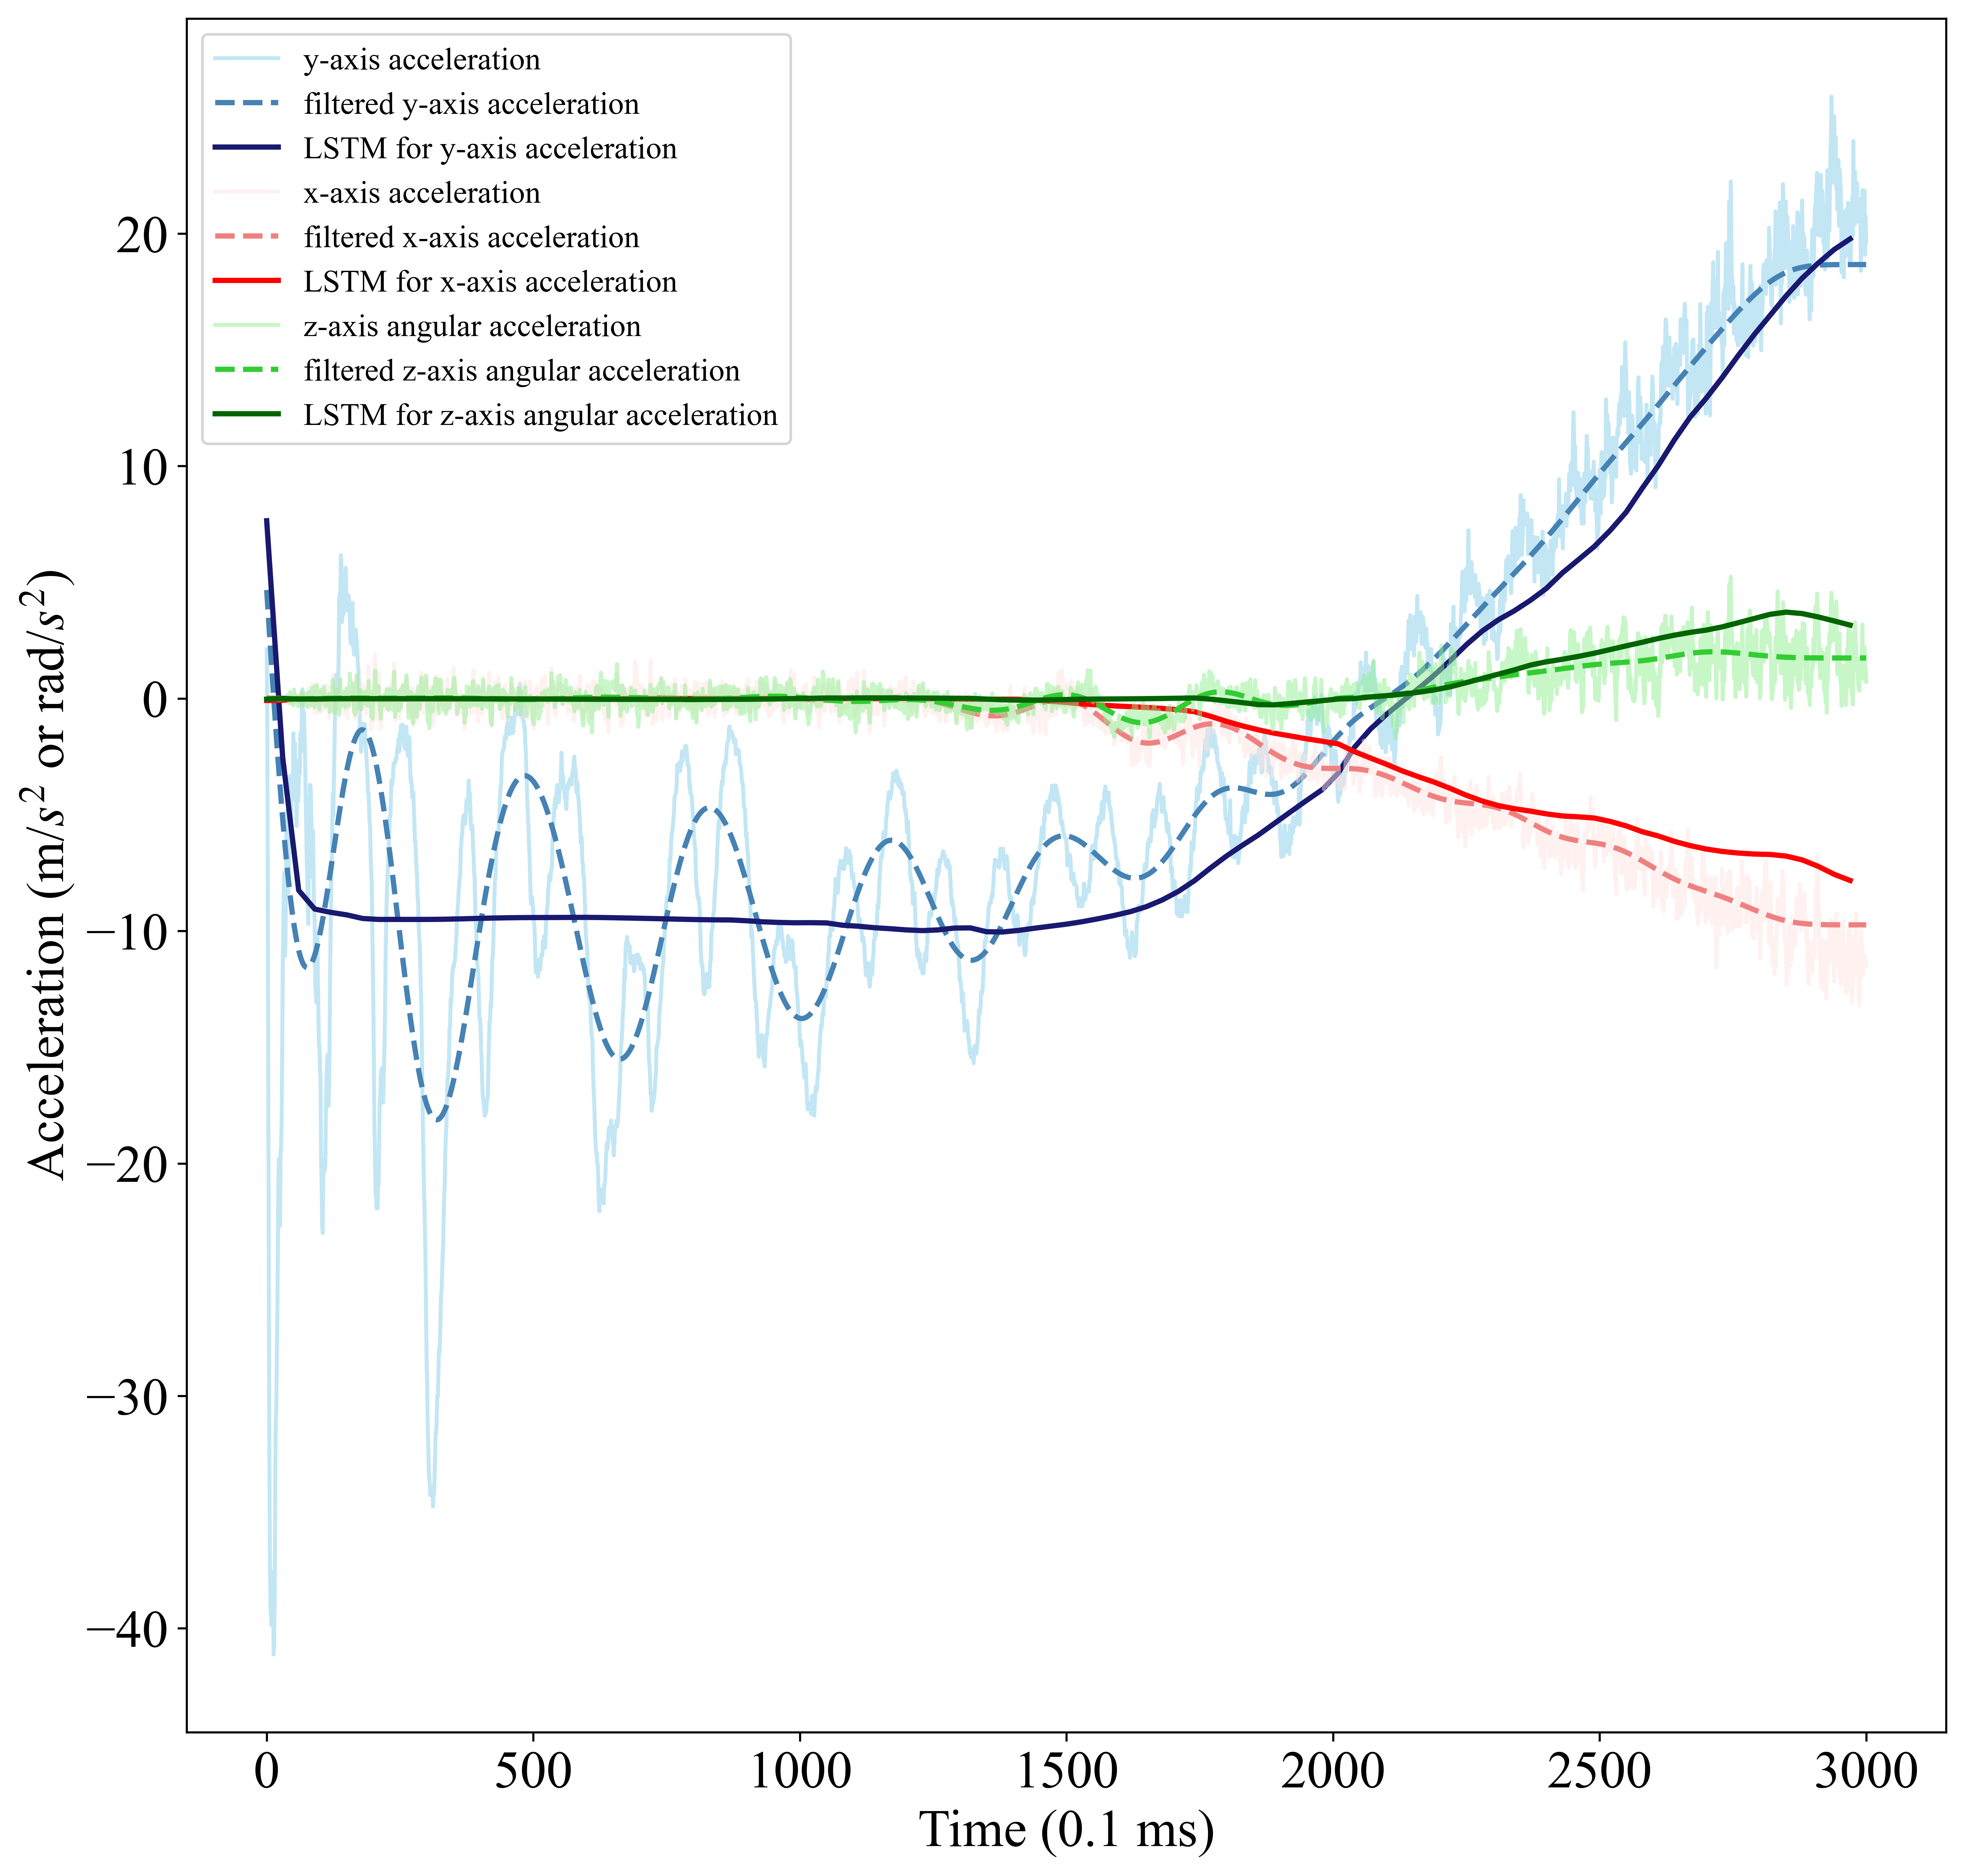

In [32]:
plt.figure(dpi=300,figsize=(12,12))

filtedData_y=rbdoutPlot('Dataset/rbdout_cv/90','ay',True,False)
ac_y=PlotResultForCV(1,109,146,4,8,times_300,scaler_x,model,'ay',False)

filtedData_x=rbdoutPlot('Dataset/rbdout_cv/90','ax',True,False)
ac_x=PlotResultForCV(1,109,146,4,8,times_300,scaler_x,model,'ax',False)

filtedData_r=rbdoutPlot('Dataset/rbdout_cv/90','ar',True,False)
ac_r=PlotResultForCV(1,109,146,4,8,times_300,scaler_x,model,'ar',False)

plt.rcParams.update({"font.size":20})
plt.xlabel('Time (0.1 ms)')
plt.ylabel('Acceleration (m/$s^2$ or rad/$s^2$)')

plt.legend(loc='upper left',prop={'size':12})

1/1 [==============================] - 0s 26ms/step
(100, 3)
1/1 [==============================] - 0s 25ms/step
(100, 3)
1/1 [==============================] - 0s 25ms/step
(100, 3)


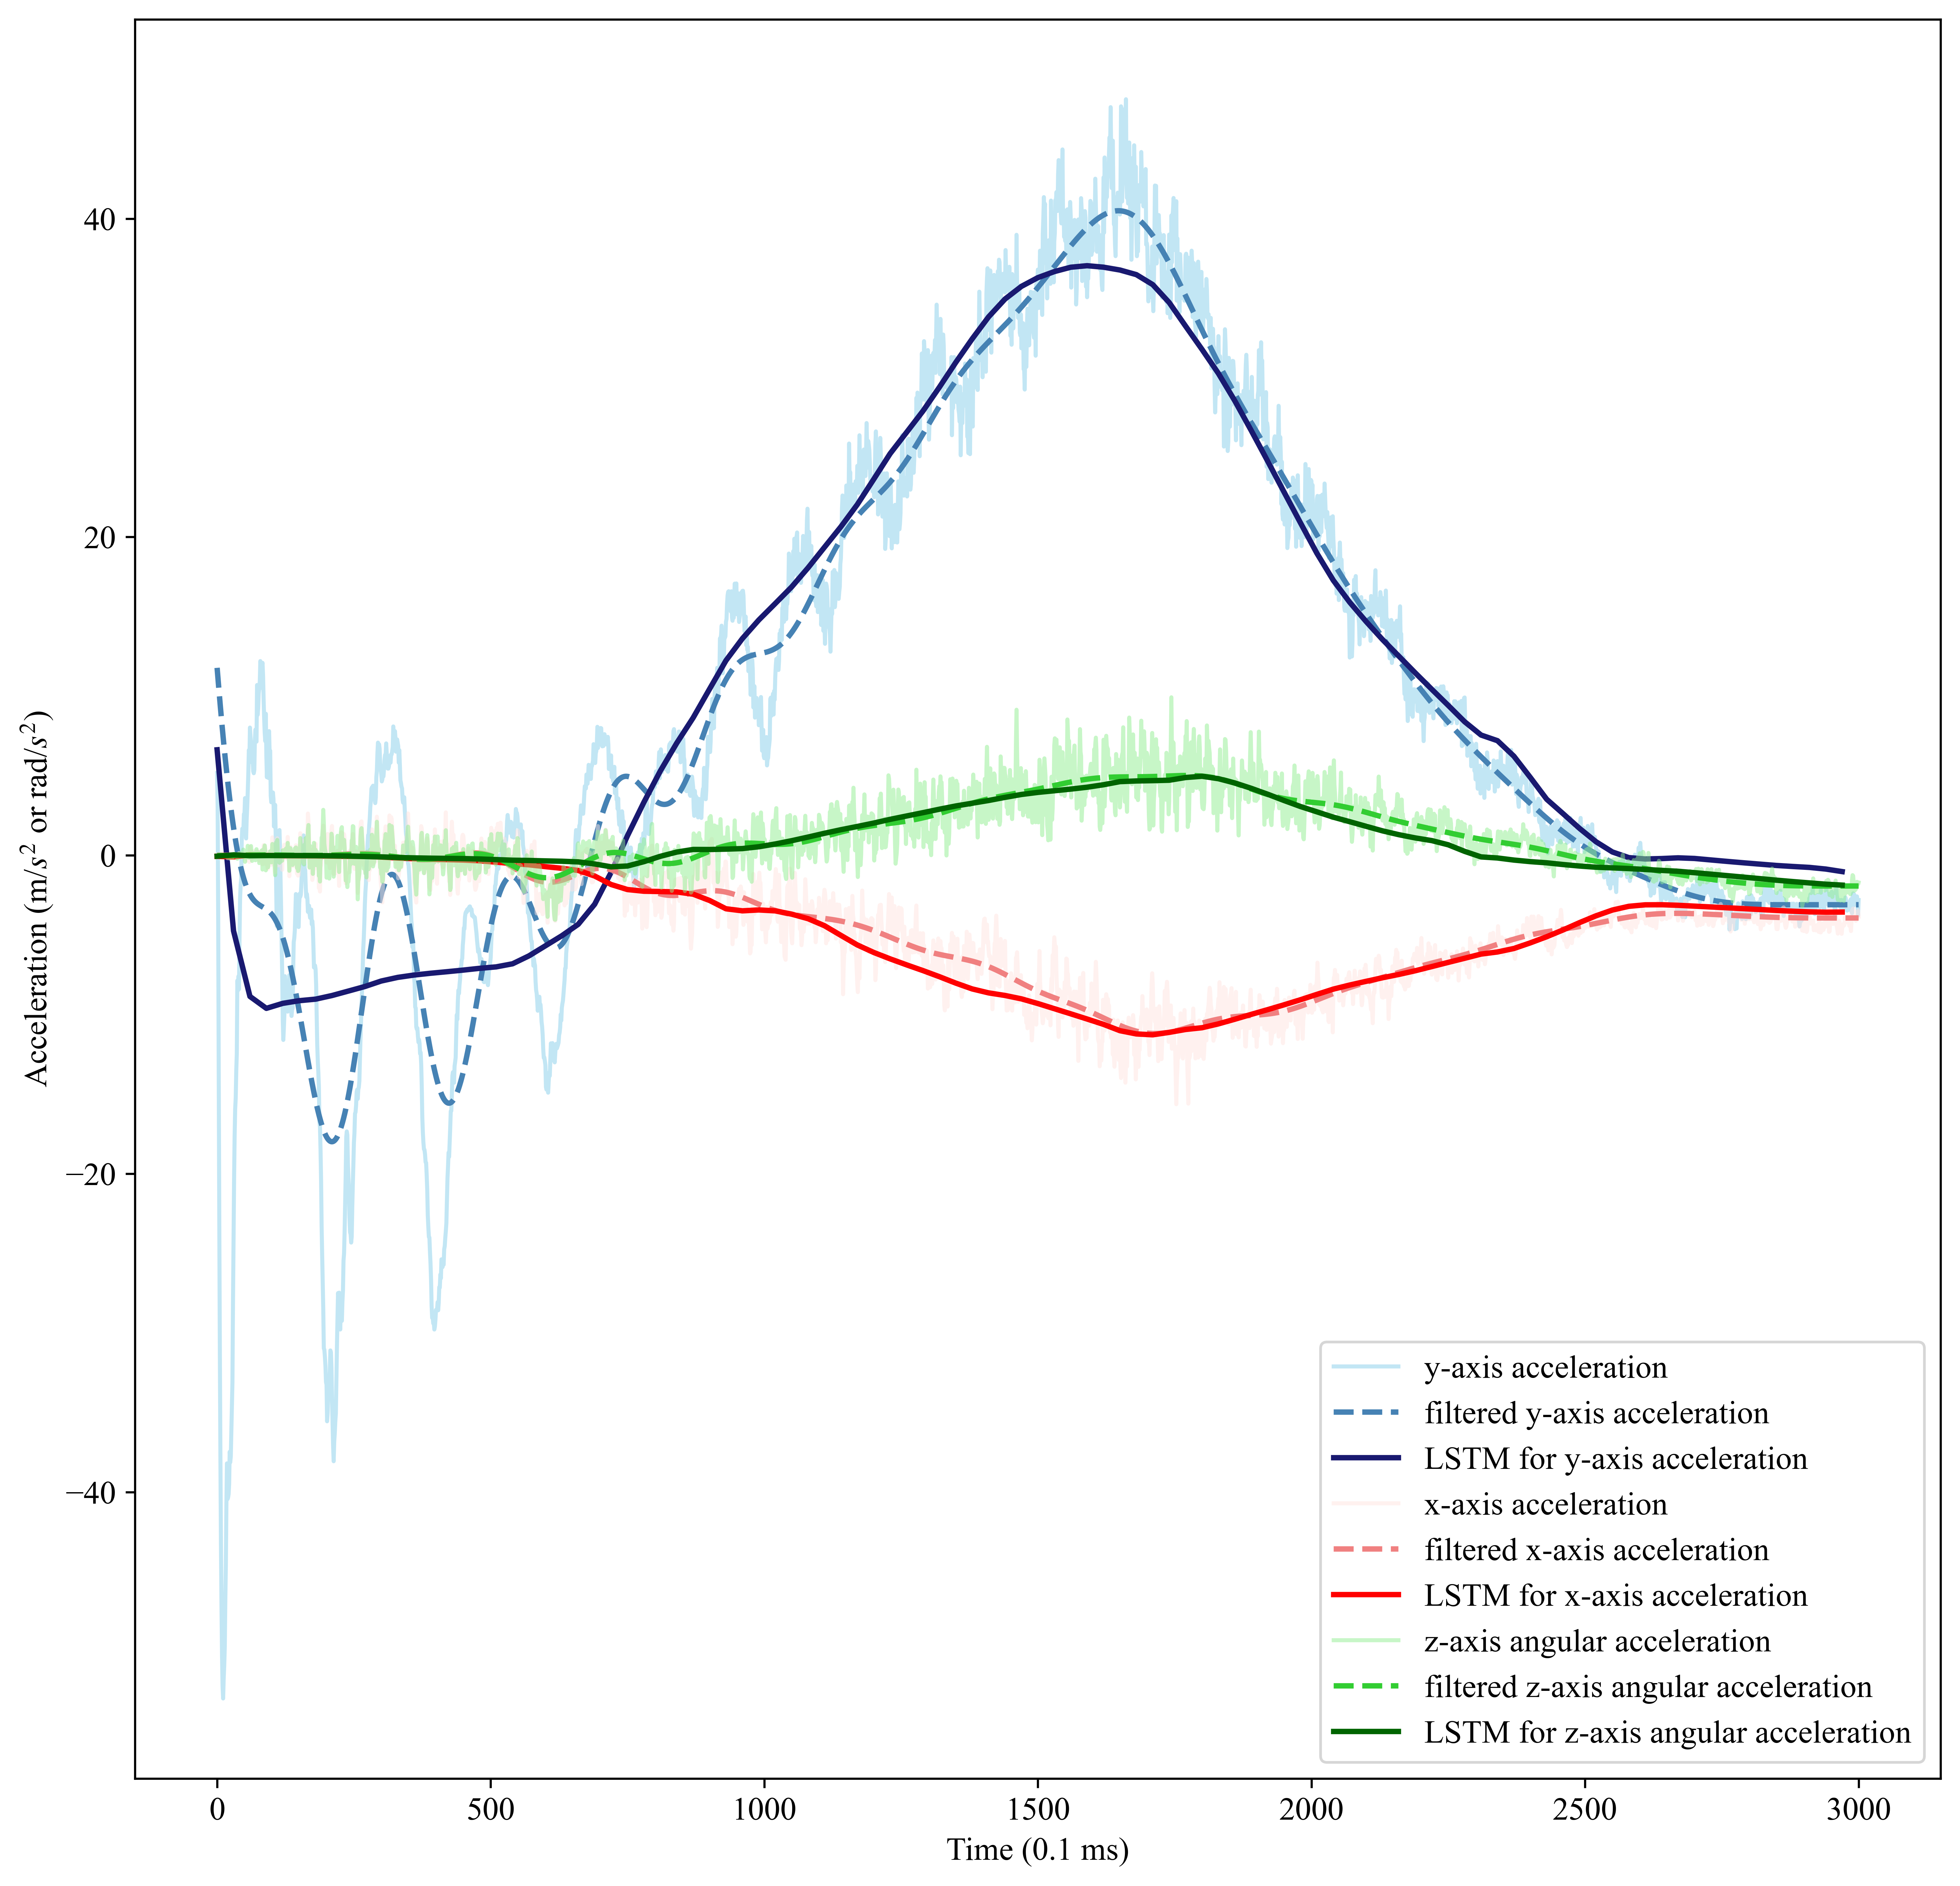

In [30]:
plt.figure(dpi=300,figsize=(12,12))


rbdoutPlot('Dataset/rbdout_cv/92','ay',True,False)
PlotResultForCV(4,122,147,4,6,times_300,scaler_x,model,'ay',False)

rbdoutPlot('Dataset/rbdout_cv/92','ax',True,False)
PlotResultForCV(4,122,147,4,6,times_300,scaler_x,model,'ax',False)


rbdoutPlot('Dataset/rbdout_cv/92','ar',True,False)
PlotResultForCV(4,122,147,4,6,times_300,scaler_x,model,'ar',False)


plt.rcParams.update({"font.size":20})
plt.xlabel('Time (0.1 ms)')
plt.ylabel('Acceleration (m/$s^2$ or rad/$s^2$)')

plt.legend(loc='lower right',prop={'size':12})

1/1 [==============================] - 0s 27ms/step
(100, 3)
1/1 [==============================] - 0s 24ms/step
(100, 3)
1/1 [==============================] - 0s 29ms/step
(100, 3)


(-100.0, 100.0)

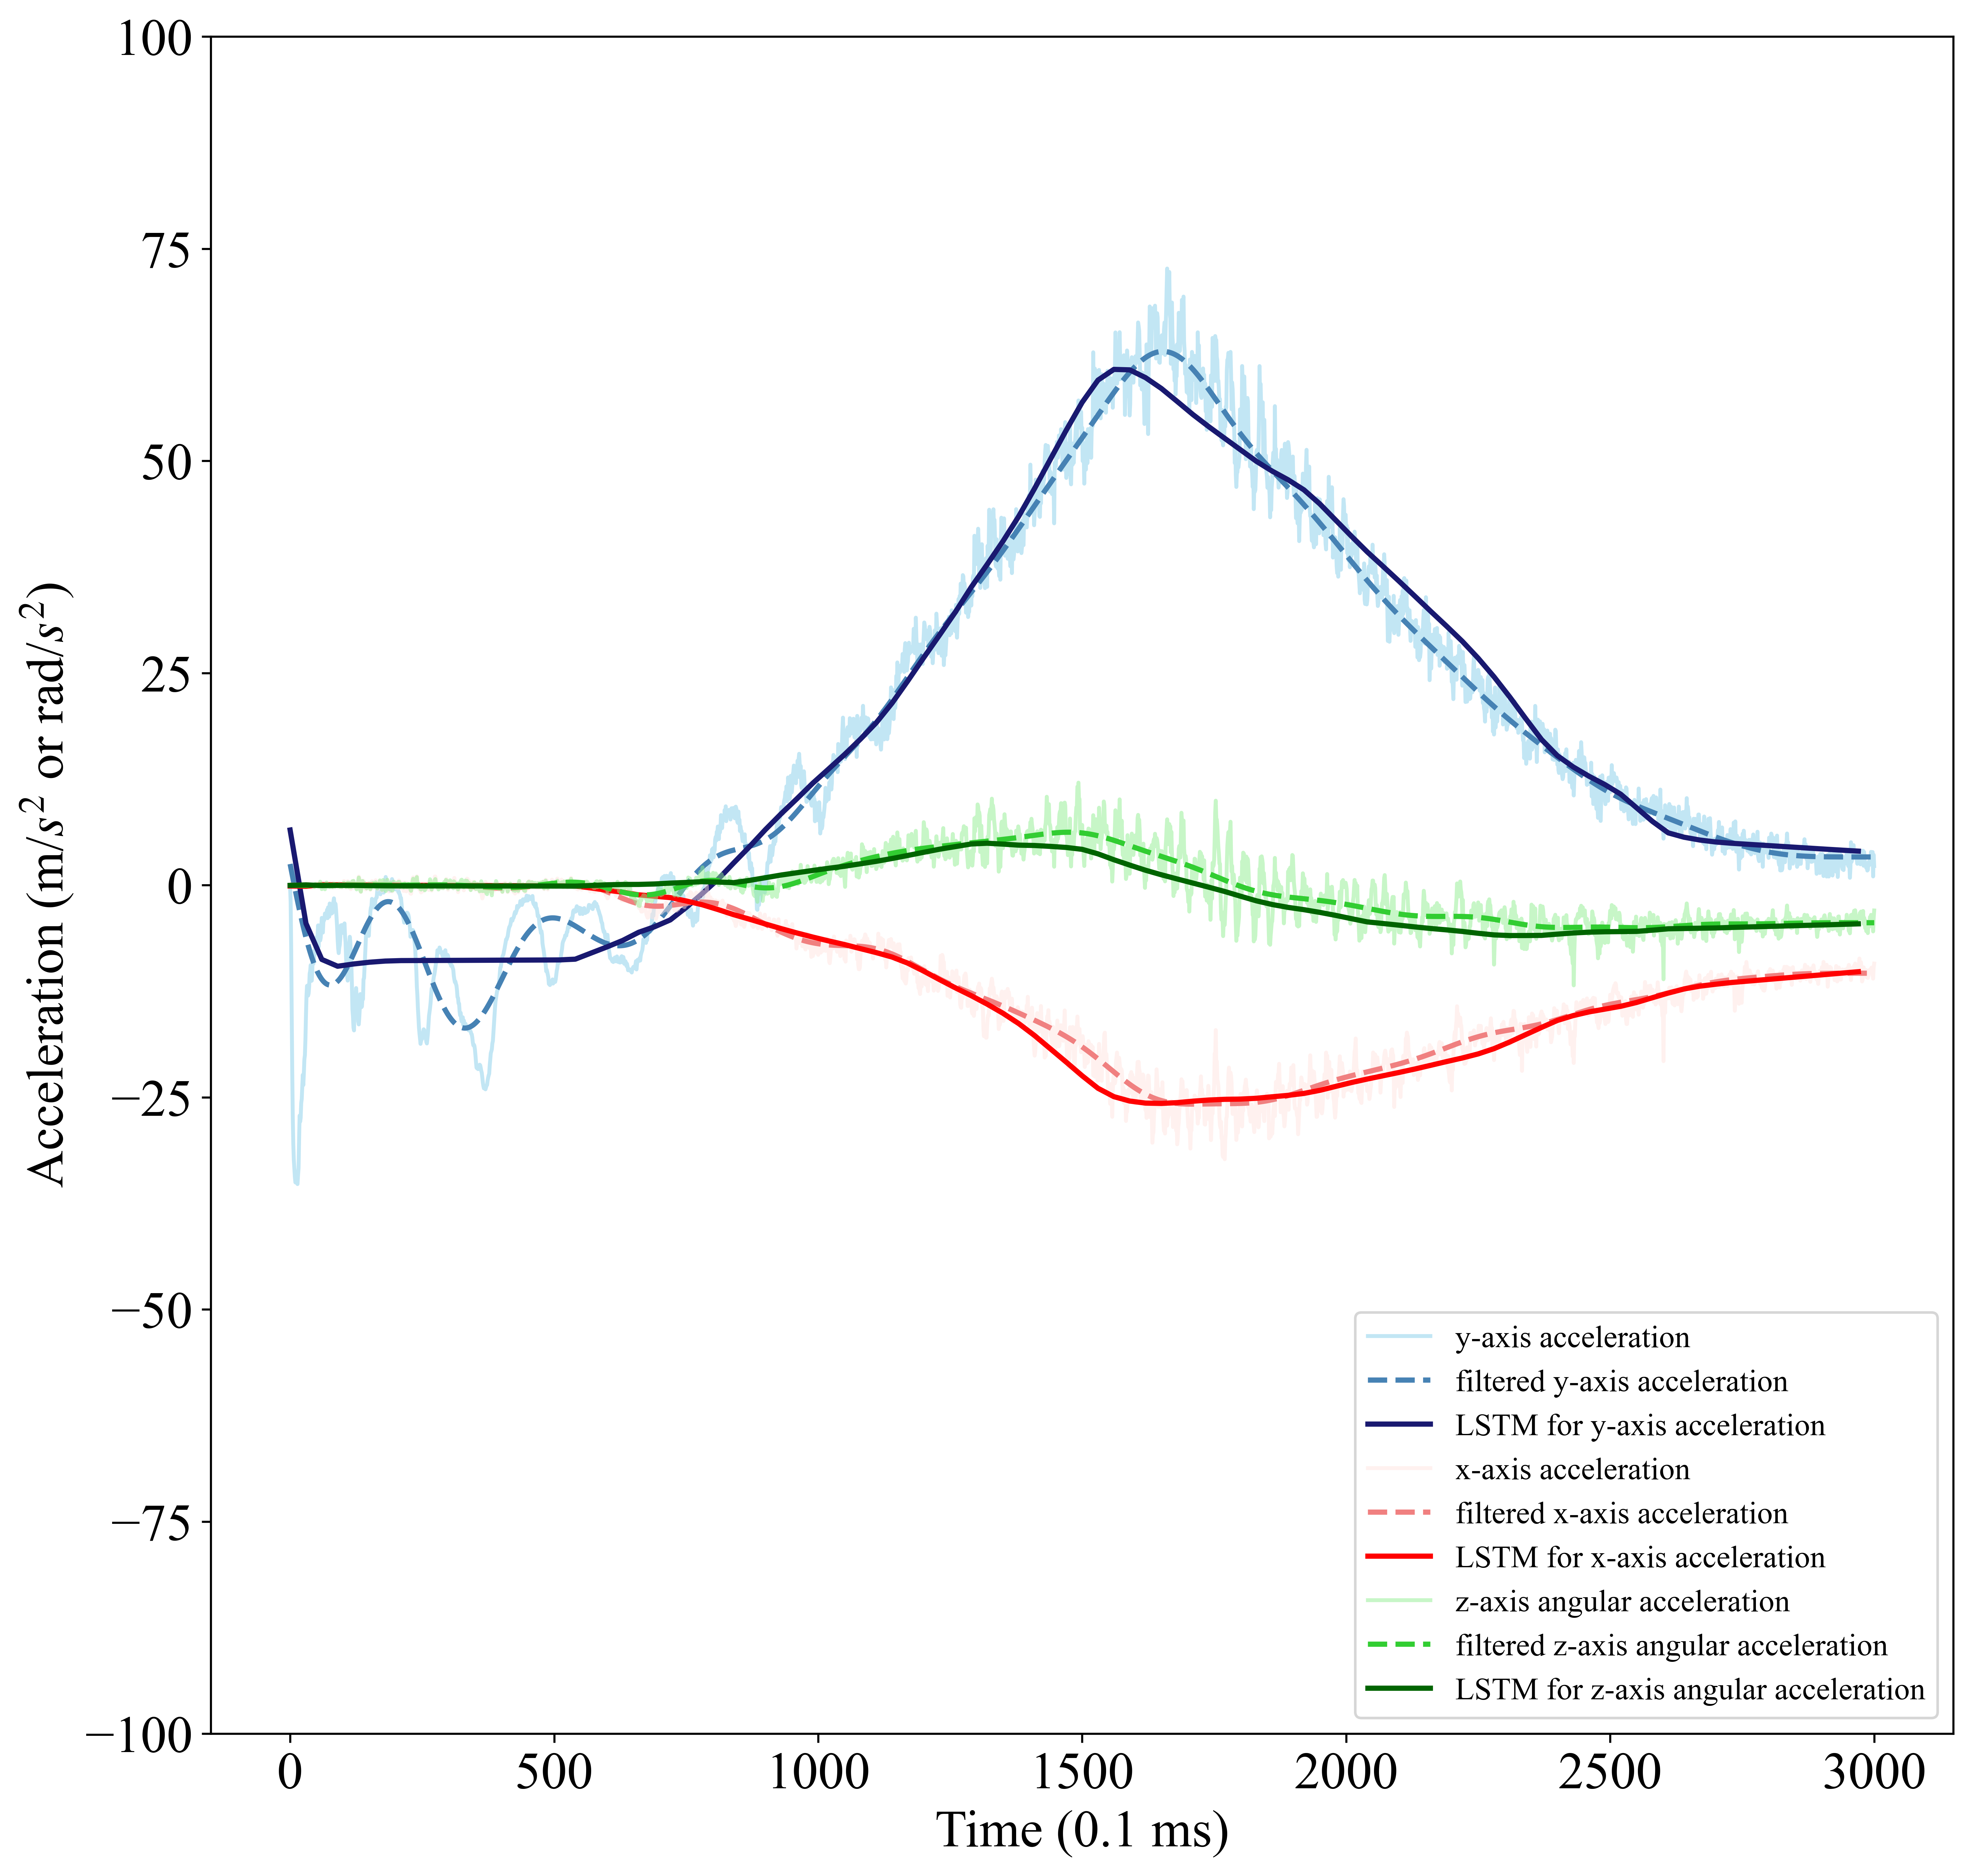

In [36]:
plt.figure(dpi=300,figsize=(12,12))


rbdoutPlot('Dataset/rbdout_cv/97','ay',True,False)
PlotResultForCV(5,108,132,6,13,times_300,scaler_x,model,'ay',False)


rbdoutPlot('Dataset/rbdout_cv/97','ax',True,False)
PlotResultForCV(5,108,132,6,13,times_300,scaler_x,model,'ax',False)

rbdoutPlot('Dataset/rbdout_cv/97','ar',True,False)
PlotResultForCV(5,108,132,6,13,times_300,scaler_x,model,'ar',False)

plt.rcParams.update({"font.size":20})
plt.xlabel('Time (0.1 ms)')
plt.ylabel('Acceleration (m/$s^2$ or rad/$s^2$)')

plt.legend(prop={'size':12},loc=4)
plt.ylim((-100,100))